# **Tối ưu hóa Chiến lược Tiếp thị Thẻ tín dụng thông qua Phân khúc Khách hàng Dựa trên Hành vi**

(clustering) là việc nhóm một tập các đối tượng sao cho những đối tượng trong cùng một nhóm (gọi là một cụm) giống nhau nhiều hơn so \ới các đối tượng thuộc các nhóm khác.


<img src="https://i.postimg.cc/L6myWzkv/image.gif" width="800" height="450">

## **Thông tin về bộ dữ liệu**

Bộ dữ liệu mẫu này tóm tắt hành vi sử dụng của 8.950 chủ thẻ tín dụng đang hoạt động trong 6 tháng gần đây. Tệp dữ liệu ở cấp độ khách hàng với 18 biến hành vi. Nỗ lực của tôi sẽ là phân loại (phân nhóm) lượng dữ liệu này.

Phân khúc thị trường cho phép bạn nhắm mục tiêu nội dung đến đúng người theo đúng cách, thay vì nhắm đến toàn bộ tập khách hàng bằng một thông điệp chung chung. Điều này giúp bạn tăng khả năng mọi người tương tác với quảng cáo hoặc nội dung của bạn, từ đó tạo ra các chiến dịch hiệu quả hơn và cải thiện lợi tức đầu tư (ROI).

## **Câu hỏi đặt ra?**

+ Làm thế nào để phân loại khách hàng dựa trên thói quen sử dụng thẻ (Credit usage) và hành vi thanh toán (Payment behavior) nhằm tối ưu hóa các chiến dịch Marketing?

+ Đặc trưng hành vi nổi bật của từng cụm là gì, và chiến lược hành động tương ứng là gì?

+ Làm thế nào để chuyển dịch khách hàng từ nhóm có giá trị thấp sang nhóm có giá trị cao hơn?

## **Các trường dữ liệu**

**1. Định danh & Tài khoản**
* **`CUST_ID`**: Mã khách hàng.
* **`BALANCE`**: Số dư nợ hiện tại trong thẻ.
* **`CREDIT_LIMIT`**: Hạn mức tín dụng tối đa được cấp.
* **`BALANCE_FREQUENCY`**: Tần suất thay đổi số dư (Dao động từ 0 đến 1; 1 = thay đổi thường xuyên).

**2**. **Hành vi Mua sắm (Spending Behavior)**
* **`PURCHASES`**: Tổng tiền đã chi tiêu qua thẻ.
* **`ONEOFF_PURCHASES`**: Tổng tiền chi tiêu cho các khoản mua đứt (trả thẳng 1 lần).
* **`INSTALLMENTS_PURCHASES`**: Tổng tiền chi tiêu cho các khoản trả góp.
* **`PURCHASES_TRX`**: Số lượng giao dịch mua sắm đã thực hiện.

**3. Hành vi Rút tiền mặt (Cash Advance)**
* **`CASH_ADVANCE`**: Tổng tiền mặt đã ứng/rút từ thẻ.
* **`CASH_ADVANCE_FREQUENCY`**: Tần suất thực hiện việc rút tiền mặt.
* **`CASH_ADVANCE_TRX`**: Số lần rút tiền mặt.

**4. Hành vi Thanh toán (Repayment Behavior)**
* **`PAYMENTS`**: Tổng số tiền khách hàng đã thanh toán vào thẻ.
* **`MINIMUM_PAYMENTS`**: Số tiền thanh toán tối thiểu mà khách hàng đã trả.
* **`PRC_FULL_PAYMENT`**: Tỷ lệ phần trăm các tháng khách hàng trả hết toàn bộ dư nợ (Full pay).

**5. Khác**
* **`TENURE`**: Thời hạn sử dụng thẻ của khách hàng (đơn vị: tháng).

## Thêm các thư viện cần thiết

In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
from math import pi

import warnings
warnings.filterwarnings("ignore")

## **Tải dữ liệu**

Link Dataset: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata

In [2]:
# Tải dữ liệu Online Retail
df = pd.read_csv("Dataset/CC GENERAL.csv")

# Hiển thị các dòng đầu tiên
df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

In [3]:
# Kiểm tra thông tin cơ bản về dữ liệu
print("Thông tin tổng quan:")
print(f"- Kích thước: {df.shape[0]:,} dòng x {df.shape[1]} cột")
print(f"- Giá trị thiếu: {df.isnull().sum().sum():,} giá trị")

df.info()

Thông tin tổng quan:
- Kích thước: 8,950 dòng x 18 cột
- Giá trị thiếu: 314 giá trị
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null 

## **Chuẩn bị dữ liệu**

## **1. KHÁM PHÁ DỮ LIỆU (EDA)**

### **1.1 Thống kê mô tả**

In [4]:
df.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

### **1.2 Phân tích phân phối từng biến**

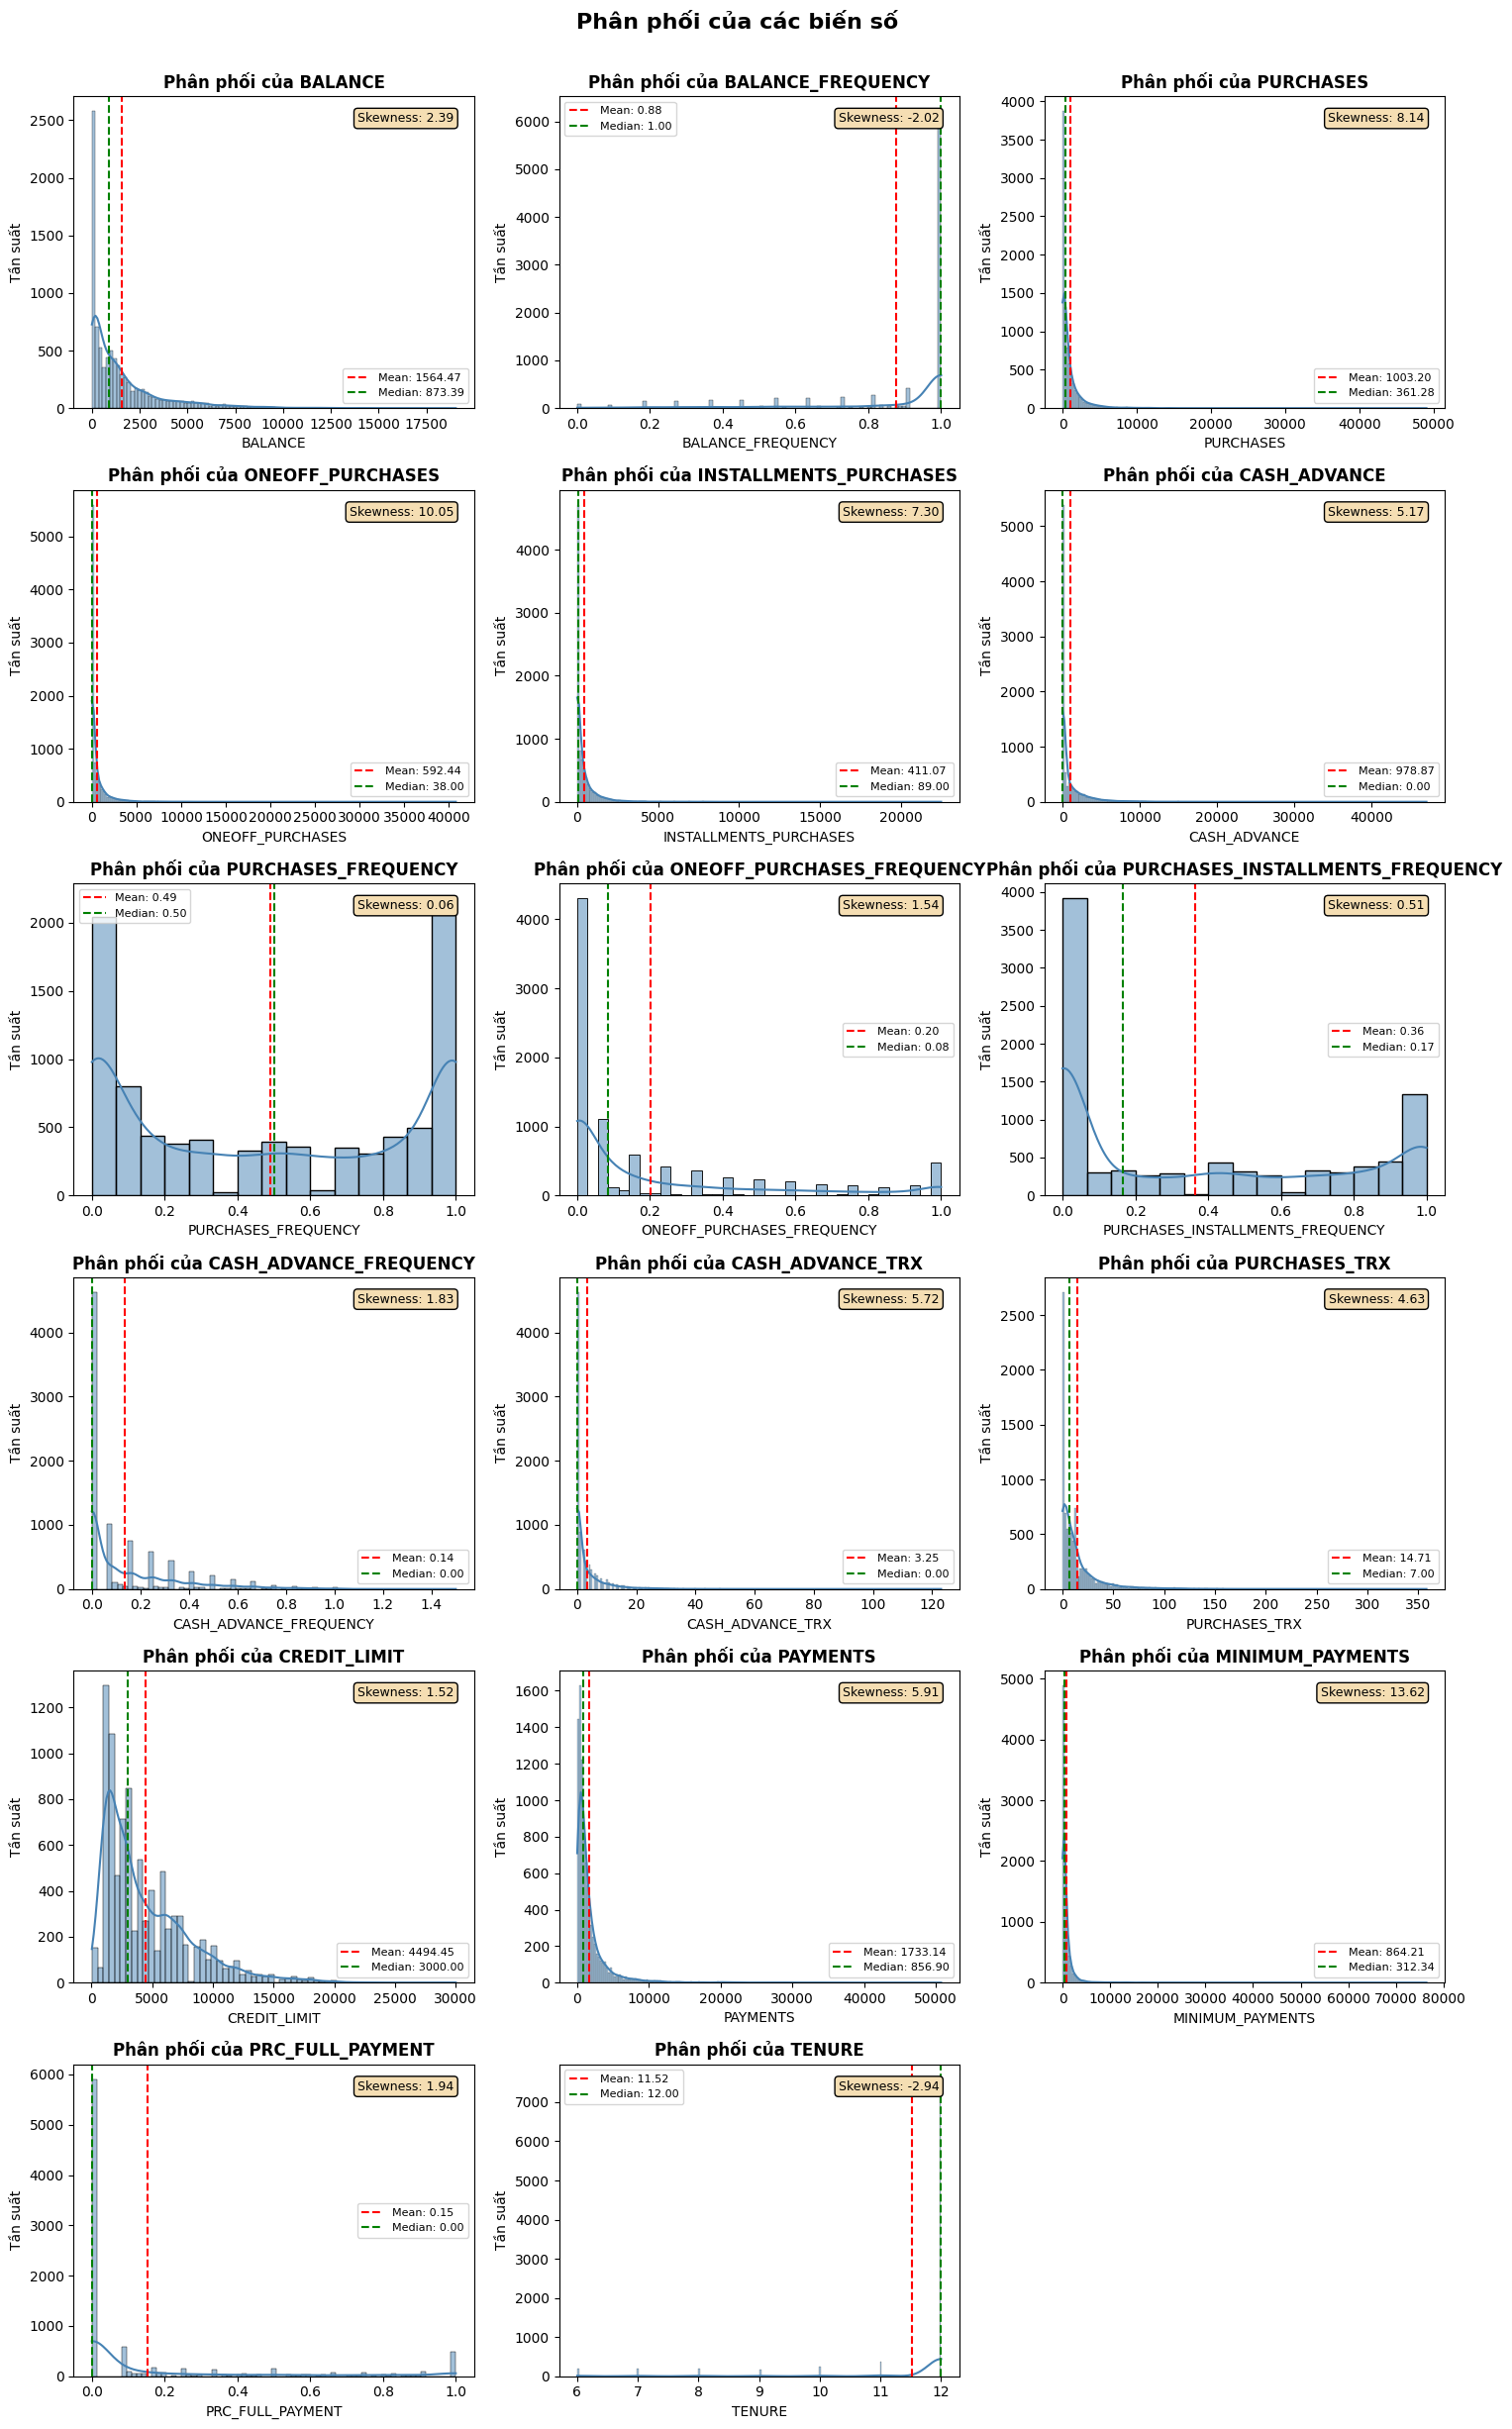


Độ lệch (Skewness) của các biến:
--------------------------------------------------
BALANCE                            :    2.393 - Lệch phải
BALANCE_FREQUENCY                  :   -2.023 - Lệch trái
PURCHASES                          :    8.144 - Lệch phải
ONEOFF_PURCHASES                   :   10.045 - Lệch phải
INSTALLMENTS_PURCHASES             :    7.299 - Lệch phải
CASH_ADVANCE                       :    5.167 - Lệch phải
PURCHASES_FREQUENCY                :    0.060 - Phân phối gần đối xứng
ONEOFF_PURCHASES_FREQUENCY         :    1.536 - Lệch phải
PURCHASES_INSTALLMENTS_FREQUENCY   :    0.509 - Lệch phải
CASH_ADVANCE_FREQUENCY             :    1.829 - Lệch phải
CASH_ADVANCE_TRX                   :    5.721 - Lệch phải
PURCHASES_TRX                      :    4.631 - Lệch phải
CREDIT_LIMIT                       :    1.522 - Lệch phải
PAYMENTS                           :    5.908 - Lệch phải
MINIMUM_PAYMENTS                   :   13.623 - Lệch phải
PRC_FULL_PAYMENT                

In [5]:
# Lấy các cột số (loại bỏ CUST_ID)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Tạo figure với nhiều subplot
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    
    # Vẽ histogram với KDE
    sns.histplot(df[col], kde=True, ax=ax, color='steelblue', edgecolor='black')
    ax.set_title(f'Phân phối của {col}', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Tần suất')
    
    # Thêm thông tin skewness
    skew_val = df[col].skew()
    ax.axvline(df[col].mean(), color='red', linestyle='--', label=f'Mean: {df[col].mean():.2f}')
    ax.axvline(df[col].median(), color='green', linestyle='--', label=f'Median: {df[col].median():.2f}')
    ax.legend(fontsize=8)
    ax.text(0.95, 0.95, f'Skewness: {skew_val:.2f}', transform=ax.transAxes, 
            ha='right', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat'))

# Ẩn các subplot thừa
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.suptitle('Phân phối của các biến số', fontsize=16, fontweight='bold', y=1.02)
plt.show()

# Hiển thị thông tin skewness
print("\nĐộ lệch (Skewness) của các biến:")
print("-" * 50)
for col in numeric_cols:
    skew = df[col].skew()
    if abs(skew) < 0.5:
        skew_type = "Phân phối gần đối xứng"
    elif skew > 0:
        skew_type = "Lệch phải"
    else:
        skew_type = "Lệch trái"
    print(f"{col:35s}: {skew:8.3f} - {skew_type}")

### **1.2.1 Phan tich theo nhom bien (Amount vs Frequency)**

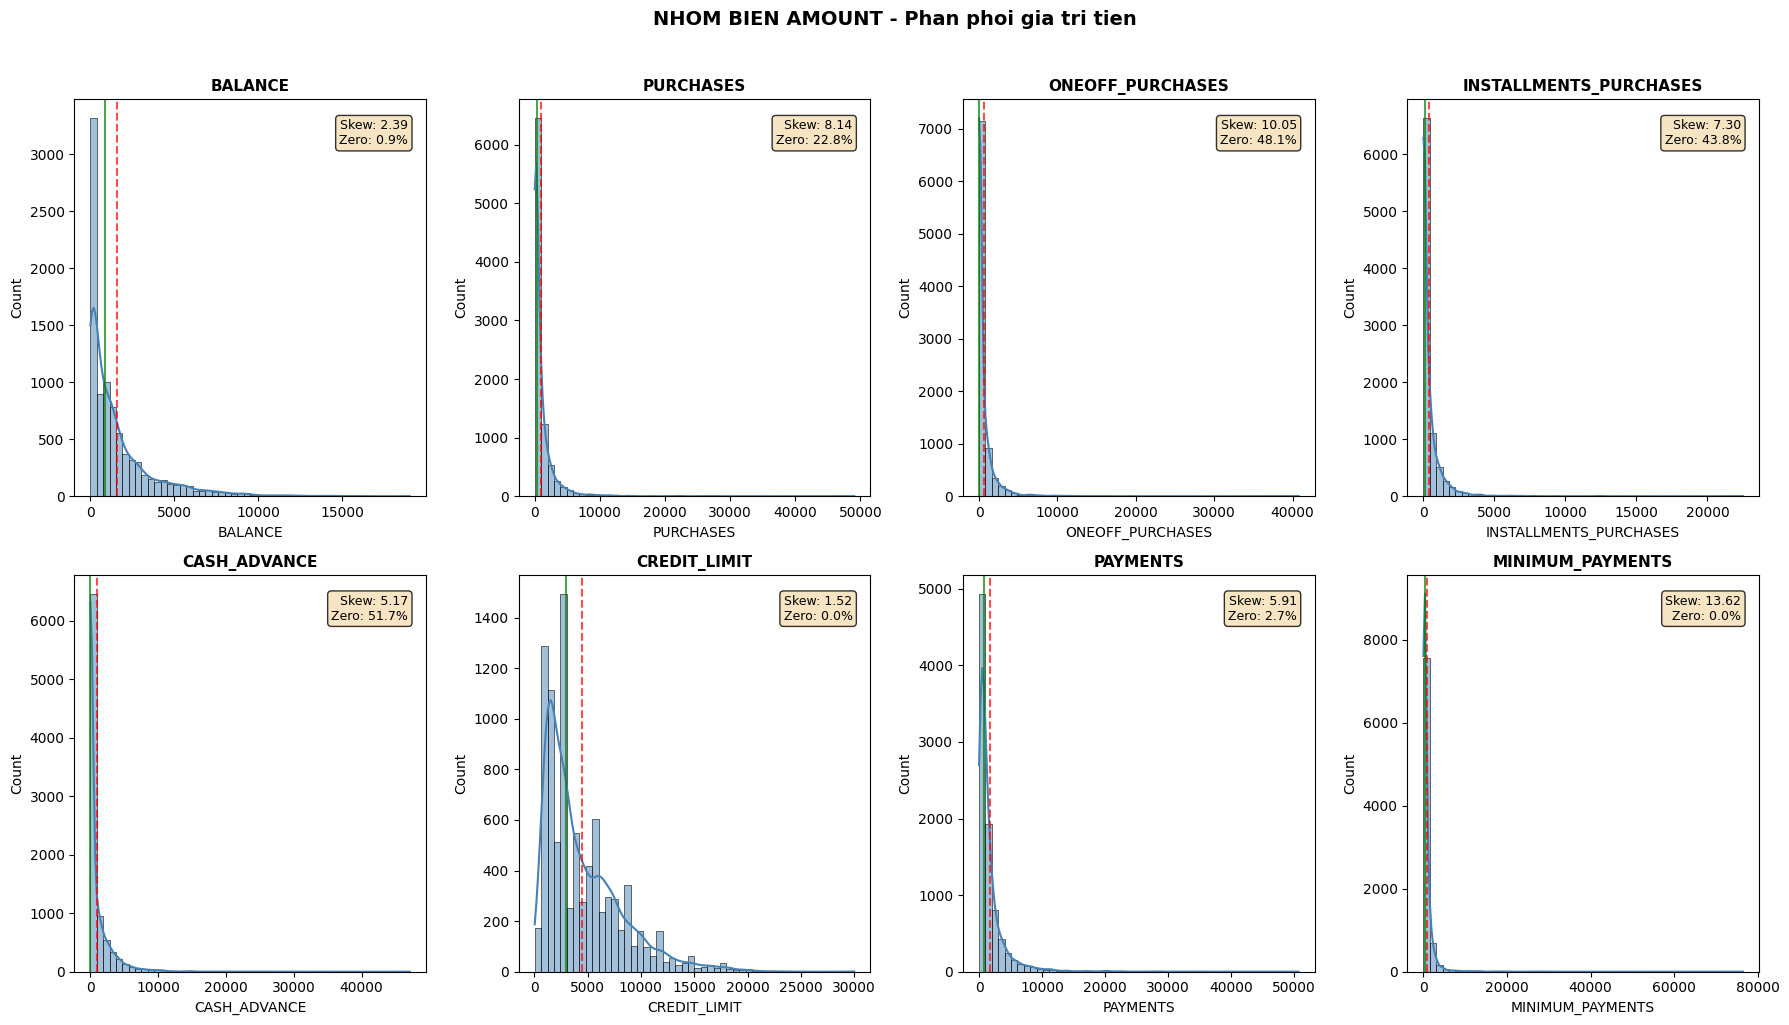

NHAN XET NHOM AMOUNT:
  - BALANCE: Lech phai MANH (skew=2.39) --> Can log transform
  - PURCHASES: Lech phai MANH (skew=8.14) --> Can log transform
    [!] Co 22.8% gia tri = 0 --> Nhom khach hang khong su dung
  - ONEOFF_PURCHASES: Lech phai MANH (skew=10.05) --> Can log transform
    [!] Co 48.1% gia tri = 0 --> Nhom khach hang khong su dung
  - INSTALLMENTS_PURCHASES: Lech phai MANH (skew=7.30) --> Can log transform
    [!] Co 43.8% gia tri = 0 --> Nhom khach hang khong su dung
  - CASH_ADVANCE: Lech phai MANH (skew=5.17) --> Can log transform
    [!] Co 51.7% gia tri = 0 --> Nhom khach hang khong su dung
  - CREDIT_LIMIT: Lech phai (skew=1.52) --> Nen log transform
  - PAYMENTS: Lech phai MANH (skew=5.91) --> Can log transform
  - MINIMUM_PAYMENTS: Lech phai MANH (skew=13.62) --> Can log transform


In [6]:
amount_cols = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
               'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']

frequency_cols = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
                  'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'PRC_FULL_PAYMENT']

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(amount_cols):
    if col in df.columns:
        ax = axes[idx]
        sns.histplot(df[col], kde=True, ax=ax, color='steelblue', edgecolor='black', bins=50)
        ax.set_title(f'{col}', fontsize=11, fontweight='bold')
        
        skew_val = df[col].skew()
        zero_pct = (df[col] == 0).sum() / len(df) * 100
        
        info_text = f'Skew: {skew_val:.2f}\nZero: {zero_pct:.1f}%'
        ax.text(0.95, 0.95, info_text, transform=ax.transAxes, ha='right', va='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        ax.axvline(df[col].mean(), color='red', linestyle='--', linewidth=1.5, alpha=0.7)
        ax.axvline(df[col].median(), color='green', linestyle='-', linewidth=1.5, alpha=0.7)

plt.suptitle('NHOM BIEN AMOUNT - Phan phoi gia tri tien', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("=" * 70)
print("NHAN XET NHOM AMOUNT:")
print("=" * 70)
for col in amount_cols:
    if col in df.columns:
        skew = df[col].skew()
        zero_pct = (df[col] == 0).sum() / len(df) * 100
        if skew > 2:
            print(f"  - {col}: Lech phai MANH (skew={skew:.2f}) --> Can log transform")
        elif skew > 1:
            print(f"  - {col}: Lech phai (skew={skew:.2f}) --> Nen log transform")
        if zero_pct > 20:
            print(f"    [!] Co {zero_pct:.1f}% gia tri = 0 --> Nhom khach hang khong su dung")

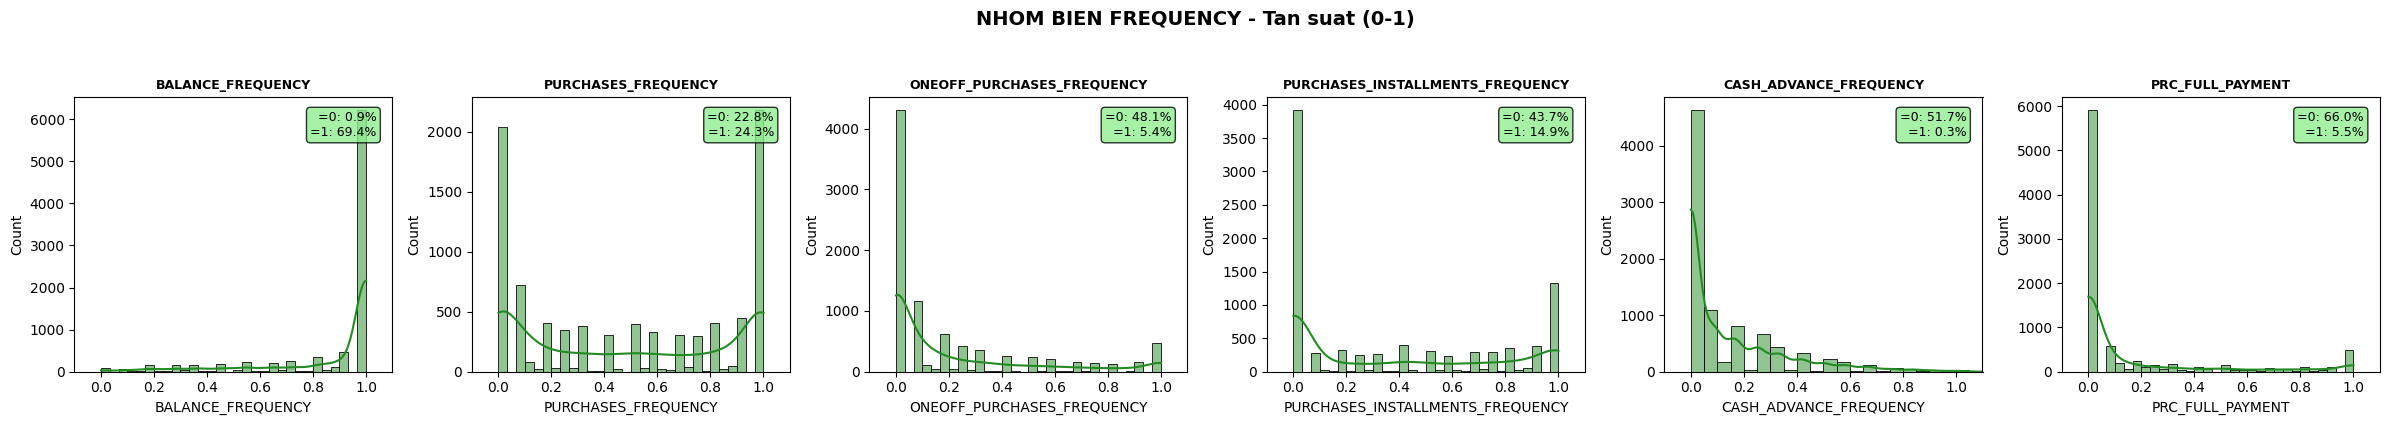


NHAN XET NHOM FREQUENCY:
  - Cac bien frequency co gia tri tu 0 den 1
  - Can scale CUNG voi nhom amount de dam bao cong bang trong clustering
  - Nhieu khach hang co frequency = 0 hoac = 1 (hanh vi cuc doan)


In [7]:
freq_cols_exist = [col for col in frequency_cols if col in df.columns]

n_freq = len(freq_cols_exist)
fig, axes = plt.subplots(1, min(n_freq, 6), figsize=(4*min(n_freq, 6), 4))
if n_freq == 1:
    axes = [axes]

for idx, col in enumerate(freq_cols_exist[:6]):
    ax = axes[idx]
    sns.histplot(df[col], kde=True, ax=ax, color='forestgreen', edgecolor='black', bins=30)
    ax.set_title(f'{col}', fontsize=9, fontweight='bold')
    ax.set_xlim(-0.1, 1.1)
    
    at_zero = (df[col] == 0).sum() / len(df) * 100
    at_one = (df[col] == 1).sum() / len(df) * 100
    ax.text(0.95, 0.95, f'=0: {at_zero:.1f}%\n=1: {at_one:.1f}%',
            transform=ax.transAxes, ha='right', va='top', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.suptitle('NHOM BIEN FREQUENCY - Tan suat (0-1)', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("NHAN XET NHOM FREQUENCY:")
print("=" * 70)
print("  - Cac bien frequency co gia tri tu 0 den 1")
print("  - Can scale CUNG voi nhom amount de dam bao cong bang trong clustering")
print("  - Nhieu khach hang co frequency = 0 hoac = 1 (hanh vi cuc doan)")

### **1.3 Ma trận tương quan**

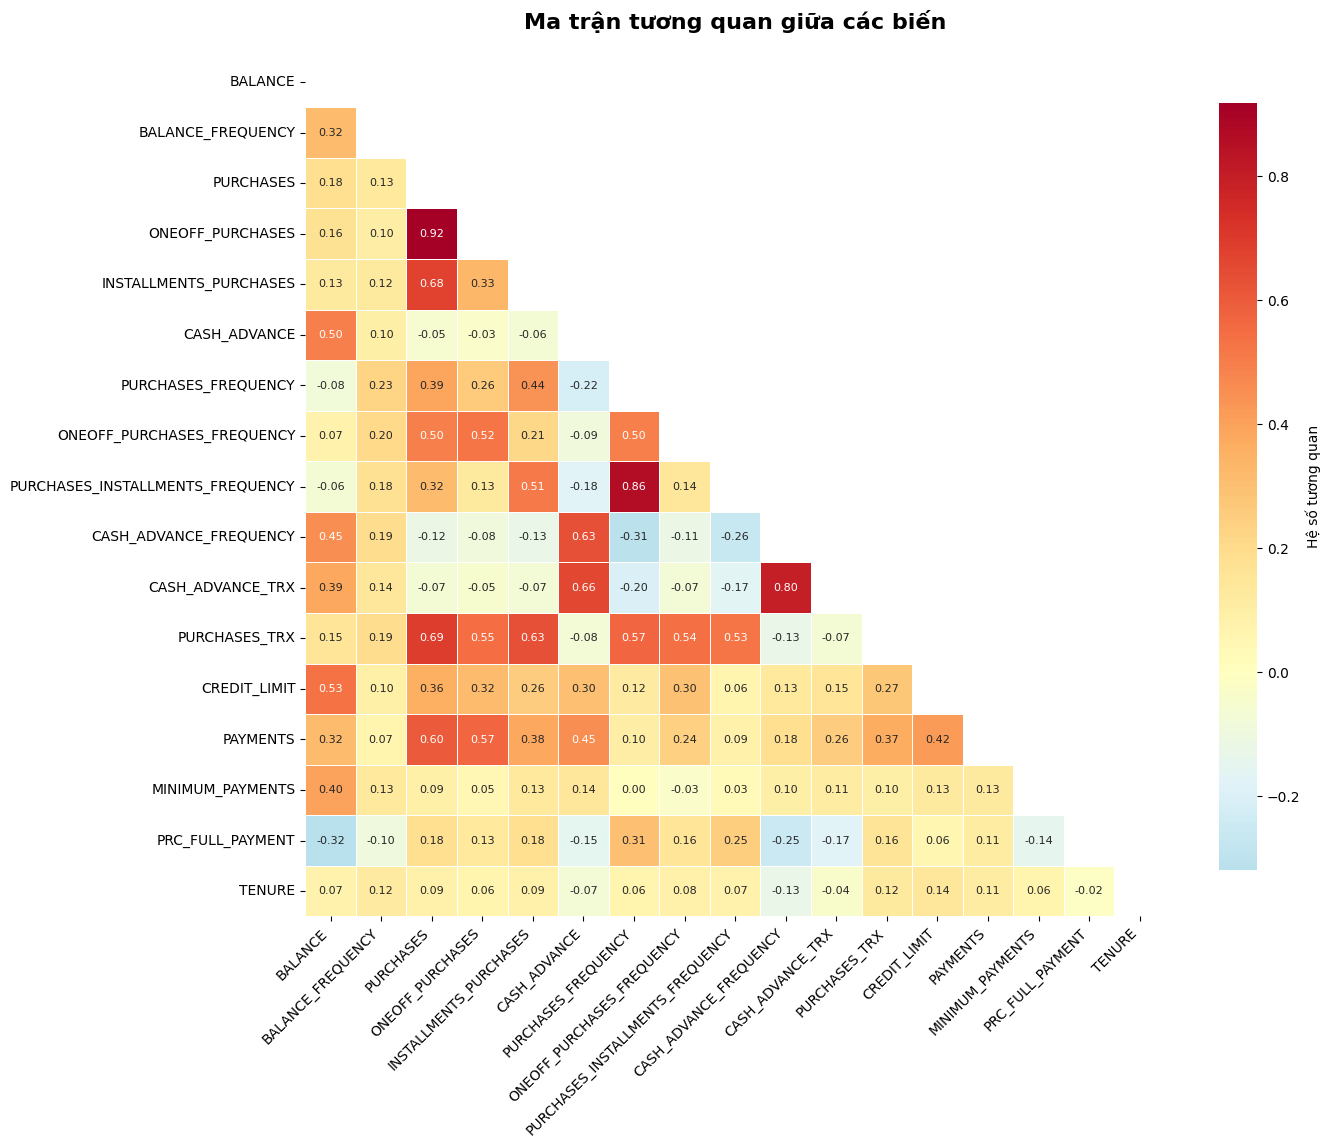


các cặp biến có tương quan CAO (|r| > 0.7):
------------------------------------------------------------


Biến 1                            Biến 2  Tương quan
0               PURCHASES                  ONEOFF_PURCHASES    0.916845
1     PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY    0.862934
2  CASH_ADVANCE_FREQUENCY                  CASH_ADVANCE_TRX    0.799561

In [8]:
# Tính ma trận tương quan (chỉ với các cột số)
df_numeric = df.select_dtypes(include=[np.number])
correlation_matrix = df_numeric.corr()

# Vẽ heatmap
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask nửa trên

sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='RdYlBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Hệ số tương quan"},
            annot_kws={"size": 8})

plt.title('Ma trận tương quan giữa các biến', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Tìm các cặp biến có tương quan cao
print("\ncác cặp biến có tương quan CAO (|r| > 0.7):")
print("-" * 60)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append({
                'Biến 1': correlation_matrix.columns[i],
                'Biến 2': correlation_matrix.columns[j],
                'Tương quan': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Tương quan', ascending=False)
    display(high_corr_df)
else:
    print("Không có cặp biến nào có tương quan cao (|r| > 0.7)")

### **1.3.1 Scatter Plots - Phat hien Patterns**

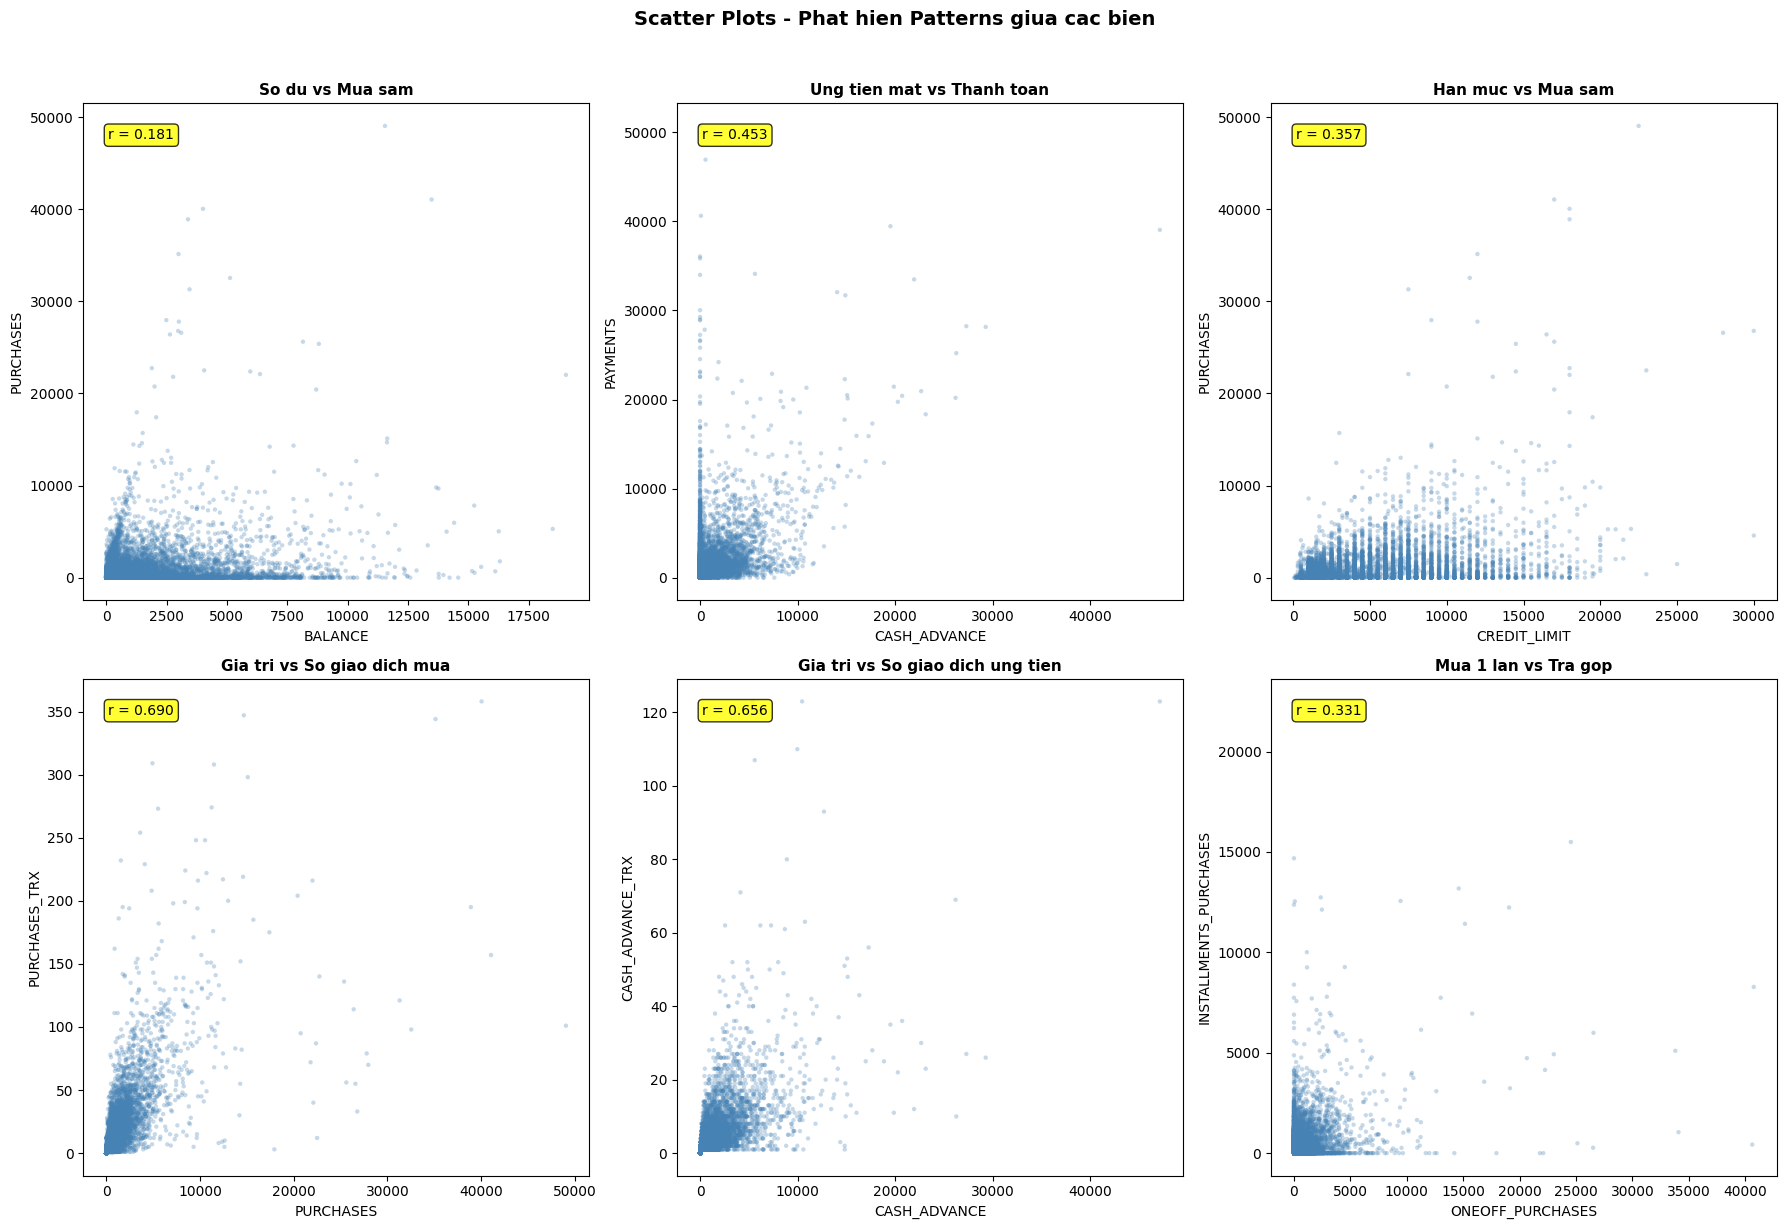

PHAT HIEN TU SCATTER PLOTS:
  - Co 2044 khach hang (22.8%) khong mua sam (PURCHASES=0)
  - Co 4322 khach hang (48.3%) su dung ung tien mat
  - [!] Co 2043 khach hang KHONG mua sam nhung CO ung tien mat
      --> Day la nhom hanh vi DAC BIET, co the la nhom rui ro cao

  - PURCHASES vs PURCHASES_TRX: r = 0.690
      --> Tuong quan CAO, co the loai 1 bien de giam redundancy


In [9]:
scatter_pairs = [
    ('BALANCE', 'PURCHASES', 'So du vs Mua sam'),
    ('CASH_ADVANCE', 'PAYMENTS', 'Ung tien mat vs Thanh toan'),
    ('CREDIT_LIMIT', 'PURCHASES', 'Han muc vs Mua sam'),
    ('PURCHASES', 'PURCHASES_TRX', 'Gia tri vs So giao dich mua'),
    ('CASH_ADVANCE', 'CASH_ADVANCE_TRX', 'Gia tri vs So giao dich ung tien'),
    ('ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'Mua 1 lan vs Tra gop')
]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (col1, col2, title) in enumerate(scatter_pairs):
    if col1 in df.columns and col2 in df.columns:
        ax = axes[idx]
        ax.scatter(df[col1], df[col2], alpha=0.3, s=10, c='steelblue', edgecolors='none')
        ax.set_xlabel(col1, fontsize=10)
        ax.set_ylabel(col2, fontsize=10)
        ax.set_title(title, fontsize=11, fontweight='bold')
        
        corr = df[col1].corr(df[col2])
        ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, fontsize=10, va='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

plt.suptitle('Scatter Plots - Phat hien Patterns giua cac bien', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("=" * 70)
print("PHAT HIEN TU SCATTER PLOTS:")
print("=" * 70)

no_purchase = (df['PURCHASES'] == 0).sum()
has_cash_advance = (df['CASH_ADVANCE'] > 0).sum()
no_purchase_has_cash = ((df['PURCHASES'] == 0) & (df['CASH_ADVANCE'] > 0)).sum()

print(f"  - Co {no_purchase} khach hang ({no_purchase/len(df)*100:.1f}%) khong mua sam (PURCHASES=0)")
print(f"  - Co {has_cash_advance} khach hang ({has_cash_advance/len(df)*100:.1f}%) su dung ung tien mat")
print(f"  - [!] Co {no_purchase_has_cash} khach hang KHONG mua sam nhung CO ung tien mat")
print(f"      --> Day la nhom hanh vi DAC BIET, co the la nhom rui ro cao")
print(f"\n  - PURCHASES vs PURCHASES_TRX: r = {df['PURCHASES'].corr(df['PURCHASES_TRX']):.3f}")
print(f"      --> Tuong quan CAO, co the loai 1 bien de giam redundancy")

In [10]:
print("=" * 70)
print("PHAN TICH NHOM BIEN TUONG QUAN MANH")
print("=" * 70)

corr_pairs_analysis = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            level = 'RAT CAO' if abs(corr_val) > 0.8 else ('CAO' if abs(corr_val) > 0.7 else 'TRUNG BINH')
            corr_pairs_analysis.append({
                'Bien 1': correlation_matrix.columns[i],
                'Bien 2': correlation_matrix.columns[j],
                'Correlation': round(corr_val, 3),
                'Muc do': level
            })

corr_analysis_df = pd.DataFrame(corr_pairs_analysis).sort_values('Correlation', ascending=False)
print("\nCac cap bien co tuong quan |r| > 0.5:")
display(corr_analysis_df)

print("\n" + "-" * 70)
print("NHOM TUONG QUAN:")
print("-" * 70)
print("""
  NHOM 1 - Hanh vi MUA SAM:
  - PURCHASES <-> PURCHASES_TRX <-> ONEOFF_PURCHASES <-> INSTALLMENTS_PURCHASES
  - PURCHASES_FREQUENCY <-> cac bien frequency khac
  --> Khach hang mua nhieu thi tan suat cao

  NHOM 2 - Hanh vi UNG TIEN MAT:
  - CASH_ADVANCE <-> CASH_ADVANCE_TRX <-> CASH_ADVANCE_FREQUENCY
  --> Khach hang ung tien thuong ung nhieu lan

  NHOM 3 - Kha nang THANH TOAN:
  - CREDIT_LIMIT <-> BALANCE <-> PAYMENTS
  --> Han muc cao thuong di kem so du va thanh toan cao

  [!] LUU Y: Nhieu bien trong cung nhom co the gay REDUNDANCY
      --> Can can nhac loai bot hoac dung PCA
""")

PHAN TICH NHOM BIEN TUONG QUAN MANH

Cac cap bien co tuong quan |r| > 0.5:


Bien 1                            Bien 2  \
1                          PURCHASES                  ONEOFF_PURCHASES   
13               PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY   
17            CASH_ADVANCE_FREQUENCY                  CASH_ADVANCE_TRX   
3                          PURCHASES                     PURCHASES_TRX   
2                          PURCHASES            INSTALLMENTS_PURCHASES   
11                      CASH_ADVANCE                  CASH_ADVANCE_TRX   
10                      CASH_ADVANCE            CASH_ADVANCE_FREQUENCY   
9             INSTALLMENTS_PURCHASES                     PURCHASES_TRX   
4                          PURCHASES                          PAYMENTS   
14               PURCHASES_FREQUENCY                     PURCHASES_TRX   
7                   ONEOFF_PURCHASES                          PAYMENTS   
6                   ONEOFF_PURCHASES                     PURCHASES_TRX   
15        ONEOFF_PURCHASES_FREQUENCY                     PURCHASES_TRX   
0                            BALANCE                      CREDIT_LIMIT   
16  PURCHASES_INSTALLMENTS_FREQUENCY                     PURCHASES_TRX   
5                   ONEOFF_PURCHASES        ONEOFF_PURCHASES_FREQUENCY   
8             INSTALLMENTS_PURCHASES  PURCHASES_INSTALLMENTS_FREQUENCY   
12               PURCHASES_FREQUENCY        ONEOFF_PURCHASES_FREQUENCY   

    Correlation      Muc do  
1         0.917     RAT CAO  
13        0.863     RAT CAO  
17        0.800         CAO  
3         0.690  TRUNG BINH  
2         0.680  TRUNG BINH  
11        0.656  TRUNG BINH  
10        0.629  TRUNG BINH  
9         0.628  TRUNG BINH  
4         0.603  TRUNG BINH  
14        0.568  TRUNG BINH  
7         0.567  TRUNG BINH  
6         0.546  TRUNG BINH  
15        0.545  TRUNG BINH  
0         0.531  TRUNG BINH  
16        0.530  TRUNG BINH  
5         0.525  TRUNG BINH  
8         0.511  TRUNG BINH  
12        0.501  TRUNG BINH


----------------------------------------------------------------------
NHOM TUONG QUAN:
----------------------------------------------------------------------

  NHOM 1 - Hanh vi MUA SAM:
  - PURCHASES <-> PURCHASES_TRX <-> ONEOFF_PURCHASES <-> INSTALLMENTS_PURCHASES
  - PURCHASES_FREQUENCY <-> cac bien frequency khac
  --> Khach hang mua nhieu thi tan suat cao

  NHOM 2 - Hanh vi UNG TIEN MAT:
  - CASH_ADVANCE <-> CASH_ADVANCE_TRX <-> CASH_ADVANCE_FREQUENCY
  --> Khach hang ung tien thuong ung nhieu lan

  NHOM 3 - Kha nang THANH TOAN:
  - CREDIT_LIMIT <-> BALANCE <-> PAYMENTS
  --> Han muc cao thuong di kem so du va thanh toan cao

  [!] LUU Y: Nhieu bien trong cung nhom co the gay REDUNDANCY
      --> Can can nhac loai bot hoac dung PCA



### **1.4 Phát hiện outliers**

Thống kê Outliers theo phương pháp IQR:
Biến                                 Số outliers    Tỷ lệ (%)   Giới hạn dưới   Giới hạn trên
--------------------------------------------------------------------------------
BALANCE                                      695        7.77%        -2760.51         4942.93
BALANCE_FREQUENCY                          1,493       16.68%            0.72            1.17
PURCHASES                                    808        9.03%        -1566.11         2715.87
ONEOFF_PURCHASES                           1,013       11.32%         -866.11         1443.51
INSTALLMENTS_PURCHASES                       867        9.69%         -702.96         1171.59
CASH_ADVANCE                               1,030       11.51%        -1670.73         2784.55
PURCHASES_FREQUENCY                            0        0.00%           -1.17            2.17
ONEOFF_PURCHASES_FREQUENCY                   782        8.74%           -0.45            0.75
PURCHASES_INSTALLMENTS_FREQUENCY 

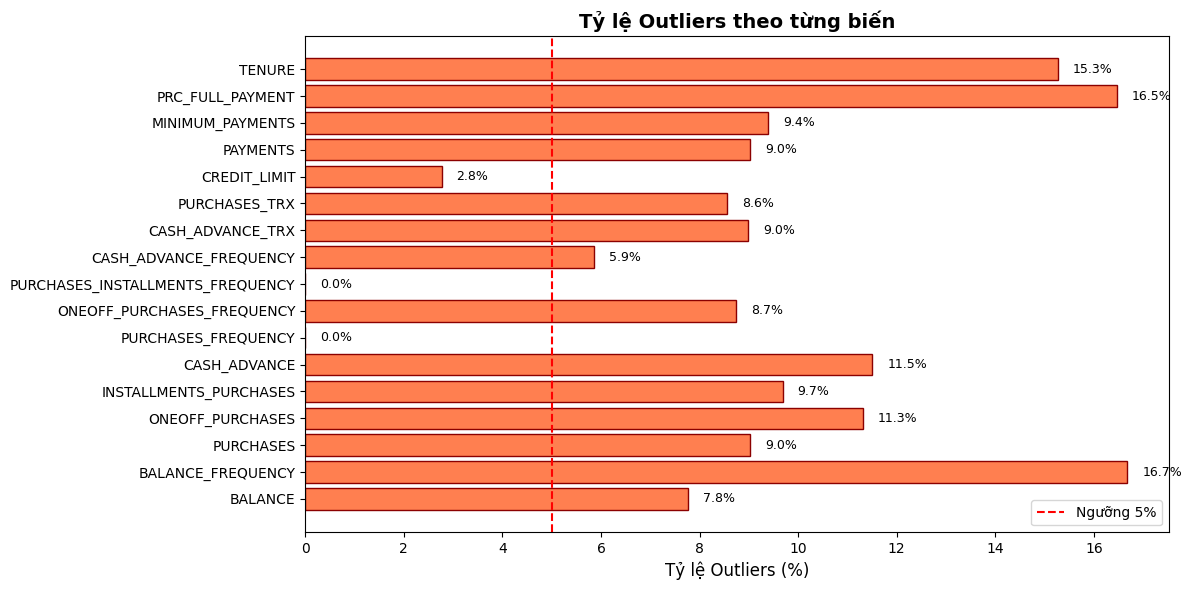

In [11]:
# Thống kê số lượng outliers theo phương pháp IQR
def count_outliers_iqr(df, column):
    """Đếm số outliers sử dụng phương pháp IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

print("Thống kê Outliers theo phương pháp IQR:")
print("=" * 80)
print(f"{'Biến':<35} {'Số outliers':>12} {'Tỷ lệ (%)':>12} {'Giới hạn dưới':>15} {'Giới hạn trên':>15}")
print("-" * 80)

outlier_summary = []
for col in numeric_cols:
    n_outliers, lower, upper = count_outliers_iqr(df, col)
    pct = (n_outliers / len(df)) * 100
    outlier_summary.append({
        'Biến': col,
        'Số outliers': n_outliers,
        'Tỷ lệ (%)': pct,
        'Giới hạn dưới': lower,
        'Giới hạn trên': upper
    })
    print(f"{col:<35} {n_outliers:>12,} {pct:>11.2f}% {lower:>15.2f} {upper:>15.2f}")

# Tạo biểu đồ tổng hợp outliers
outlier_df = pd.DataFrame(outlier_summary)
plt.figure(figsize=(12, 6))
bars = plt.barh(outlier_df['Biến'], outlier_df['Tỷ lệ (%)'], color='coral', edgecolor='darkred')
plt.xlabel('Tỷ lệ Outliers (%)', fontsize=12)
plt.title('Tỷ lệ Outliers theo từng biến', fontsize=14, fontweight='bold')
plt.axvline(x=5, color='red', linestyle='--', label='Ngưỡng 5%')
plt.legend()

# Thêm giá trị lên bars
for bar, val in zip(bars, outlier_df['Tỷ lệ (%)']):
    plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
             f'{val:.1f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

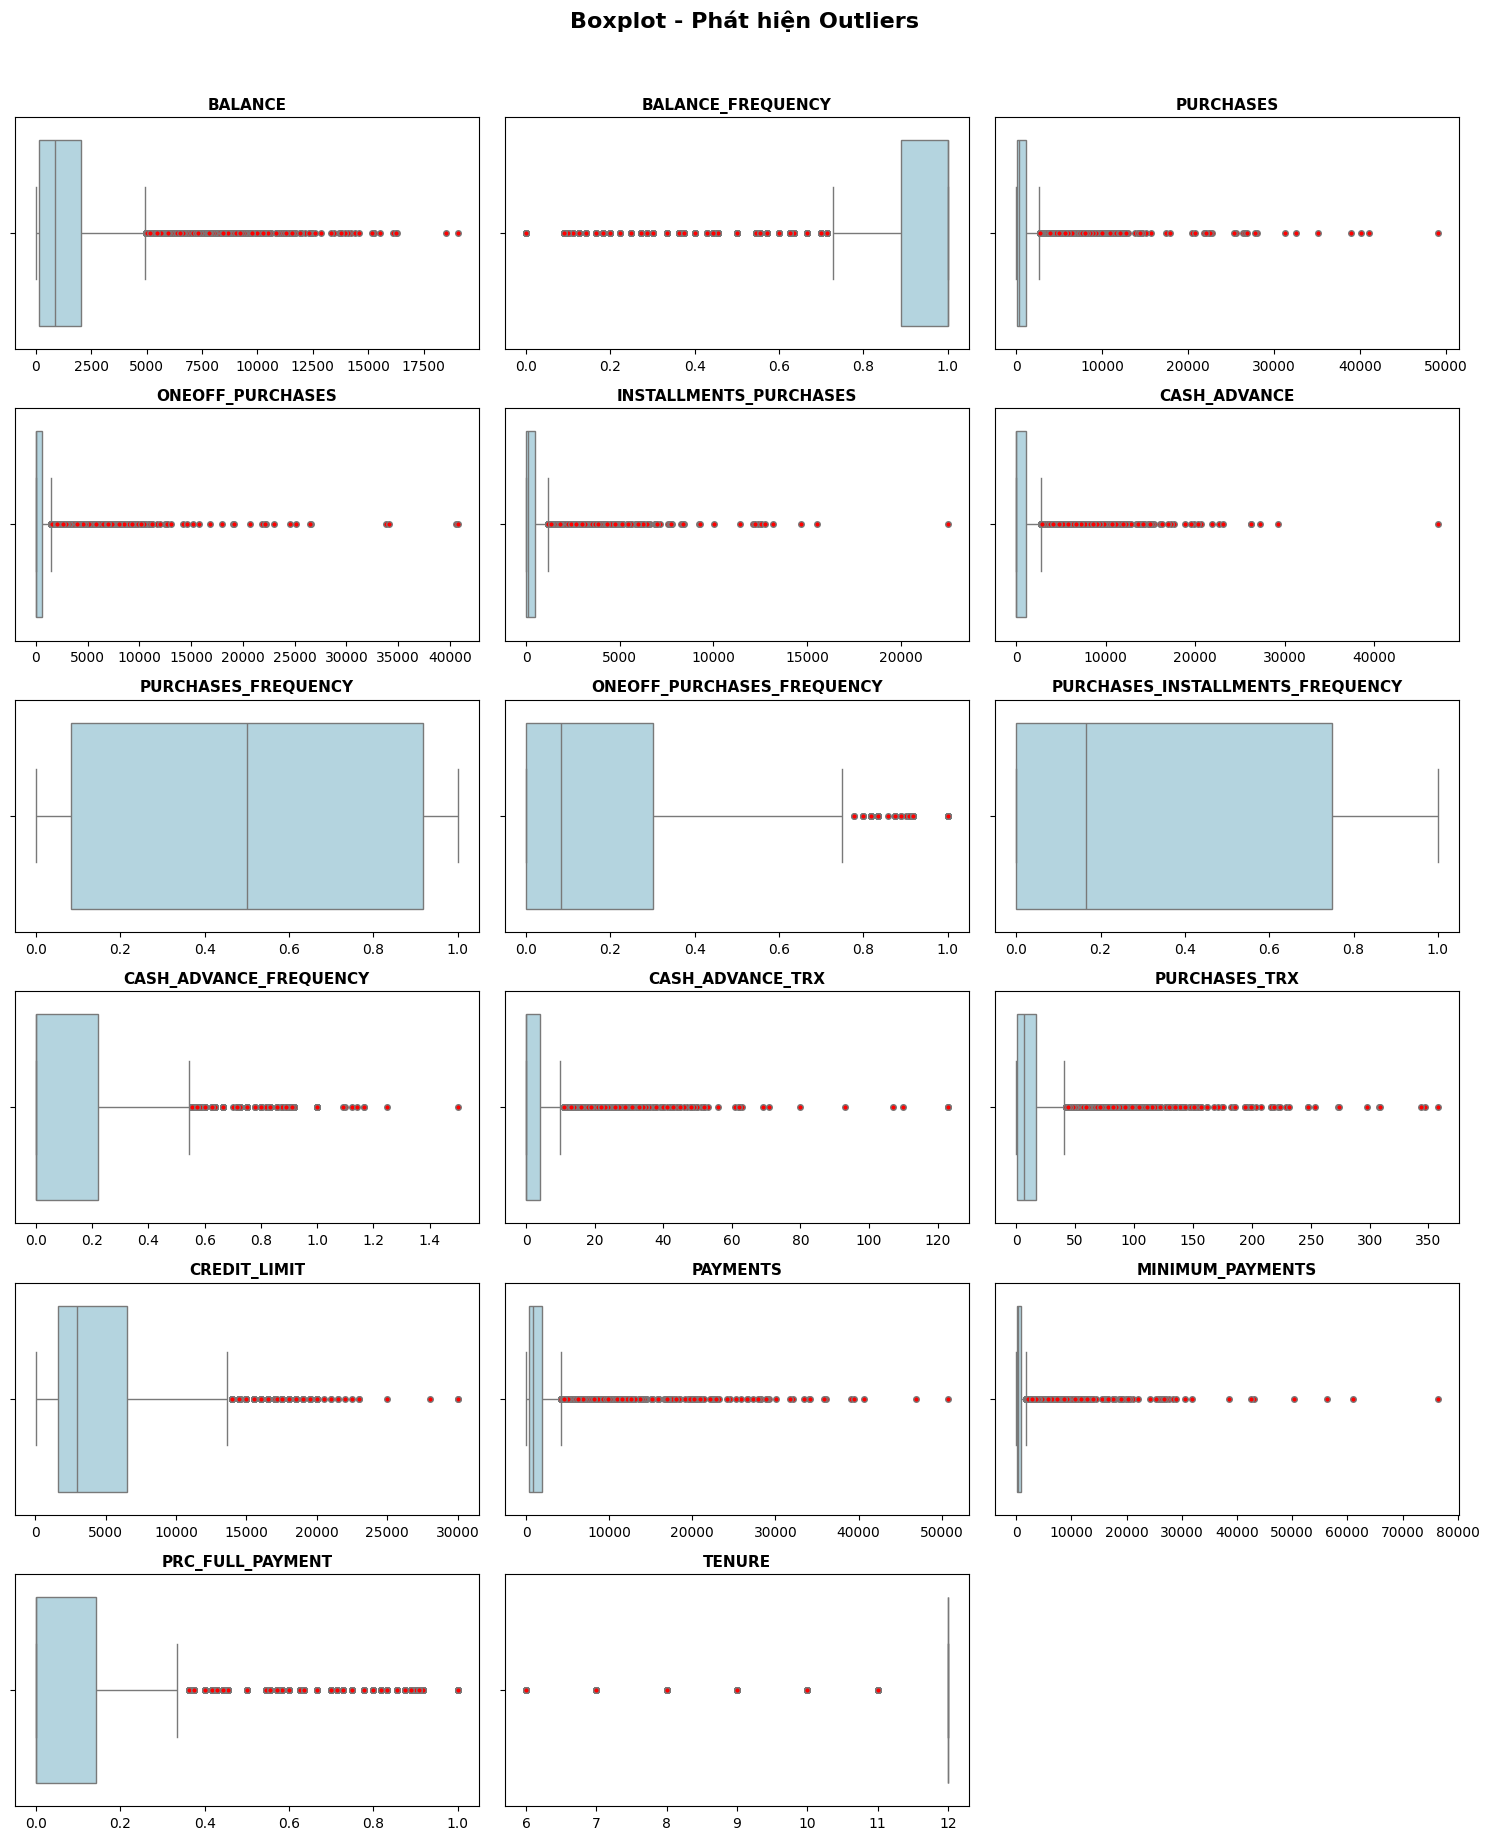

In [12]:
# Vẽ boxplot cho tất cả các biến số để phát hiện outliers
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    sns.boxplot(x=df[col], ax=ax, color='lightblue', flierprops=dict(markerfacecolor='red', marker='o', markersize=4))
    ax.set_title(f'{col}', fontsize=11, fontweight='bold')
    ax.set_xlabel('')

# Ẩn các subplot thừa
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Boxplot - Phát hiện Outliers', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### **1.5 Tong hop Insights tu EDA**

In [13]:
print("=" * 70)
print("TONG HOP INSIGHTS TU KHAM PHA DU LIEU (EDA)")
print("=" * 70)

print("""
[1] VE PHAN PHOI DU LIEU:
    - Tat ca bien AMOUNT lech phai MANH (skewness > 2)
      --> CAN log transform truoc khi clustering
    
    - Bien FREQUENCY co gia tri 0-1, nhieu gia tri cuc doan (0 hoac 1)
      --> CAN scale cung voi amount de dam bao cong bang

    - Nhieu bien co TY LE ZERO CAO (PURCHASES, CASH_ADVANCE, ...)
      --> Co nhieu NHOM KHACH HANG KHAC BIET

[2] VE OUTLIERS:
    - Cac bien amount co NHIEU outliers (10-25%)
    - Phuong phap IQR se loai qua nhieu du lieu
      --> NEN dung Winsorize (clip percentile) thay vi loai bo

[3] VE TUONG QUAN:
    - PURCHASES = ONEOFF_PURCHASES + INSTALLMENTS_PURCHASES (redundant)
      --> CAN loai bo 1 trong 3
    
    - PURCHASES <-> PURCHASES_TRX tuong quan rat cao (r > 0.8)
      --> CAN loai bo 1

    - Cac nhom bien tuong quan manh:
      + Nhom mua sam: PURCHASES, ONEOFF, INSTALLMENTS, PURCHASES_TRX
      + Nhom ung tien: CASH_ADVANCE, CASH_ADVANCE_TRX, CASH_ADVANCE_FREQUENCY
      --> Co the dung PCA de giam chieu

[4] VE NHOM KHACH HANG DAC BIET:
    - Nhom KHONG MUA SAM nhung CO UNG TIEN MAT
      --> Hanh vi rui ro, can theo doi

    - Nhom mua sam THUONG XUYEN (frequency = 1)
      --> Khach hang trung thanh

    - Nhom THANH TOAN DAY DU (PRC_FULL_PAYMENT = 1)
      --> Khach hang tot, it rui ro
""")

print("=" * 70)
print("KET THUC PHAN EDA - SAN SANG CHO TIEN XU LY")
print("=" * 70)

TONG HOP INSIGHTS TU KHAM PHA DU LIEU (EDA)

[1] VE PHAN PHOI DU LIEU:
    - Tat ca bien AMOUNT lech phai MANH (skewness > 2)
      --> CAN log transform truoc khi clustering

    - Bien FREQUENCY co gia tri 0-1, nhieu gia tri cuc doan (0 hoac 1)
      --> CAN scale cung voi amount de dam bao cong bang

    - Nhieu bien co TY LE ZERO CAO (PURCHASES, CASH_ADVANCE, ...)
      --> Co nhieu NHOM KHACH HANG KHAC BIET

[2] VE OUTLIERS:
    - Cac bien amount co NHIEU outliers (10-25%)
    - Phuong phap IQR se loai qua nhieu du lieu
      --> NEN dung Winsorize (clip percentile) thay vi loai bo

[3] VE TUONG QUAN:
    - PURCHASES = ONEOFF_PURCHASES + INSTALLMENTS_PURCHASES (redundant)
      --> CAN loai bo 1 trong 3

    - PURCHASES <-> PURCHASES_TRX tuong quan rat cao (r > 0.8)
      --> CAN loai bo 1

    - Cac nhom bien tuong quan manh:
      + Nhom mua sam: PURCHASES, ONEOFF, INSTALLMENTS, PURCHASES_TRX
      + Nhom ung tien: CASH_ADVANCE, CASH_ADVANCE_TRX, CASH_ADVANCE_FREQUENCY
      -->

## **2. TIỀN XỬ LÝ DỮ LIỆU**

### **Pipeline Tiền Xử Lý Dữ Liệu**


**Lý do cho từng bước:**

| Bước | Kỹ thuật | Lý do |
|------|----------|-------|
| **1. Drop ID** | Loại bỏ CUST_ID | Mã định danh không có ý nghĩa phân cụm, chỉ dùng để ánh xạ kết quả |
| **2. Missing Values** | KNNImputer (k=5) | Sử dụng thông tin từ 5 khách hàng tương tự, giữ được mối quan hệ giữa các biến |
| **3. Winsorize** | Clip percentile 1-99% | Giữ lại dữ liệu thay vì loại bỏ outliers, tránh mất thông tin |
| **4. Feature Engineering** | Tạo ratios + flags | Ratios mang ý nghĩa hơn giá trị tuyệt đối; Flags dùng cho profiling (không train) |
| **5. Log Transform** | Log1p cho biến lệch phải | Giảm skewness giúp K-Means hoạt động tốt hơn |
| **6. Feature Selection** | Loại biến redundant | Giảm nhiễu, ưu tiên ratios thay vì giá trị tuyệt đối (marketing-first) |
| **7. StandardScaler** | Mean=0, Std=1 | K-Means dựa trên Euclidean, các biến phải cùng scale |
| **8. PCA** | Giảm chiều 2D/3D | Trực quan hóa kết quả clustering |

### **2.1 Xử lý missing values**

In [14]:
# ============================================================================
# CHUẨN BỊ DỮ LIỆU - DROP ID VÀ TẠO BẢN SAO
# ============================================================================

# Tạo bản sao để xử lý (giữ nguyên df gốc)
df_processed = df.copy()

# Lưu CUST_ID để tham chiếu sau này nếu cần
customer_ids = df_processed['CUST_ID'].copy()

# Bỏ cột CUST_ID (định danh, không mang thông tin phân cụm)
ID_COL = 'CUST_ID'
df_processed = df_processed.drop(columns=[ID_COL])

print("=" * 60)
print("DROP CUST_ID")
print("=" * 60)
print(f"Da loai bo cot '{ID_COL}' - la ma dinh danh, khong co y nghia phan cum")
print(f"So cot con lai: {df_processed.shape[1]}")
print(f"Cac cot: {list(df_processed.columns)}")

DROP CUST_ID
Da loai bo cot 'CUST_ID' - la ma dinh danh, khong co y nghia phan cum
So cot con lai: 17
Cac cot: ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']


In [15]:
# ============================================================================
# XỬ LÝ MISSING VALUES VỚI KNNImputer
# ============================================================================

from sklearn.impute import KNNImputer

print("=" * 70)
print("XỬ LÝ MISSING VALUES (KNNImputer)")
print("=" * 70)

# Kiểm tra missing values trước khi xử lý
missing_before = df_processed.isnull().sum()
missing_cols = missing_before[missing_before > 0]

print("\nMissing values TRUOC xu ly:")
if len(missing_cols) > 0:
    for col, count in missing_cols.items():
        pct = (count / len(df_processed)) * 100
        print(f"   - {col}: {count} ({pct:.2f}%)")
else:
    print("   Khong co missing values")

# Phan tich moi tuong quan giua MINIMUM_PAYMENTS va BALANCE
print("\n" + "-" * 70)
print("PHAN TICH: MINIMUM_PAYMENTS phu thuoc vao BALANCE")
print("-" * 70)

# Tinh correlation giua cac bien (bo qua missing)
temp_df = df_processed[['BALANCE', 'MINIMUM_PAYMENTS', 'CREDIT_LIMIT', 'PAYMENTS']].dropna()
corr_with_min_pay = temp_df.corr()['MINIMUM_PAYMENTS'].drop('MINIMUM_PAYMENTS')
print("\nTuong quan voi MINIMUM_PAYMENTS:")
for col, corr in corr_with_min_pay.items():
    print(f"   - {col}: r = {corr:.4f}")

print("\nVAN DE: MINIMUM_PAYMENTS phu thuoc BALANCE (r > 0)")
print("    Dien Median chung se LAM MAT moi tuong quan nay!")
print("    --> Su dung KNNImputer de tim khach hang TUONG TU va dien gia tri")

# So sanh phuong phap: Median vs KNNImputer
print("\n" + "-" * 70)
print("SO SANH PHUONG PHAP IMPUTATION")
print("-" * 70)

# Luu gia tri goc de so sanh
df_test = df_processed.copy()
missing_idx = df_test['MINIMUM_PAYMENTS'].isnull()
n_missing = missing_idx.sum()

# Phuong phap 1: Median chung
median_value = df_test['MINIMUM_PAYMENTS'].median()
print(f"\n[1] MEDIAN CHUNG:")
print(f"    Gia tri dien: {median_value:,.2f} (cho tat ca {n_missing} missing)")
print(f"    Van de: Khong xet den BALANCE cua tung khach hang")

# Phuong phap 2: Median theo nhom BALANCE
print(f"\n[2] MEDIAN THEO NHOM BALANCE:")
df_test['BALANCE_GROUP'] = pd.qcut(df_test['BALANCE'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
median_by_group = df_test.groupby('BALANCE_GROUP')['MINIMUM_PAYMENTS'].median()
print("    Median theo nhom BALANCE:")
for group, val in median_by_group.items():
    print(f"       {group}: {val:,.2f}")
print("    Uu diem: Xet den moi tuong quan, de hieu")

# Phuong phap 3: KNNImputer
print(f"\n[3] KNNImputer (k=5):")
print("    Tim 5 khach hang TUONG TU NHAT (dua tren tat ca features)")
print("    Dien gia tri = Trung binh cua 5 neighbor")
print("    Uu diem: Tu dong xet den NHIEU features cung luc")
print("    --> DAY LA PHUONG PHAP DUOC CHON!")

# Thuc hien KNNImputer
print("\n" + "-" * 70)
print("THUC HIEN KNNImputer")
print("-" * 70)

# Chon cac features lien quan de KNN tim neighbor
impute_features = ['BALANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'PURCHASES', 
                   'CASH_ADVANCE', 'MINIMUM_PAYMENTS']
impute_features = [f for f in impute_features if f in df_processed.columns]

# Tao KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')

# Ap dung
df_impute = df_processed[impute_features].copy()
df_imputed = pd.DataFrame(
    knn_imputer.fit_transform(df_impute),
    columns=impute_features,
    index=df_processed.index
)

# Cap nhat lai MINIMUM_PAYMENTS
df_processed['MINIMUM_PAYMENTS'] = df_imputed['MINIMUM_PAYMENTS']

# Hien thi ket qua
print(f"Da dien {n_missing} gia tri missing bang KNNImputer (k=5)")
print(f"\nGia tri MINIMUM_PAYMENTS sau khi dien (cho cac dong truoc do missing):")
filled_values = df_processed.loc[missing_idx, 'MINIMUM_PAYMENTS']
print(f"   - Min:    {filled_values.min():>12,.2f}")
print(f"   - Max:    {filled_values.max():>12,.2f}")
print(f"   - Mean:   {filled_values.mean():>12,.2f}")
print(f"   - Median: {filled_values.median():>12,.2f}")

# So sanh voi Median chung
print(f"\nSo sanh:")
print(f"   - Median chung:        {median_value:>12,.2f}")
print(f"   - KNN mean filled:     {filled_values.mean():>12,.2f}")
print(f"   - KNN phu hop hon vi xet den BALANCE cua tung khach hang")

# Xu ly CREDIT_LIMIT (chi 1 missing)
if 'CREDIT_LIMIT' in df_processed.columns and df_processed['CREDIT_LIMIT'].isnull().any():
    median_credit = df_processed['CREDIT_LIMIT'].median()
    df_processed['CREDIT_LIMIT'] = df_processed['CREDIT_LIMIT'].fillna(median_credit)
    print(f"\nCREDIT_LIMIT: Dien bang MEDIAN = {median_credit:,.2f}")
    print(f"     (Chi 1 gia tri thieu, KNN khong can thiet)")

# Kiem tra ket qua cuoi cung
missing_after = df_processed.isnull().sum().sum()
print(f"\n" + "=" * 70)
print(f"Missing values SAU xu ly: {missing_after}")
print("HOAN THANH XU LY MISSING VALUES VOI KNNImputer!")
print("=" * 70)

# Cleanup
df_test.drop('BALANCE_GROUP', axis=1, inplace=True, errors='ignore')

XỬ LÝ MISSING VALUES (KNNImputer)

Missing values TRUOC xu ly:
   - CREDIT_LIMIT: 1 (0.01%)
   - MINIMUM_PAYMENTS: 313 (3.50%)

----------------------------------------------------------------------
PHAN TICH: MINIMUM_PAYMENTS phu thuoc vao BALANCE
----------------------------------------------------------------------

Tuong quan voi MINIMUM_PAYMENTS:
   - BALANCE: r = 0.3987
   - CREDIT_LIMIT: r = 0.1267
   - PAYMENTS: r = 0.1266

VAN DE: MINIMUM_PAYMENTS phu thuoc BALANCE (r > 0)
    Dien Median chung se LAM MAT moi tuong quan nay!
    --> Su dung KNNImputer de tim khach hang TUONG TU va dien gia tri

----------------------------------------------------------------------
SO SANH PHUONG PHAP IMPUTATION
----------------------------------------------------------------------

[1] MEDIAN CHUNG:
    Gia tri dien: 312.34 (cho tat ca 313 missing)
    Van de: Khong xet den BALANCE cua tung khach hang

[2] MEDIAN THEO NHOM BALANCE:
    Median theo nhom BALANCE:
       Very Low: 122.20
       L

### **2.2 Xử lý outliers (Winsorize)**

> Mục tiêu: clip theo percentile để giảm ảnh hưởng giá trị cực đoan.
> Bước này cần chạy **trước** khi tạo các biến tỷ lệ (ratios) để ratios phản ánh dữ liệu đã được winsorize.

In [16]:
# ============================================================================
# XỬ LÝ OUTLIERS - WINSORIZE (Clip theo percentile 1%-99%)
# ============================================================================

print("=" * 60)
print("XỬ LÝ OUTLIERS - WINSORIZE")
print("=" * 60)
print("\nPhuong phap: Clip (Winsorize) theo percentile 1% - 99%")
print("   Giu lai tat ca observations, chi dieu chinh gia tri cuc doan")
print("   Phu hop hon IQR cho du lieu lech phai (skewed)")

# Định nghĩa các cột cần winsorize (các biến "amount" có nhiều outliers)
cols_to_winsorize = [
    'BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
    'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS'
]

# Thực hiện winsorize
winsorize_summary = []
for col in cols_to_winsorize:
    if col in df_processed.columns:
        # Lưu giá trị trước khi xử lý
        before_min, before_max = df_processed[col].min(), df_processed[col].max()

        # Tính percentile 1% và 99%
        p1 = df_processed[col].quantile(0.01)
        p99 = df_processed[col].quantile(0.99)

        # Clip giá trị
        df_processed[col] = df_processed[col].clip(lower=p1, upper=p99)

        # Lưu summary
        after_min, after_max = df_processed[col].min(), df_processed[col].max()
        winsorize_summary.append({
            'Biến': col,
            'Min trước': before_min,
            'Min sau': after_min,
            'Max trước': before_max,
            'Max sau': after_max,
            'P1': p1,
            'P99': p99
        })

# Hien thi ket qua
winsorize_df = pd.DataFrame(winsorize_summary)
print("\nKet qua Winsorize (Clip 1%-99%):")
print("-" * 100)
for _, row in winsorize_df.iterrows():
    print(f"\n{row['Biến']}:")
    print(f"   Range truoc: [{row['Min trước']:>12,.2f} - {row['Max trước']:>12,.2f}]")
    print(f"   Range sau:   [{row['Min sau']:>12,.2f} - {row['Max sau']:>12,.2f}]")
    print(f"   Clip bounds: [{row['P1']:>12,.2f} - {row['P99']:>12,.2f}]")

print("\nHoan thanh xu ly outliers voi Winsorize!\n")

XỬ LÝ OUTLIERS - WINSORIZE

Phuong phap: Clip (Winsorize) theo percentile 1% - 99%
   Giu lai tat ca observations, chi dieu chinh gia tri cuc doan
   Phu hop hon IQR cho du lieu lech phai (skewed)

Ket qua Winsorize (Clip 1%-99%):
----------------------------------------------------------------------------------------------------

BALANCE:
   Range truoc: [        0.00 -    19,043.14]
   Range sau:   [        0.07 -     9,338.80]
   Clip bounds: [        0.07 -     9,338.80]

PURCHASES:
   Range truoc: [        0.00 -    49,039.57]
   Range sau:   [        0.00 -     8,977.29]
   Clip bounds: [        0.00 -     8,977.29]

ONEOFF_PURCHASES:
   Range truoc: [        0.00 -    40,761.25]
   Range sau:   [        0.00 -     6,689.90]
   Clip bounds: [        0.00 -     6,689.90]

INSTALLMENTS_PURCHASES:
   Range truoc: [        0.00 -    22,500.00]
   Range sau:   [        0.00 -     3,886.24]
   Clip bounds: [        0.00 -     3,886.24]

CASH_ADVANCE:
   Range truoc: [        0.00 -    

### **2.3 Feature Engineering - Tạo biến mới**

**Tại sao cần tạo biến mới?**
- Dữ liệu thô đôi khi không phản ánh hết hành vi khách hàng
- Trong bài toán tín dụng, các **tỷ lệ (Ratios)** thường mang nhiều ý nghĩa phân loại hơn giá trị tuyệt đối
- Ví dụ: Khách hàng A có số dư 10 triệu với hạn mức 100 triệu (10%) khác hoàn toàn với khách B có số dư 10 triệu với hạn mức 11 triệu (90%)

**Các biến sẽ tạo mới:**

| Biến Mới | Công Thức | Ý Nghĩa |
|----------|-----------|---------|
| `CREDIT_UTILIZATION` | BALANCE / CREDIT_LIMIT | Tỷ lệ sử dụng hạn mức - Cao = rủi ro cao |
| `PAYMENT_RATIO` | PAYMENTS / MINIMUM_PAYMENTS | Tỷ lệ thanh toán - Thấp = chỉ trả tối thiểu |
| `CASH_RATIO` | CASH_ADVANCE / CREDIT_LIMIT | Tỷ lệ rút tiền mặt - Cao = rủi ro cao |
| `PURCHASE_PER_TRX` | PURCHASES / PURCHASES_TRX | Giá trị trung bình mỗi giao dịch mua hàng |
| `BALANCE_GROWTH_RATE` | (PURCHASES + CASH_ADVANCE - PAYMENTS) / BALANCE | Tốc độ tích lũy nợ - Cao = rủi ro cao |

In [17]:
# Lưu số cột ban đầu để so sánh sau
n_cols_before = df_processed.shape[1]
print(f"[INFO] Số cột ban đầu: {n_cols_before}")

[INFO] Số cột ban đầu: 17


#### **2.3.1 CREDIT_UTILIZATION - Tỷ lệ sử dụng hạn mức**

**Công thức:** `CREDIT_UTILIZATION = BALANCE / CREDIT_LIMIT`

**Ý nghĩa:** Khách hàng dùng 90% hạn mức rất khác với khách dùng 10%. Tỷ lệ cao cho thấy rủi ro cao.

In [18]:
df_processed['CREDIT_UTILIZATION'] = np.where(
    df_processed['CREDIT_LIMIT'] > 0,
    df_processed['BALANCE'] / df_processed['CREDIT_LIMIT'],
    0
)

df_processed['CREDIT_UTILIZATION'] = df_processed['CREDIT_UTILIZATION'].clip(lower=0, upper=1.5)

print("Đã tạo CREDIT_UTILIZATION")
print(f"Range: [{df_processed['CREDIT_UTILIZATION'].min():.4f}, {df_processed['CREDIT_UTILIZATION'].max():.4f}]")
print(f"Mean: {df_processed['CREDIT_UTILIZATION'].mean():.4f} | Median: {df_processed['CREDIT_UTILIZATION'].median():.4f}")

Đã tạo CREDIT_UTILIZATION
Range: [0.0000, 1.5000]
Mean: 0.3851 | Median: 0.3020


#### **2.3.2 PAYMENT_RATIO - Tỷ lệ thanh toán**

**Công thức:** `PAYMENT_RATIO = PAYMENTS / MINIMUM_PAYMENTS`

**Ý nghĩa:** Phân biệt nhóm chỉ trả tối thiểu vs nhóm trả hết nợ. Tỷ lệ thấp cho thấy khách hàng chỉ trả tối thiểu.

In [19]:
df_processed['PAYMENT_RATIO'] = np.where(
    df_processed['MINIMUM_PAYMENTS'] > 0,
    df_processed['PAYMENTS'] / df_processed['MINIMUM_PAYMENTS'],
    np.where(df_processed['PAYMENTS'] > 0, 5, 0)
)

df_processed['PAYMENT_RATIO'] = df_processed['PAYMENT_RATIO'].clip(lower=0, upper=10)

pct_at_max = (df_processed['PAYMENT_RATIO'] == 10).sum() / len(df_processed) * 100

print("Đã tạo PAYMENT_RATIO")
print(f"Range: [{df_processed['PAYMENT_RATIO'].min():.4f}, {df_processed['PAYMENT_RATIO'].max():.4f}]")
print(f"Mean: {df_processed['PAYMENT_RATIO'].mean():.4f} | Median: {df_processed['PAYMENT_RATIO'].median():.4f}")
print(f"% tại giá trị max (=10): {pct_at_max:.1f}%")

Đã tạo PAYMENT_RATIO
Range: [0.0000, 10.0000]
Mean: 3.6585 | Median: 2.0445
% tại giá trị max (=10): 14.3%


#### **2.3.3 CASH_RATIO - Tỷ lệ rút tiền mặt**

**Công thức:** `CASH_RATIO = CASH_ADVANCE / CREDIT_LIMIT`

**Ý nghĩa:** Phát hiện nhóm chuyên rút tiền mặt - đây thường là nhóm rủi ro cao trong tín dụng.

In [20]:
df_processed['CASH_RATIO'] = np.where(
    df_processed['CREDIT_LIMIT'] > 0,
    df_processed['CASH_ADVANCE'] / df_processed['CREDIT_LIMIT'],
    0
)

df_processed['CASH_RATIO'] = df_processed['CASH_RATIO'].clip(lower=0, upper=1.5)

print("Đã tạo CASH_RATIO")
print(f"Range: [{df_processed['CASH_RATIO'].min():.4f}, {df_processed['CASH_RATIO'].max():.4f}]")
print(f"Mean: {df_processed['CASH_RATIO'].mean():.4f} | Median: {df_processed['CASH_RATIO'].median():.4f}")

Đã tạo CASH_RATIO
Range: [0.0000, 1.5000]
Mean: 0.2253 | Median: 0.0000


#### **2.3.4 PURCHASE_PER_TRX - Giá trị trung bình mỗi giao dịch**

**Công thức:** `PURCHASE_PER_TRX = PURCHASES / PURCHASES_TRX`

**Ý nghĩa:** Phân biệt khách hàng mua ít nhưng giá trị cao vs khách hàng mua nhiều nhưng giá trị thấp.

In [21]:
df_processed['PURCHASE_PER_TRX'] = np.where(
    df_processed['PURCHASES_TRX'] > 0,
    df_processed['PURCHASES'] / df_processed['PURCHASES_TRX'],
    0
)

p99_purchase_per_trx = df_processed['PURCHASE_PER_TRX'].quantile(0.99)
df_processed['PURCHASE_PER_TRX'] = df_processed['PURCHASE_PER_TRX'].clip(lower=0, upper=p99_purchase_per_trx)

print("Đã tạo PURCHASE_PER_TRX")
print(f"Range: [{df_processed['PURCHASE_PER_TRX'].min():.4f}, {df_processed['PURCHASE_PER_TRX'].max():.4f}]")
print(f"Mean: {df_processed['PURCHASE_PER_TRX'].mean():.4f} | Median: {df_processed['PURCHASE_PER_TRX'].median():.4f}")
print(f"P99 clip value: {p99_purchase_per_trx:.2f}")

Đã tạo PURCHASE_PER_TRX
Range: [0.0000, 748.1075]
Mean: 68.0199 | Median: 41.3351
P99 clip value: 748.11


#### **2.3.5 BALANCE_GROWTH_RATE - Tốc độ tích lũy nợ**

**Công thức:** `BALANCE_GROWTH_RATE = (PURCHASES + CASH_ADVANCE - PAYMENTS) / BALANCE`

**Ý nghĩa:** Phát hiện khách hàng đang tích lũy nợ nhanh (giá trị dương cao = rủi ro cao).

In [22]:
df_processed['BALANCE_GROWTH_RATE'] = 0.0

mask_valid = df_processed['BALANCE'] > 0
df_processed.loc[mask_valid, 'BALANCE_GROWTH_RATE'] = (
    (df_processed.loc[mask_valid, 'PURCHASES'] + 
     df_processed.loc[mask_valid, 'CASH_ADVANCE'] - 
     df_processed.loc[mask_valid, 'PAYMENTS']) / 
    df_processed.loc[mask_valid, 'BALANCE']
)

df_processed['BALANCE_GROWTH_RATE'] = df_processed['BALANCE_GROWTH_RATE'].clip(lower=-2, upper=2)

pct_positive = (df_processed['BALANCE_GROWTH_RATE'] > 0).sum() / len(df_processed) * 100
pct_negative = (df_processed['BALANCE_GROWTH_RATE'] < 0).sum() / len(df_processed) * 100

print("Đã tạo BALANCE_GROWTH_RATE")
print(f"Range: [{df_processed['BALANCE_GROWTH_RATE'].min():.4f}, {df_processed['BALANCE_GROWTH_RATE'].max():.4f}]")
print(f"Mean: {df_processed['BALANCE_GROWTH_RATE'].mean():.4f} | Median: {df_processed['BALANCE_GROWTH_RATE'].median():.4f}")
print(f"% tăng nợ (>0): {pct_positive:.1f}% | % giảm nợ (<0): {pct_negative:.1f}%")

Đã tạo BALANCE_GROWTH_RATE
Range: [-2.0000, 2.0000]
Mean: 0.0316 | Median: 0.0698
% tăng nợ (>0): 52.7% | % giảm nợ (<0): 47.3%


#### **2.3.6 Kiểm tra phân phối các biến mới**

Sau khi tạo các biến mới, cần kiểm tra phân phối để đảm bảo chúng không có extreme values và phù hợp cho clustering.

In [23]:
print("=" * 70)
print("KIỂM TRA PHÂN PHỐI CÁC BIẾN MỚI:")
print("=" * 70)

new_features = ['CREDIT_UTILIZATION', 'PAYMENT_RATIO', 'CASH_RATIO', 
                'PURCHASE_PER_TRX', 'BALANCE_GROWTH_RATE']

for feat in new_features:
    q01 = df_processed[feat].quantile(0.01)
    q99 = df_processed[feat].quantile(0.99)
    skew = df_processed[feat].skew()
    print(f"\n{feat}:")
    print(f"   P1={q01:.3f} | P99={q99:.3f} | Skew={skew:.2f}")

n_cols_after = df_processed.shape[1]
print("\n" + "=" * 70)
print(f"Đã tạo {n_cols_after - n_cols_before} biến mới!")
print("=" * 70)
print(f"\nCác biến mới đã được CLIP để tránh extreme values:")
print("   1. CREDIT_UTILIZATION  - Clip [0, 1.5]")
print("   2. PAYMENT_RATIO       - Clip [0, 10]")  
print("   3. CASH_RATIO          - Clip [0, 1.5]")
print("   4. PURCHASE_PER_TRX    - Clip [0, P99]")
print("   5. BALANCE_GROWTH_RATE - Clip [-2, 2]")

print("\n" + "-" * 70)
print("THỐNG KÊ CÁC BIẾN MỚI:")
print("-" * 70)
display(df_processed[new_features].describe().round(4))

KIỂM TRA PHÂN PHỐI CÁC BIẾN MỚI:

CREDIT_UTILIZATION:
   P1=0.000 | P99=1.053 | Skew=0.48

PAYMENT_RATIO:
   P1=0.000 | P99=10.000 | Skew=0.85

CASH_RATIO:
   P1=0.000 | P99=1.500 | Skew=1.68

PURCHASE_PER_TRX:
   P1=0.000 | P99=748.108 | Skew=4.06

BALANCE_GROWTH_RATE:
   P1=-2.000 | P99=2.000 | Skew=-0.20

Đã tạo 5 biến mới!

Các biến mới đã được CLIP để tránh extreme values:
   1. CREDIT_UTILIZATION  - Clip [0, 1.5]
   2. PAYMENT_RATIO       - Clip [0, 10]
   3. CASH_RATIO          - Clip [0, 1.5]
   4. PURCHASE_PER_TRX    - Clip [0, P99]
   5. BALANCE_GROWTH_RATE - Clip [-2, 2]

----------------------------------------------------------------------
THỐNG KÊ CÁC BIẾN MỚI:
----------------------------------------------------------------------


CREDIT_UTILIZATION  PAYMENT_RATIO  CASH_RATIO  PURCHASE_PER_TRX  \
count           8950.0000      8950.0000   8950.0000         8950.0000   
mean               0.3851         3.6585      0.2253           68.0199   
std                0.3511         3.4418      0.3536          106.4874   
min                0.0000         0.0000      0.0000            0.0000   
25%                0.0415         0.9180      0.0000           11.9834   
50%                0.3020         2.0445      0.0000           41.3351   
75%                0.7082         6.0271      0.3518           78.2125   
max                1.5000        10.0000      1.5000          748.1075   

       BALANCE_GROWTH_RATE  
count            8950.0000  
mean                0.0316  
std                 1.2149  
min                -2.0000  
25%                -0.5833  
50%                 0.0698  
75%                 0.8647  
max                 2.0000

In [24]:
# ============================================================================
# MARKETING FEATURES (Flags + Mix Ratios)
# - Tang do actionability cho segmentation
# - Luu y: cell nay can chay TRUOC Log1p để các tỷ trọng theo thang tiền gốc
# ============================================================================
# QUAN TRỌNG: 
#   - Các FLAG (binary 0/1) sẽ được LƯU RIÊNG trong df_profiling_flags
#   - KHÔNG đưa FLAG vào training K-Means (tránh circular reasoning)
#   - FLAG chỉ dùng để profiling/đặt tên cụm SAU khi cluster xong
# ============================================================================

EPS = 1e-9

# Tạo DataFrame riêng để lưu các FLAG cho profiling sau
df_profiling_flags = pd.DataFrame(index=df_processed.index)

# ============================================================================
# 1. CÁC FLAG (BINARY) - CHỈ DÙNG CHO PROFILING, KHÔNG TRAIN
# ============================================================================

# HAS_PURCHASE: Có mua sắm hay không
if 'ONEOFF_PURCHASES' in df_processed.columns and 'INSTALLMENTS_PURCHASES' in df_processed.columns:
    df_profiling_flags['HAS_PURCHASE'] = ((df_processed['ONEOFF_PURCHASES'] + df_processed['INSTALLMENTS_PURCHASES']) > 0).astype(int)
else:
    df_profiling_flags['HAS_PURCHASE'] = 0

# HAS_CASH_ADV: Có rút tiền mặt hay không
if 'CASH_ADVANCE_FREQUENCY' in df_processed.columns:
    df_profiling_flags['HAS_CASH_ADV'] = (df_processed['CASH_ADVANCE_FREQUENCY'] > 0).astype(int)
else:
    df_profiling_flags['HAS_CASH_ADV'] = 0

# FULL_PAYER_FLAG: Khách hàng trả hết nợ >= 80% thời gian
if 'PRC_FULL_PAYMENT' in df_processed.columns:
    df_profiling_flags['FULL_PAYER_FLAG'] = (df_processed['PRC_FULL_PAYMENT'] >= 0.8).astype(int)
else:
    df_profiling_flags['FULL_PAYER_FLAG'] = 0

# HIGH_UTIL_FLAG: Sử dụng >= 70% hạn mức
if 'CREDIT_UTILIZATION' in df_processed.columns:
    df_profiling_flags['HIGH_UTIL_FLAG'] = (df_processed['CREDIT_UTILIZATION'] >= 0.7).astype(int)
else:
    df_profiling_flags['HIGH_UTIL_FLAG'] = 0

# CASH_HEAVY_FLAG: Rút tiền mặt >= 30% hạn mức
if 'CASH_RATIO' in df_processed.columns:
    df_profiling_flags['CASH_HEAVY_FLAG'] = (df_processed['CASH_RATIO'] >= 0.3).astype(int)
else:
    df_profiling_flags['CASH_HEAVY_FLAG'] = 0

# ============================================================================
# 2. INSTALLMENT_SHARE (RATIO LIÊN TỤC) - ĐƯA VÀO TRAINING
# ============================================================================
# INSTALLMENT_SHARE là ratio liên tục [0,1], KHÔNG phải binary flag
# Nên được giữ lại để training vì phản ánh hành vi thực sự

if 'ONEOFF_PURCHASES' in df_processed.columns and 'INSTALLMENTS_PURCHASES' in df_processed.columns:
    denom = df_processed['ONEOFF_PURCHASES'] + df_processed['INSTALLMENTS_PURCHASES'] + EPS
    df_processed['INSTALLMENT_SHARE'] = (df_processed['INSTALLMENTS_PURCHASES'] / denom).clip(0, 1)
else:
    df_processed['INSTALLMENT_SHARE'] = 0.0

# ============================================================================
# SUMMARY
# ============================================================================
print("=" * 70)
print("MARKETING FEATURES - PHÂN TÁCH TRAINING vs PROFILING")
print("=" * 70)

print("\n[1] CÁC FLAG (binary) - CHỈ DÙNG CHO PROFILING (không train):")
print("    Lưu trong: df_profiling_flags")
print("    Các biến:", list(df_profiling_flags.columns))
display(df_profiling_flags.describe().T.round(4))

print("\n[2] RATIO LIÊN TỤC - ĐƯA VÀO TRAINING:")
print("    Lưu trong: df_processed")
print("    INSTALLMENT_SHARE: Tỷ trọng mua trả góp (liên tục 0-1)")
print(f"    Mean: {df_processed['INSTALLMENT_SHARE'].mean():.4f} | Median: {df_processed['INSTALLMENT_SHARE'].median():.4f}")

print("\n" + "=" * 70)
print("LÝ DO KHÔNG DÙNG FLAG ĐỂ TRAIN:")
print("=" * 70)
print("  - FLAG được tạo từ ngưỡng thủ công (VD: PRC_FULL_PAYMENT >= 0.8)")
print("  - Dùng FLAG để cluster sẽ gây 'circular reasoning' (bias)")
print("  - K-Means nên học từ hành vi liên tục, không phải nhãn đã gán sẵn")
print("  - FLAG sẽ dùng để ĐẶT TÊN cụm và THIẾT KẾ chiến dịch sau khi cluster")
print("=" * 70)

MARKETING FEATURES - PHÂN TÁCH TRAINING vs PROFILING

[1] CÁC FLAG (binary) - CHỈ DÙNG CHO PROFILING (không train):
    Lưu trong: df_profiling_flags
    Các biến: ['HAS_PURCHASE', 'HAS_CASH_ADV', 'FULL_PAYER_FLAG', 'HIGH_UTIL_FLAG', 'CASH_HEAVY_FLAG']


count    mean     std  min  25%  50%  75%  max
HAS_PURCHASE     8950.0  0.7718  0.4197  0.0  1.0  1.0  1.0  1.0
HAS_CASH_ADV     8950.0  0.4829  0.4997  0.0  0.0  0.0  1.0  1.0
FULL_PAYER_FLAG  8950.0  0.0844  0.2779  0.0  0.0  0.0  0.0  1.0
HIGH_UTIL_FLAG   8950.0  0.2540  0.4353  0.0  0.0  0.0  1.0  1.0
CASH_HEAVY_FLAG  8950.0  0.2744  0.4462  0.0  0.0  0.0  1.0  1.0


[2] RATIO LIÊN TỤC - ĐƯA VÀO TRAINING:
    Lưu trong: df_processed
    INSTALLMENT_SHARE: Tỷ trọng mua trả góp (liên tục 0-1)
    Mean: 0.3922 | Median: 0.1870

LÝ DO KHÔNG DÙNG FLAG ĐỂ TRAIN:
  - FLAG được tạo từ ngưỡng thủ công (VD: PRC_FULL_PAYMENT >= 0.8)
  - Dùng FLAG để cluster sẽ gây 'circular reasoning' (bias)
  - K-Means nên học từ hành vi liên tục, không phải nhãn đã gán sẵn
  - FLAG sẽ dùng để ĐẶT TÊN cụm và THIẾT KẾ chiến dịch sau khi cluster


### **2.4 Giảm Skewness (Log Transform)**

In [25]:
# ============================================================================
# GIẢM SKEWNESS - LOG1P TRANSFORM
# ============================================================================

print("=" * 60)
print("GIẢM SKEWNESS - LOG1P TRANSFORM")
print("=" * 60)
print("\nPhuong phap: log1p(x) = log(1 + x)")
print("   Xu ly duoc gia tri 0 (khong bi -inf nhu log(0))")
print("   Giam skewness cho cac bien lech phai")
print("   Giup K-Means hoat dong tot hon (thuat toan nhay voi scale)")

# Cac bien "amount" co skewness cao can transform
cols_to_log = [
    'BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
    'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS'
]

# So sanh skewness truoc va sau transform
print("\nSo sanh Skewness truoc va sau Log1p Transform:")
print("-" * 70)
print(f"{'Biến':<30} {'Skew Trước':>15} {'Skew Sau':>15} {'Giảm (%)':>10}")
print("-" * 70)

skewness_comparison = []
for col in cols_to_log:
    if col in df_processed.columns:
        skew_before = df_processed[col].skew()
        
        # Apply log1p transform
        df_processed[col] = np.log1p(df_processed[col])
        
        skew_after = df_processed[col].skew()
        reduction = ((abs(skew_before) - abs(skew_after)) / abs(skew_before)) * 100 if skew_before != 0 else 0
        
        skewness_comparison.append({
            'Biến': col,
            'Skew Trước': skew_before,
            'Skew Sau': skew_after,
            'Giảm (%)': reduction
        })
        
        print(f"{col:<30} {skew_before:>15.3f} {skew_after:>15.3f} {reduction:>9.1f}%")

print("-" * 70)
print("\nHoan thanh Log1p Transform!")
print("  Cac bien da duoc transform de giam skewness")
print("  Phan phoi gan doi xung hon, phu hop cho K-Means")

GIẢM SKEWNESS - LOG1P TRANSFORM

Phuong phap: log1p(x) = log(1 + x)
   Xu ly duoc gia tri 0 (khong bi -inf nhu log(0))
   Giam skewness cho cac bien lech phai
   Giup K-Means hoat dong tot hon (thuat toan nhay voi scale)

So sanh Skewness truoc va sau Log1p Transform:
----------------------------------------------------------------------
Biến                                Skew Trước        Skew Sau   Giảm (%)
----------------------------------------------------------------------
BALANCE                                  1.932          -0.865      55.3%
PURCHASES                                2.992          -0.777      74.0%
ONEOFF_PURCHASES                         3.351           0.176      94.7%
INSTALLMENTS_PURCHASES                   2.874          -0.034      98.8%
CASH_ADVANCE                             2.724           0.259      90.5%
CREDIT_LIMIT                             1.332          -0.057      95.7%
PAYMENTS                                 3.005          -1.833      39.

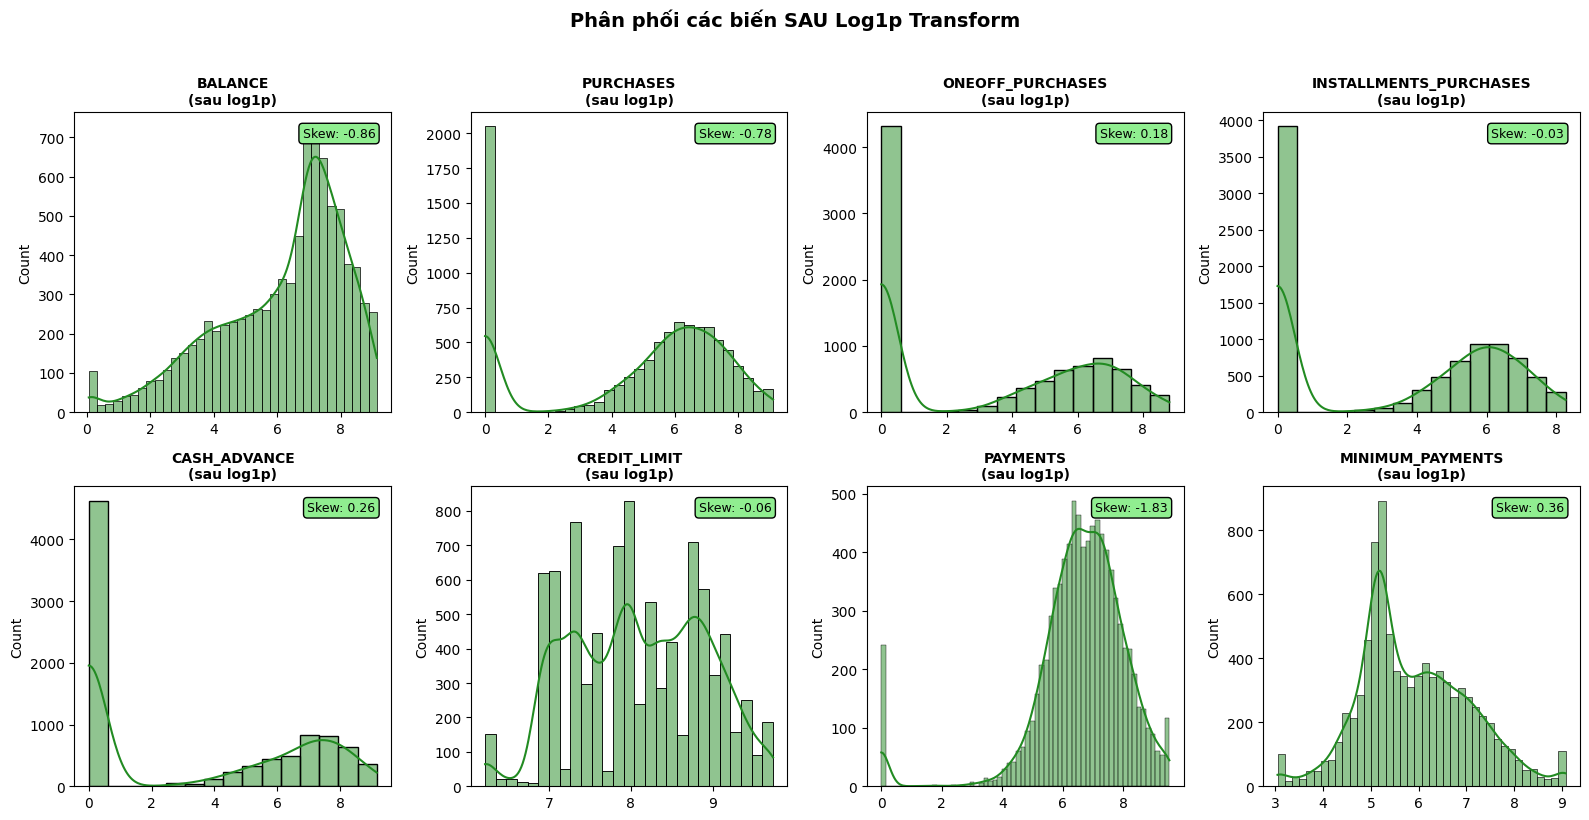

In [26]:
# Visualize phân phối SAU log transform
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, col in enumerate(cols_to_log):
    if col in df_processed.columns and idx < len(axes):
        ax = axes[idx]
        sns.histplot(df_processed[col], kde=True, ax=ax, color='forestgreen', edgecolor='black')
        ax.set_title(f'{col}\n(sau log1p)', fontsize=10, fontweight='bold')
        ax.set_xlabel('')
        
        # Thêm skewness
        skew_val = df_processed[col].skew()
        ax.text(0.95, 0.95, f'Skew: {skew_val:.2f}', transform=ax.transAxes,
                ha='right', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='lightgreen'))

plt.suptitle('Phân phối các biến SAU Log1p Transform', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### **2.5 Feature Selection - Xử lý đa cộng tuyến**

FEATURE SELECTION - XỬ LÝ ĐA CỘNG TUYẾN

Phan tich tuong quan cao (|r| > 0.85):
------------------------------------------------------------


Feature 1                         Feature 2  Correlation
0  INSTALLMENTS_PURCHASES  PURCHASES_INSTALLMENTS_FREQUENCY     0.878963
1     PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY     0.862934

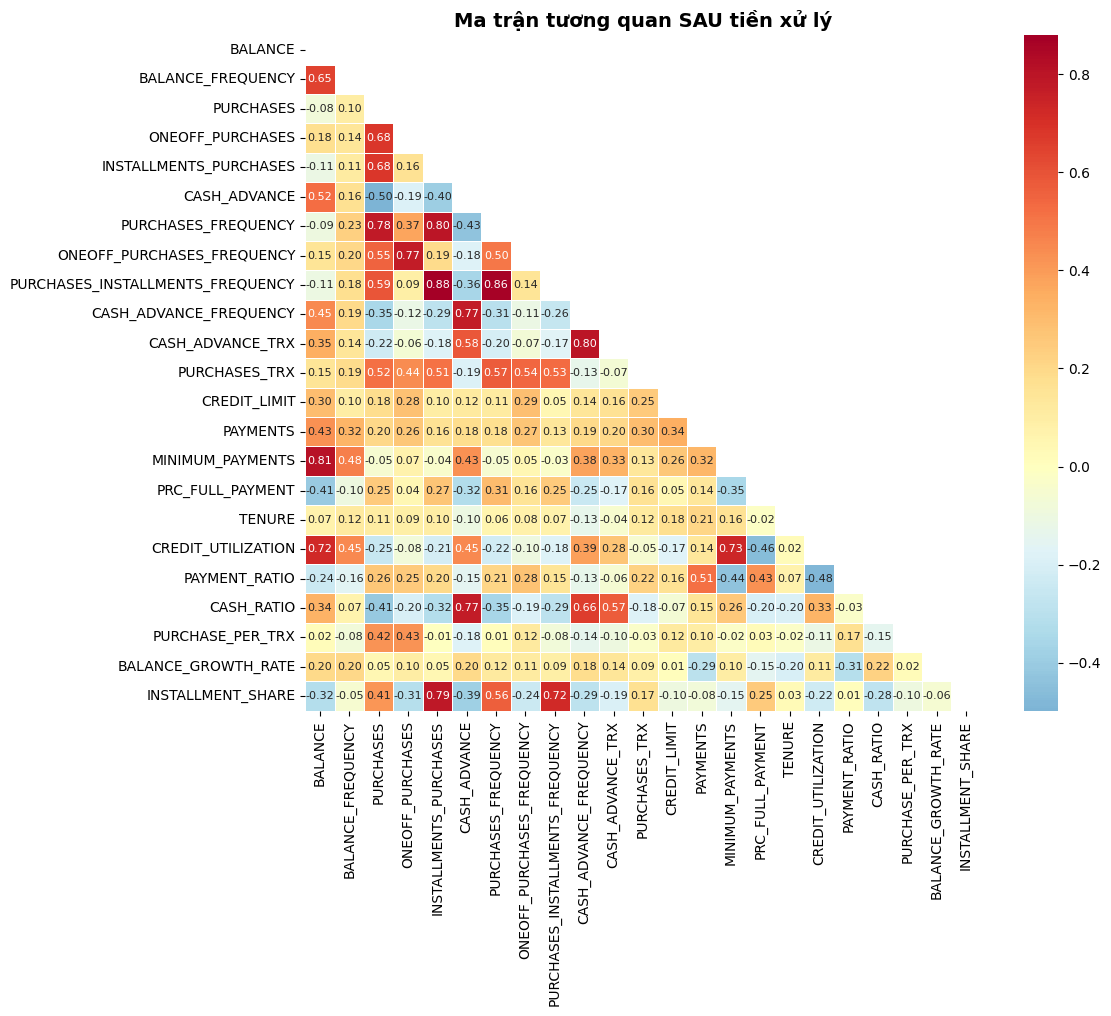


Phan tich cac cap bien co tuong quan cao:
------------------------------------------------------------
Cac cap bien co |r| > 0.7:
   - INSTALLMENTS_PURCHASES <-> PURCHASES_INSTALLMENTS_FREQUENCY: r = 0.879
   - PURCHASES_FREQUENCY <-> PURCHASES_INSTALLMENTS_FREQUENCY: r = 0.863
   - BALANCE <-> MINIMUM_PAYMENTS: r = 0.809
   - CASH_ADVANCE_FREQUENCY <-> CASH_ADVANCE_TRX: r = 0.8
   - INSTALLMENTS_PURCHASES <-> PURCHASES_FREQUENCY: r = 0.795
   - INSTALLMENTS_PURCHASES <-> INSTALLMENT_SHARE: r = 0.787
   - PURCHASES <-> PURCHASES_FREQUENCY: r = 0.782
   - CASH_ADVANCE <-> CASH_RATIO: r = 0.77
   - ONEOFF_PURCHASES <-> ONEOFF_PURCHASES_FREQUENCY: r = 0.769
   - CASH_ADVANCE <-> CASH_ADVANCE_FREQUENCY: r = 0.769
   - MINIMUM_PAYMENTS <-> CREDIT_UTILIZATION: r = 0.734
   - BALANCE <-> CREDIT_UTILIZATION: r = 0.724
   - PURCHASES_INSTALLMENTS_FREQUENCY <-> INSTALLMENT_SHARE: r = 0.721


In [27]:
# ============================================================================
# FEATURE SELECTION - XỬ LÝ ĐA CỘNG TUYẾN
# ============================================================================

print("=" * 60)
print("FEATURE SELECTION - XỬ LÝ ĐA CỘNG TUYẾN")
print("=" * 60)

# Kiem tra tuong quan cao
print("\nPhan tich tuong quan cao (|r| > 0.85):")
print("-" * 60)

corr_matrix = df_processed.corr()
high_corr_features = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            high_corr_features.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

if high_corr_features:
    high_corr_table = pd.DataFrame(high_corr_features)
    display(high_corr_table.sort_values('Correlation', ascending=False))
else:
    print("   Không có cặp biến nào có tương quan > 0.85")

# Vẽ ma trận tương quan sau xử lý
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, square=True, linewidths=0.5, annot_kws={"size": 8})
plt.title('Ma trận tương quan SAU tiền xử lý', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Phan tich cac cap tuong quan cao
print("\nPhan tich cac cap bien co tuong quan cao:")
print("-" * 60)

# Tim cac cap co correlation > 0.7
high_corr_07 = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_07.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': round(corr_matrix.iloc[i, j], 3)
            })

if high_corr_07:
    print("Cac cap bien co |r| > 0.7:")
    for pair in sorted(high_corr_07, key=lambda x: abs(x['Correlation']), reverse=True):
        print(f"   - {pair['Feature 1']} <-> {pair['Feature 2']}: r = {pair['Correlation']}")
else:
    print("   Khong co cap bien nao co tuong quan > 0.7")

In [28]:
# ============================================================================
# QUYẾT ĐỊNH LOẠI BỎ BIẾN (Marketing-first: dễ diễn giải, hạn chế trùng nghĩa)
# ============================================================================

print("=" * 60)
print("QUYẾT ĐỊNH LOẠI BỎ BIẾN")
print("=" * 60)

# Ý tưởng (marketing thuần):
# - Ưu tiên biến dạng tỷ lệ/tần suất (actionable) hơn là biến đếm/biến trùng nghĩa
# - Loại bớt biến mô tả cùng một hành vi để cụm dễ đặt tên và gắn chiến dịch

features_to_drop = []

# 1) Luôn loại PURCHASES nếu đã có 2 thành phần ONEOFF + INSTALLMENTS (redundant)
if 'PURCHASES' in df_processed.columns:
    has_components = (
        'ONEOFF_PURCHASES' in df_processed.columns and
        'INSTALLMENTS_PURCHASES' in df_processed.columns
    )
    if has_components:
        features_to_drop.append('PURCHASES')
        print("Loai bo 'PURCHASES' - la tong ONEOFF_PURCHASES + INSTALLMENTS_PURCHASES")

# 2) Loại các biến thường gây 'đếm đôi' về mặt hành vi
marketing_redundant = [
    'PURCHASES_TRX',
    'CASH_ADVANCE_TRX',
    'ONEOFF_PURCHASES_FREQUENCY',
    'PURCHASES_INSTALLMENTS_FREQUENCY',
    'BALANCE_FREQUENCY',
    'BALANCE_GROWTH_RATE',
 ]
features_to_drop.extend(marketing_redundant)

# 3) Ưu tiên tỷ lệ thay cho số tuyệt đối (chỉ drop khi ratio tồn tại)
if 'CREDIT_UTILIZATION' in df_processed.columns and 'BALANCE' in df_processed.columns:
    features_to_drop.append('BALANCE')
    print("Loai bo 'BALANCE' - uu tien 'CREDIT_UTILIZATION' de phan khuc theo muc su dung han muc")

if 'CASH_RATIO' in df_processed.columns and 'CASH_ADVANCE' in df_processed.columns:
    features_to_drop.append('CASH_ADVANCE')
    print("Loai bo 'CASH_ADVANCE' - uu tien 'CASH_RATIO' de chuan hoa theo han muc")

# 4) Nếu đã có ratio thanh toán thì MINIMUM_PAYMENTS ít cần cho marketing
if 'PAYMENT_RATIO' in df_processed.columns and 'MINIMUM_PAYMENTS' in df_processed.columns:
    features_to_drop.append('MINIMUM_PAYMENTS')
    print("Loai bo 'MINIMUM_PAYMENTS' - uu tien cac bien ty le (PAYMENT_RATIO) va hanh vi (PRC_FULL_PAYMENT)")

# Chuẩn hoá danh sách drop: chỉ drop cột tồn tại, bỏ trùng
seen = set()
features_to_drop = [c for c in features_to_drop if c in df_processed.columns and not (c in seen or seen.add(c))]

# Thực hiện loại bỏ
if features_to_drop:
    before_shape = df_processed.shape
    df_processed = df_processed.drop(columns=features_to_drop)
    after_shape = df_processed.shape
    print(f"\nDa loai bo {len(features_to_drop)} bien: {features_to_drop}")
    print(f"Shape: {before_shape} -> {after_shape}")
else:
    print("Khong can loai bo bien nao (khong tim thay bien trung/nghi ngo)")

print(f"\nSo features con lai: {df_processed.shape[1]}")
print(f"Danh sach features: {list(df_processed.columns)}")

QUYẾT ĐỊNH LOẠI BỎ BIẾN
Loai bo 'PURCHASES' - la tong ONEOFF_PURCHASES + INSTALLMENTS_PURCHASES
Loai bo 'BALANCE' - uu tien 'CREDIT_UTILIZATION' de phan khuc theo muc su dung han muc
Loai bo 'CASH_ADVANCE' - uu tien 'CASH_RATIO' de chuan hoa theo han muc
Loai bo 'MINIMUM_PAYMENTS' - uu tien cac bien ty le (PAYMENT_RATIO) va hanh vi (PRC_FULL_PAYMENT)

Da loai bo 10 bien: ['PURCHASES', 'PURCHASES_TRX', 'CASH_ADVANCE_TRX', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'BALANCE_FREQUENCY', 'BALANCE_GROWTH_RATE', 'BALANCE', 'CASH_ADVANCE', 'MINIMUM_PAYMENTS']
Shape: (8950, 23) -> (8950, 13)

So features con lai: 13
Danh sach features: ['ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE', 'CREDIT_UTILIZATION', 'PAYMENT_RATIO', 'CASH_RATIO', 'PURCHASE_PER_TRX', 'INSTALLMENT_SHARE']


### **2.6 Chuẩn hóa dữ liệu (Scaling)**

In [29]:
# ============================================================================
# CHUẨN HÓA DỮ LIỆU - STANDARD SCALER
# ============================================================================

print("=" * 60)
print("CHUẨN HÓA DỮ LIỆU - STANDARD SCALER")
print("=" * 60)

print("\nPhuong phap: StandardScaler (Z-score normalization)")
print("   Chuyen doi: z = (x - mean) / std")
print("   Ket qua: mean = 0, std = 1 cho moi feature")
print("   Tai sao can: K-Means su dung khoang cach Euclidean, nhay voi scale")

# Luu ten cot
feature_names = df_processed.columns.tolist()

# Ap dung StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_processed)

# Tao DataFrame voi du lieu da scale
df_scaled = pd.DataFrame(X_scaled, columns=feature_names)

# Kiem tra ket qua
print("\nThong ke SAU khi chuan hoa:")
print("-" * 60)
scaled_stats = df_scaled.describe().T[['mean', 'std', 'min', 'max']]
display(scaled_stats.round(4))

print("\nHoan thanh chuan hoa du lieu!")
print(f"Shape du lieu cuoi cung: {df_scaled.shape}")

CHUẨN HÓA DỮ LIỆU - STANDARD SCALER

Phuong phap: StandardScaler (Z-score normalization)
   Chuyen doi: z = (x - mean) / std
   Ket qua: mean = 0, std = 1 cho moi feature
   Tai sao can: K-Means su dung khoang cach Euclidean, nhay voi scale

Thong ke SAU khi chuan hoa:
------------------------------------------------------------


mean     std     min     max
ONEOFF_PURCHASES         0.0  1.0001 -0.9884  1.7327
INSTALLMENTS_PURCHASES   0.0  1.0001 -1.0887  1.5990
PURCHASES_FREQUENCY     -0.0  1.0001 -1.2218  1.2698
CASH_ADVANCE_FREQUENCY   0.0  1.0001 -0.6753  6.8205
CREDIT_LIMIT            -0.0  1.0001 -2.3174  2.0286
PAYMENTS                -0.0  1.0001 -4.1821  1.8308
PRC_FULL_PAYMENT         0.0  1.0001 -0.5256  2.8935
TENURE                   0.0  1.0001 -4.1228  0.3607
CREDIT_UTILIZATION      -0.0  1.0001 -1.0970  3.1756
PAYMENT_RATIO           -0.0  1.0001 -1.0630  1.8426
CASH_RATIO              -0.0  1.0001 -0.6371  3.6050
PURCHASE_PER_TRX        -0.0  1.0001 -0.6388  6.3869
INSTALLMENT_SHARE       -0.0  1.0001 -0.9151  1.4182


Hoan thanh chuan hoa du lieu!
Shape du lieu cuoi cung: (8950, 13)


### **2.7 Giảm chiều với PCA (Principal Component Analysis)**

GIẢM CHIỀU VỚI PCA

Muc dich PCA:
   1. Truc quan hoa du lieu da chieu (2D/3D)
   2. Giam nhieu, tap trung vao thong tin quan trong
   3. Tang toc do training cho cac mo hinh clustering

Phan tich Explained Variance:
------------------------------------------------------------
   Tong so features goc: 13
   So components giu 90% variance: 8
   So components giu 95% variance: 10

Chi tiet Explained Variance theo Component:
------------------------------------------------------------
   PC1:  26.90% | Cumulative:  26.90%
   PC2:  16.59% | Cumulative:  43.49%
   PC3:  12.12% | Cumulative:  55.61%
   PC4:  10.68% | Cumulative:  66.29%
   PC5:   8.38% | Cumulative:  74.68%
   PC6:   6.53% | Cumulative:  81.21%
   PC7:   5.35% | Cumulative:  86.56%
   PC8:   4.10% | Cumulative:  90.66%
   PC9:   3.98% | Cumulative:  94.63%
   PC10:   2.22% | Cumulative:  96.85%


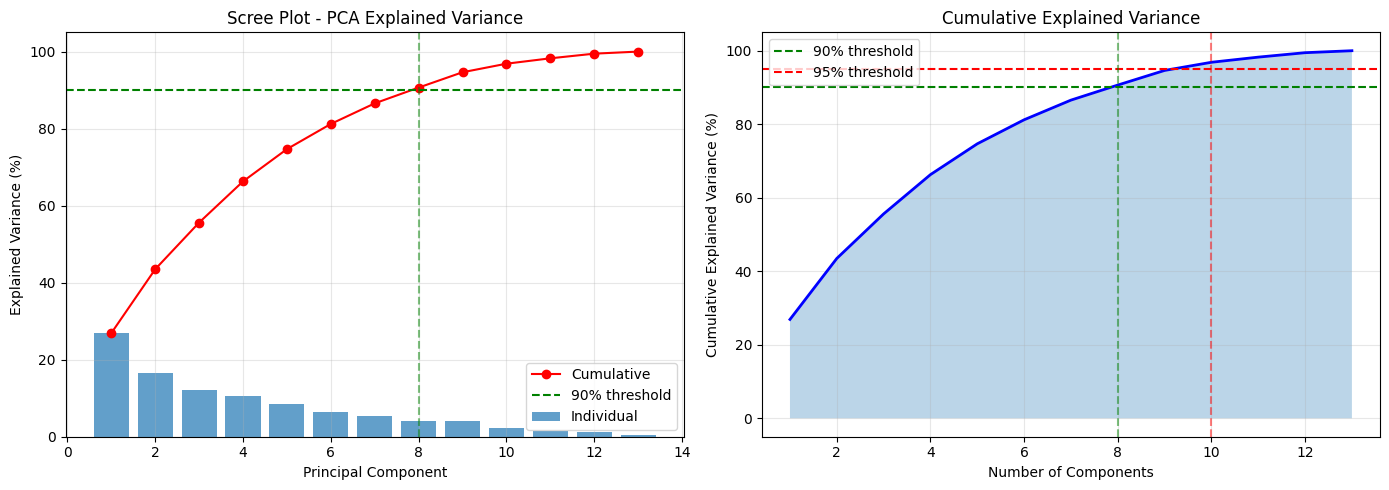


[INFO] PCA ở cell này chỉ dùng để PHÂN TÍCH explained variance.
[INFO] Các biến dùng cho clustering/visualization (X_full, X_pca_2d, X_pca_3d, ...) sẽ được tạo ở cell kế tiếp để tránh lặp.


In [30]:
# ============================================================================
# GIẢM CHIỀU VỚI PCA
# ============================================================================

print("=" * 60)
print("GIẢM CHIỀU VỚI PCA")
print("=" * 60)

print("\nMuc dich PCA:")
print("   1. Truc quan hoa du lieu da chieu (2D/3D)")
print("   2. Giam nhieu, tap trung vao thong tin quan trong")
print("   3. Tang toc do training cho cac mo hinh clustering")

# Phân tích PCA đầy đủ để xem explained variance
pca_full = PCA()
pca_full.fit(X_scaled)

# Tính cumulative explained variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Tìm số components để giữ 90% và 95% variance
n_comp_90 = np.argmax(cumulative_variance >=  0.90) + 1
n_comp_95 = np.argmax(cumulative_variance >=  0.95) + 1

print(f"\nPhan tich Explained Variance:")
print("-" * 60)
print(f"   Tong so features goc: {len(explained_variance)}")
print(f"   So components giu 90% variance: {n_comp_90}")
print(f"   So components giu 95% variance: {n_comp_95}")

# Hiển thị chi tiết từng component
print("\nChi tiet Explained Variance theo Component:")
print("-" * 60)
for i, (ev, cv) in enumerate(zip(explained_variance[:10], cumulative_variance[:10])):
    print(f"   PC{i+1}: {ev*100:6.2f}% | Cumulative: {cv*100:6.2f}%")

# Vẽ biểu đồ Explained Variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Scree Plot
ax1 = axes[0]
ax1.bar(range(1, len(explained_variance)+1), explained_variance*100, alpha=0.7, label='Individual')
ax1.plot(range(1, len(cumulative_variance)+1), cumulative_variance*100, 'ro-', label='Cumulative')
ax1.axhline(y=90, color='g', linestyle='--', label='90% threshold')
ax1.axvline(x=n_comp_90, color='g', linestyle='--', alpha=0.5)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance (%)')
ax1.set_title('Scree Plot - PCA Explained Variance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Cumulative Explained Variance
ax2 = axes[1]
ax2.plot(range(1, len(cumulative_variance)+1), cumulative_variance*100, 'b-', linewidth=2)
ax2.fill_between(range(1, len(cumulative_variance)+1), cumulative_variance*100, alpha=0.3)
ax2.axhline(y=90, color='g', linestyle='--', label='90% threshold')
ax2.axhline(y=95, color='r', linestyle='--', label='95% threshold')
ax2.axvline(x=n_comp_90, color='g', linestyle='--', alpha=0.5)
ax2.axvline(x=n_comp_95, color='r', linestyle='--', alpha=0.5)
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Explained Variance (%)')
ax2.set_title('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n[INFO] PCA ở cell này chỉ dùng để PHÂN TÍCH explained variance.")
print("[INFO] Các biến dùng cho clustering/visualization (X_full, X_pca_2d, X_pca_3d, ...) sẽ được tạo ở cell kế tiếp để tránh lặp.")

TẠO CÁC PHIÊN BẢN DỮ LIỆU CHO CLUSTERING

[OK] X_full: Du lieu da scale day du - Shape: (8950, 13)
[OK] X_pca_2d: PCA 2D cho truc quan hoa - Shape: (8950, 2)
   Explained variance: 43.49%
[OK] X_pca_3d: PCA 3D cho truc quan hoa - Shape: (8950, 3)
   Explained variance: 55.61%


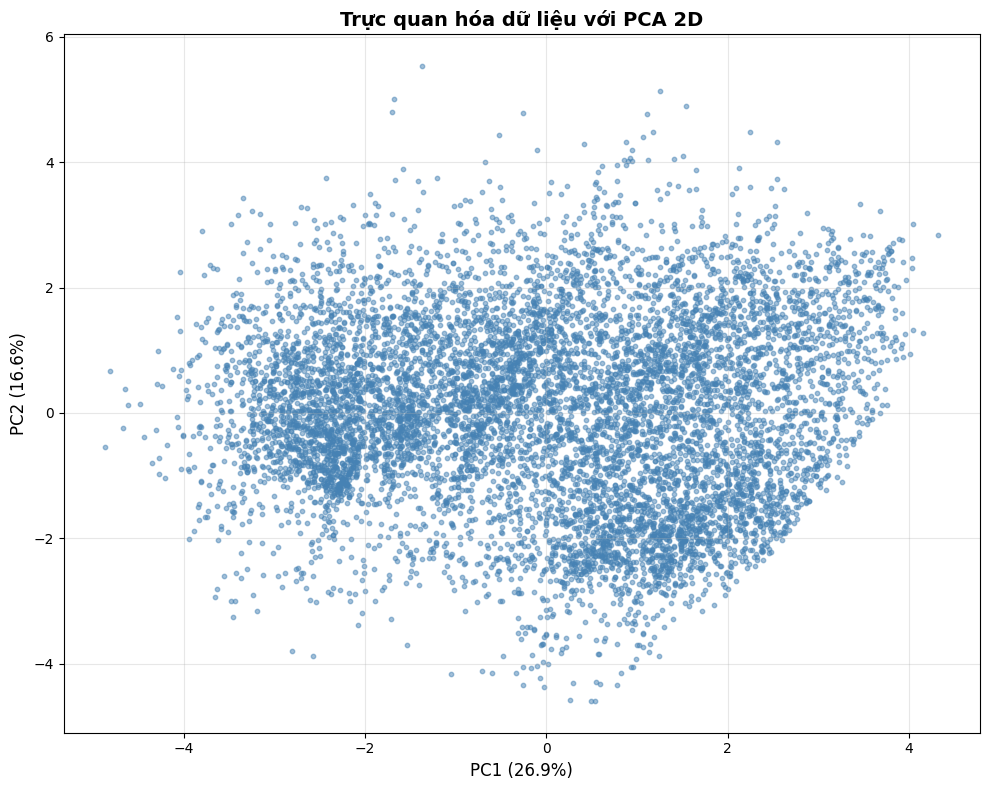


HOAN THANH TIEN XU LY DU LIEU!

[INFO] Du lieu san sang cho Clustering:
   - df_processed: DataFrame da xu ly (truoc scale)
   - X_full: Du lieu da scale day du (8950, 13)
   - X_pca_2d: PCA 2D cho truc quan hoa (8950, 2)
   - X_pca_3d: PCA 3D cho truc quan hoa (8950, 3)
   - feature_names: Danh sach ten features
   - scaler: StandardScaler object (de inverse transform neu can)


In [31]:
# ============================================================================
# TẠO CÁC PHIÊN BẢN DỮ LIỆU CHO CLUSTERING
# ============================================================================

print("=" * 60)
print("TẠO CÁC PHIÊN BẢN DỮ LIỆU CHO CLUSTERING")
print("=" * 60)

# 1. Du lieu da scale day du (cho clustering tren khong gian goc)
X_full = X_scaled.copy()
print(f"\n[OK] X_full: Du lieu da scale day du - Shape: {X_full.shape}")

# 2. PCA giam xuong de truc quan hoa 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)
print(f"[OK] X_pca_2d: PCA 2D cho truc quan hoa - Shape: {X_pca_2d.shape}")
print(f"   Explained variance: {pca_2d.explained_variance_ratio_.sum()*100:.2f}%")

# 3. PCA giam xuong de truc quan hoa 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
print(f"[OK] X_pca_3d: PCA 3D cho truc quan hoa - Shape: {X_pca_3d.shape}")
print(f"   Explained variance: {pca_3d.explained_variance_ratio_.sum()*100:.2f}%")

# Vẽ trực quan hóa 2D PCA
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.5, s=10, c='steelblue')
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax.set_title('Trực quan hóa dữ liệu với PCA 2D', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("HOAN THANH TIEN XU LY DU LIEU!")
print("=" * 60)
print("\n[INFO] Du lieu san sang cho Clustering:")
print(f"   - df_processed: DataFrame da xu ly (truoc scale)")
print(f"   - X_full: Du lieu da scale day du {X_full.shape}")
print(f"   - X_pca_2d: PCA 2D cho truc quan hoa {X_pca_2d.shape}")
print(f"   - X_pca_3d: PCA 3D cho truc quan hoa {X_pca_3d.shape}")
print(f"   - feature_names: Danh sach ten features")
print(f"   - scaler: StandardScaler object (de inverse transform neu can)")

### **2.8 Tóm tắt Pipeline Tiền Xử Lý**

                    TÓM TẮT PIPELINE TIỀN XỬ LÝ


Bước                   Phương pháp  \
0               1. Drop ID               Loại bỏ CUST_ID   
1        2. Missing Values     KNNImputer (k=5) + Median   
2  3. Outliers (Winsorize)        Clip percentile 1%-99%   
3   4. Feature Engineering  Tạo ratios + Marketing flags   
4         5. Log Transform       log1p() cho biến amount   
5     6. Feature Selection       Loại biến đa cộng tuyến   
6               7. Scaling                StandardScaler   
7                   8. PCA              Giảm chiều 2D/3D   

                                     Lý do  
0     Định danh, không có ý nghĩa phân cụm  
1            Giữ mối quan hệ giữa các biến  
2         Giữ dữ liệu, giảm extreme values  
3  Ratios có ý nghĩa hơn giá trị tuyệt đối  
4                Giảm skewness cho K-Means  
5   Giảm redundancy, tăng interpretability  
6                   K-Means nhạy với scale  
7               Trực quan hóa + giảm nhiễu

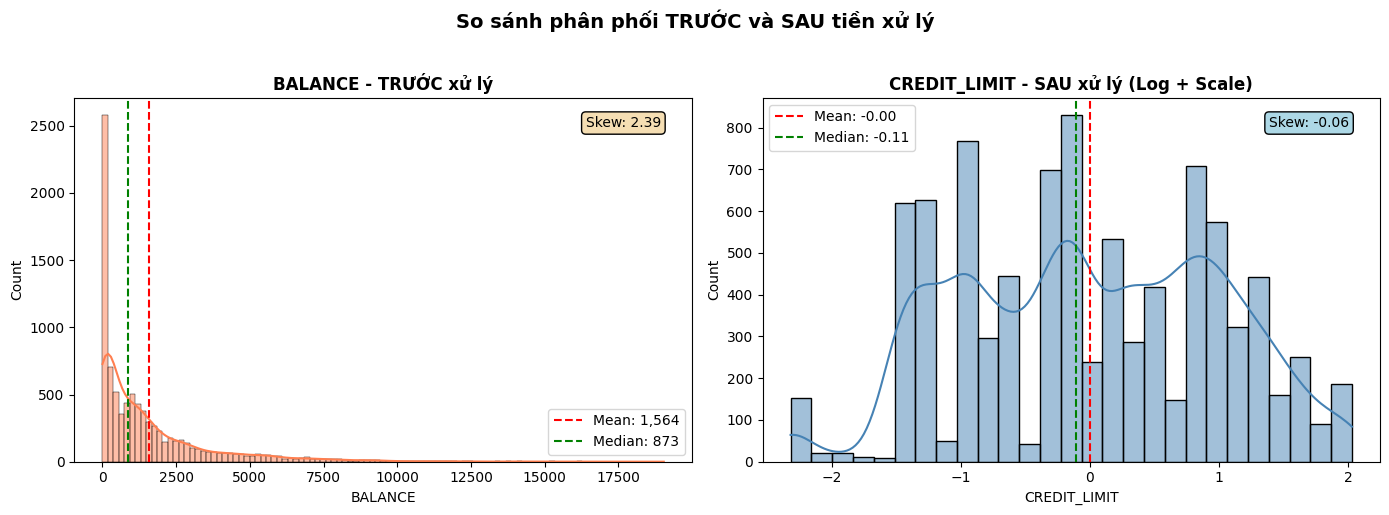


THÔNG TIN DỮ LIỆU SAU TIỀN XỬ LÝ
  - Số features sau preprocessing: 13
  - Số samples: 8,950
  - Danh sách features: ['ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE', 'CREDIT_UTILIZATION', 'PAYMENT_RATIO', 'CASH_RATIO', 'PURCHASE_PER_TRX', 'INSTALLMENT_SHARE']


In [32]:
# ============================================================================
# TÓM TẮT PIPELINE TIỀN XỬ LÝ
# ============================================================================

summary_data = {
    'Bước': [
        '1. Drop ID',
        '2. Missing Values',
        '3. Outliers (Winsorize)',
        '4. Feature Engineering',
        '5. Log Transform',
        '6. Feature Selection',
        '7. Scaling',
        '8. PCA'
    ],
    'Phương pháp': [
        'Loại bỏ CUST_ID',
        'KNNImputer (k=5) + Median',
        'Clip percentile 1%-99%',
        'Tạo ratios + Marketing flags',
        'log1p() cho biến amount',
        'Loại biến đa cộng tuyến',
        'StandardScaler',
        'Giảm chiều 2D/3D'
    ],
    'Lý do': [
        'Định danh, không có ý nghĩa phân cụm',
        'Giữ mối quan hệ giữa các biến',
        'Giữ dữ liệu, giảm extreme values',
        'Ratios có ý nghĩa hơn giá trị tuyệt đối',
        'Giảm skewness cho K-Means',
        'Giảm redundancy, tăng interpretability',
        'K-Means nhạy với scale',
        'Trực quan hóa + giảm nhiễu'
    ]
}

summary_df = pd.DataFrame(summary_data)

print("=" * 80)
print("                    TÓM TẮT PIPELINE TIỀN XỬ LÝ")
print("=" * 80)
display(summary_df)

# Tạo biểu đồ so sánh trước/sau
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Trước xử lý - lấy một biến mẫu từ df gốc (BALANCE)
ax1 = axes[0]
if 'BALANCE' in df.columns:
    sns.histplot(df['BALANCE'], kde=True, ax=ax1, color='coral', edgecolor='black')
    ax1.set_title('BALANCE - TRƯỚC xử lý', fontsize=12, fontweight='bold')
    ax1.axvline(df['BALANCE'].mean(), color='red', linestyle='--', label=f"Mean: {df['BALANCE'].mean():,.0f}")
    ax1.axvline(df['BALANCE'].median(), color='green', linestyle='--', label=f"Median: {df['BALANCE'].median():,.0f}")
    ax1.legend()
    ax1.text(0.95, 0.95, f"Skew: {df['BALANCE'].skew():.2f}", transform=ax1.transAxes,
             ha='right', va='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# Sau xử lý - kiểm tra xem BALANCE có còn trong df_scaled không (có thể đã bị drop)
ax2 = axes[1]
# Tìm một biến amount còn lại để so sánh
available_cols = [c for c in ['CREDIT_LIMIT', 'PAYMENTS', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES'] 
                  if c in df_scaled.columns]
if available_cols:
    demo_col = available_cols[0]
    sns.histplot(df_scaled[demo_col], kde=True, ax=ax2, color='steelblue', edgecolor='black')
    ax2.set_title(f'{demo_col} - SAU xử lý (Log + Scale)', fontsize=12, fontweight='bold')
    ax2.axvline(df_scaled[demo_col].mean(), color='red', linestyle='--', 
                label=f"Mean: {df_scaled[demo_col].mean():.2f}")
    ax2.axvline(df_scaled[demo_col].median(), color='green', linestyle='--', 
                label=f"Median: {df_scaled[demo_col].median():.2f}")
    ax2.legend()
    ax2.text(0.95, 0.95, f"Skew: {df_scaled[demo_col].skew():.2f}", transform=ax2.transAxes,
             ha='right', va='top', bbox=dict(boxstyle='round', facecolor='lightblue'))
else:
    ax2.text(0.5, 0.5, 'Không có biến amount để hiển thị', ha='center', va='center')
    ax2.axis('off')

plt.suptitle('So sánh phân phối TRƯỚC và SAU tiền xử lý', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# In thông tin số features cuối cùng
print("\n" + "=" * 80)
print("THÔNG TIN DỮ LIỆU SAU TIỀN XỬ LÝ")
print("=" * 80)
print(f"  - Số features sau preprocessing: {df_processed.shape[1]}")
print(f"  - Số samples: {df_processed.shape[0]:,}")
print(f"  - Danh sách features: {list(df_processed.columns)}")

## **3. Modeling**

### **3.1 K-Means Clustering**

K-Means là thuật toán clustering phổ biến nhất, hoạt động bằng cách:
1. Khởi tạo k centroid ngẫu nhiên
2. Gán mỗi điểm vào cluster gần nhất
3. Cập nhật centroid = trung bình các điểm trong cluster
4. Lặp lại cho đến khi hội tụ

**Ưu điểm**: Nhanh, đơn giản, hiệu quả với dữ liệu lớn
**Nhược điểm**: Cần chọn k trước, nhạy với outliers và khởi tạo

#### **3.1.1 Xac dinh so cum toi uu (k)**

Su dung 4 phuong phap:
1. **Elbow Method** (Inertia) - Tim diem "khuyu tay"
2. **Silhouette Score** - Do phan tach cac cum (-1 den 1, cang cao cang tot)
3. **Calinski-Harabasz Index** - Ty le phuong sai giua/trong cum (cang cao cang tot)
4. **Davies-Bouldin Index** - Do tuong tu giua cac cum (cang thap cang tot)

In [33]:
# ============================================================================
# TINH TOAN CAC METRICS DE CHON SO CUM TOI UU (Marketing-first)
# - Dung X_full (feature space da scale) de cum phan anh truc tiep bien kinh doanh
# - PCA chi dung de visualization
# ============================================================================

print("=" * 70)
print("3.1.1 XAC DINH SO CUM TOI UU CHO K-MEANS")
print("=" * 70)

# Khoang gia tri k can thu
k_range = range(2, 11)

# Luu ket qua
inertias = []
silhouettes = []
calinski_scores = []
davies_bouldin_scores = []

print("\n[INFO] Dang tinh toan cac metrics cho k = 2 den 10 (tren X_full)...")
print("-" * 70)

for k in k_range:
    # Train K-Means tren feature space da scale
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, max_iter=300, random_state=42)
    labels = kmeans.fit_predict(X_full)
    
    # Tinh cac metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_full, labels)
    calinski = calinski_harabasz_score(X_full, labels)
    davies = davies_bouldin_score(X_full, labels)
    
    # Luu ket qua
    inertias.append(inertia)
    silhouettes.append(silhouette)
    calinski_scores.append(calinski)
    davies_bouldin_scores.append(davies)
    
    print(f"k={k}: Inertia={inertia:,.0f} | Silhouette={silhouette:.4f} | "
          f"Calinski={calinski:,.0f} | Davies-Bouldin={davies:.4f}")

print("-" * 70)
print("[OK] Hoan thanh tinh toan!")

3.1.1 XAC DINH SO CUM TOI UU CHO K-MEANS

[INFO] Dang tinh toan cac metrics cho k = 2 den 10 (tren X_full)...
----------------------------------------------------------------------
k=2: Inertia=92,787 | Silhouette=0.2114 | Calinski=2,272 | Davies-Bouldin=1.8707
k=3: Inertia=81,536 | Silhouette=0.1958 | Calinski=1,910 | Davies-Bouldin=1.8080
k=4: Inertia=74,608 | Silhouette=0.1846 | Calinski=1,668 | Davies-Bouldin=1.8460
k=5: Inertia=68,833 | Silhouette=0.1885 | Calinski=1,544 | Davies-Bouldin=1.7183
k=6: Inertia=63,824 | Silhouette=0.1804 | Calinski=1,472 | Davies-Bouldin=1.6493
k=7: Inertia=59,387 | Silhouette=0.1848 | Calinski=1,430 | Davies-Bouldin=1.5428
k=8: Inertia=56,059 | Silhouette=0.1848 | Calinski=1,374 | Davies-Bouldin=1.5252
k=9: Inertia=53,126 | Silhouette=0.1831 | Calinski=1,330 | Davies-Bouldin=1.5138
k=10: Inertia=50,833 | Silhouette=0.1824 | Calinski=1,280 | Davies-Bouldin=1.5342
----------------------------------------------------------------------
[OK] Hoan thanh ti

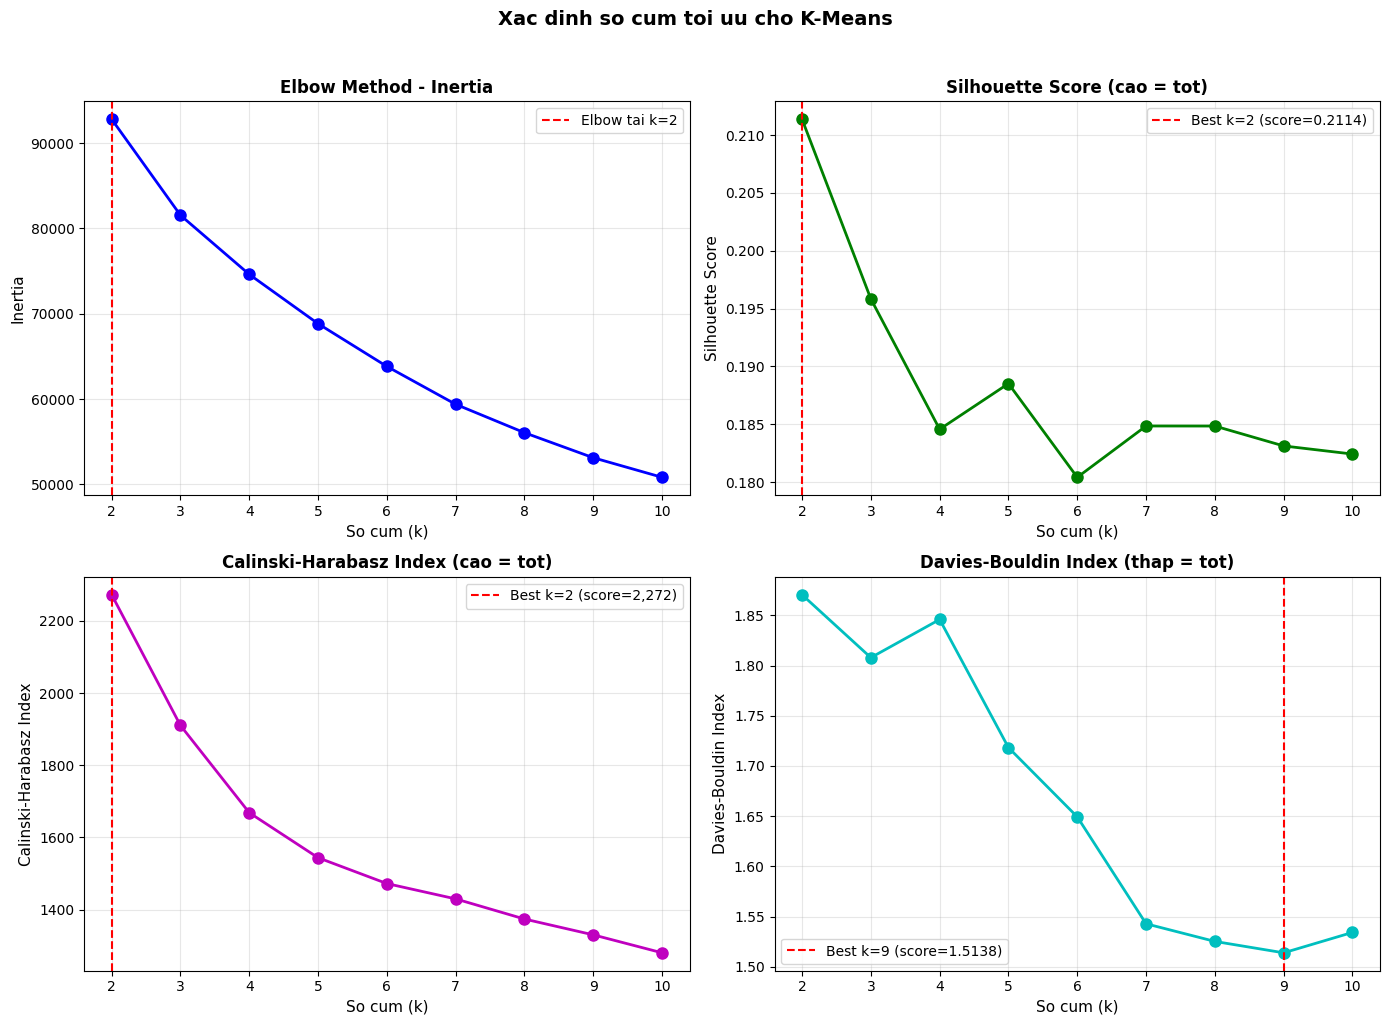

In [34]:
# ============================================================================
# TRUC QUAN HOA CAC METRICS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Elbow Method (Inertia)
ax1 = axes[0, 0]
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('So cum (k)', fontsize=11)
ax1.set_ylabel('Inertia', fontsize=11)
ax1.set_title('Elbow Method - Inertia', fontsize=12, fontweight='bold')
ax1.set_xticks(list(k_range))
ax1.grid(True, alpha=0.3)

# Tim diem elbow (su dung phuong phap do goc)
# Tinh do giam inertia
inertia_diff = np.diff(inertias)
inertia_diff2 = np.diff(inertia_diff)
elbow_idx = np.argmax(inertia_diff2) + 2  # +2 vi diff giam 1 index 2 lan
ax1.axvline(x=elbow_idx, color='red', linestyle='--', label=f'Elbow tai k={elbow_idx}')
ax1.legend()

# 2. Silhouette Score
ax2 = axes[0, 1]
ax2.plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('So cum (k)', fontsize=11)
ax2.set_ylabel('Silhouette Score', fontsize=11)
ax2.set_title('Silhouette Score (cao = tot)', fontsize=12, fontweight='bold')
ax2.set_xticks(list(k_range))
ax2.grid(True, alpha=0.3)

# Danh dau k tot nhat
best_silhouette_k = k_range[np.argmax(silhouettes)]
ax2.axvline(x=best_silhouette_k, color='red', linestyle='--', 
            label=f'Best k={best_silhouette_k} (score={max(silhouettes):.4f})')
ax2.legend()

# 3. Calinski-Harabasz Index
ax3 = axes[1, 0]
ax3.plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
ax3.set_xlabel('So cum (k)', fontsize=11)
ax3.set_ylabel('Calinski-Harabasz Index', fontsize=11)
ax3.set_title('Calinski-Harabasz Index (cao = tot)', fontsize=12, fontweight='bold')
ax3.set_xticks(list(k_range))
ax3.grid(True, alpha=0.3)

best_calinski_k = k_range[np.argmax(calinski_scores)]
ax3.axvline(x=best_calinski_k, color='red', linestyle='--',
            label=f'Best k={best_calinski_k} (score={max(calinski_scores):,.0f})')
ax3.legend()

# 4. Davies-Bouldin Index
ax4 = axes[1, 1]
ax4.plot(k_range, davies_bouldin_scores, 'co-', linewidth=2, markersize=8)
ax4.set_xlabel('So cum (k)', fontsize=11)
ax4.set_ylabel('Davies-Bouldin Index', fontsize=11)
ax4.set_title('Davies-Bouldin Index (thap = tot)', fontsize=12, fontweight='bold')
ax4.set_xticks(list(k_range))
ax4.grid(True, alpha=0.3)

best_db_k = k_range[np.argmin(davies_bouldin_scores)]
ax4.axvline(x=best_db_k, color='red', linestyle='--',
            label=f'Best k={best_db_k} (score={min(davies_bouldin_scores):.4f})')
ax4.legend()

plt.suptitle('Xac dinh so cum toi uu cho K-Means', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [35]:
# ============================================================================
# TONG HOP KET QUA VA QUYET DINH CHON K
# ============================================================================

print("=" * 70)
print("TONG HOP KET QUA CHON SO CUM TOI UU")
print("=" * 70)

# Tao bang tong hop
metrics_df = pd.DataFrame({
    'k': list(k_range),
    'Inertia': inertias,
    'Silhouette': silhouettes,
    'Calinski-Harabasz': calinski_scores,
    'Davies-Bouldin': davies_bouldin_scores
})

display(metrics_df.round(4))

# Tong hop khuyen nghi tu cac phuong phap
print("\n" + "-" * 70)
print("KHUYEN NGHI TU CAC PHUONG PHAP:")
print("-" * 70)
print(f"  [1] Elbow Method:        k = {elbow_idx}")
print(f"  [2] Silhouette Score:    k = {best_silhouette_k} (max = {max(silhouettes):.4f})")
print(f"  [3] Calinski-Harabasz:   k = {best_calinski_k} (max = {max(calinski_scores):,.0f})")
print(f"  [4] Davies-Bouldin:      k = {best_db_k} (min = {min(davies_bouldin_scores):.4f})")

# Dem so vote cho moi k
votes = {}
for k in [elbow_idx, best_silhouette_k, best_calinski_k, best_db_k]:
    votes[k] = votes.get(k, 0) + 1

recommended_k_by_metrics = max(votes, key=votes.get)
chosen_k_for_marketing = 4  # cố định để ra 4 persona marketing (có thể đổi nếu muốn)

print(f"\n  --> k gợi ý theo metrics: k = {recommended_k_by_metrics} (votes={votes.get(recommended_k_by_metrics, 0)}/4)")
print(f"  --> k CHỌN cho marketing/persona: k = {chosen_k_for_marketing}")

# Phân tích thêm Silhouette cho các k gần k được chọn (marketing-first)
print("\n" + "-" * 70)
print("PHAN TICH CHI TIET SILHOUETTE (quanh k duoc chon):")
print("-" * 70)
for k in range(max(2, chosen_k_for_marketing-2), min(11, chosen_k_for_marketing+3)):
    idx = k - 2  # vi k_range bat dau tu 2
    if 0 <= idx < len(silhouettes):
        score = silhouettes[idx]
        if score >=  0.5:
            quality = "MANH (cau truc cum ro rang)"
        elif score >=  0.25:
            quality = "TRUNG BINH (cau truc hop ly)"
        else:
            quality = "YEU (cum chong cheo)"
        marker = " <-- k duoc chon" if k == chosen_k_for_marketing else ""
        print(f"  k={k}: Silhouette = {score:.4f} - {quality}{marker}")

TONG HOP KET QUA CHON SO CUM TOI UU


k     Inertia  Silhouette  Calinski-Harabasz  Davies-Bouldin
0   2  92787.0744      0.2114          2272.3152          1.8707
1   3  81536.2014      0.1958          1910.0697          1.8080
2   4  74607.5047      0.1846          1668.4149          1.8460
3   5  68832.6937      0.1885          1543.7525          1.7183
4   6  63824.3133      0.1804          1472.1344          1.6493
5   7  59386.8948      0.1848          1429.6674          1.5428
6   8  56058.7357      0.1848          1373.8766          1.5252
7   9  53126.1080      0.1831          1330.0551          1.5138
8  10  50832.5616      0.1824          1280.2978          1.5342


----------------------------------------------------------------------
KHUYEN NGHI TU CAC PHUONG PHAP:
----------------------------------------------------------------------
  [1] Elbow Method:        k = 2
  [2] Silhouette Score:    k = 2 (max = 0.2114)
  [3] Calinski-Harabasz:   k = 2 (max = 2,272)
  [4] Davies-Bouldin:      k = 9 (min = 1.5138)

  --> k gợi ý theo metrics: k = 2 (votes=3/4)
  --> k CHỌN cho marketing/persona: k = 4

----------------------------------------------------------------------
PHAN TICH CHI TIET SILHOUETTE (quanh k duoc chon):
----------------------------------------------------------------------
  k=2: Silhouette = 0.2114 - YEU (cum chong cheo)
  k=3: Silhouette = 0.1958 - YEU (cum chong cheo)
  k=4: Silhouette = 0.1846 - YEU (cum chong cheo) <-- k duoc chon
  k=5: Silhouette = 0.1885 - YEU (cum chong cheo)
  k=6: Silhouette = 0.1804 - YEU (cum chong cheo)


#### **3.1.2 Silhouette Analysis chi tiet**

Silhouette plot giup truc quan hoa chat luong tung cum:
- **Chieu rong**: So luong mau trong cum
- **Chieu dai**: Silhouette score cua moi mau
- Duong do: Silhouette trung binh

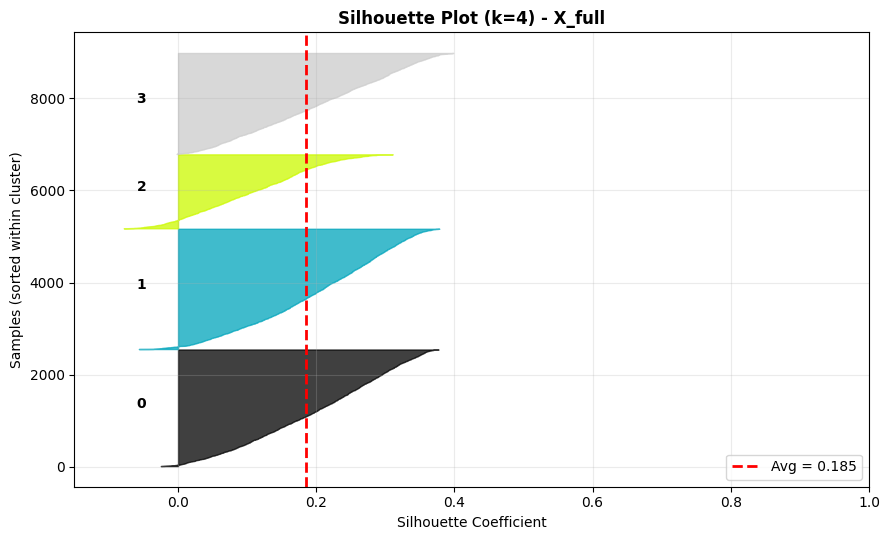

[INFO] Silhouette avg (k=4): 0.1846
[INFO] % mẫu có silhouette < 0: 3.05% (càng thấp càng tốt)


In [36]:
# ============================================================================
# SILHOUETTE ANALYSIS (report-ready) cho k được chọn (tren X_full)
# ============================================================================

k_sil = int(globals().get('chosen_k_for_marketing', 4))

kmeans_tmp = KMeans(n_clusters=k_sil, init='k-means++', n_init=20, random_state=42)
labels_tmp = kmeans_tmp.fit_predict(X_full)

sil_avg = silhouette_score(X_full, labels_tmp)
sil_vals = silhouette_samples(X_full, labels_tmp)
neg_pct = float((sil_vals < 0).mean() * 100)

fig, ax = plt.subplots(figsize=(9, 5.5))
y_lower = 10
colors_list = plt.cm.nipy_spectral(np.linspace(0, 1, k_sil))

for i in range(k_sil):
    vals_i = np.sort(sil_vals[labels_tmp == i])
    size_i = vals_i.shape[0]
    y_upper = y_lower + size_i

    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        vals_i,
        facecolor=colors_list[i],
        edgecolor=colors_list[i],
        alpha=0.75,
    )
    ax.text(-0.06, y_lower + 0.5 * size_i, str(i), fontsize=10, fontweight='bold')
    y_lower = y_upper + 10

ax.axvline(x=sil_avg, color='red', linestyle='--', linewidth=2, label=f'Avg = {sil_avg:.3f}')
ax.set_title(f'Silhouette Plot (k={k_sil}) - X_full', fontsize=12, fontweight='bold')
ax.set_xlabel('Silhouette Coefficient', fontsize=10)
ax.set_ylabel('Samples (sorted within cluster)', fontsize=10)
ax.set_xlim([-0.15, 1.0])
ax.grid(True, alpha=0.25)
ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

print(f"[INFO] Silhouette avg (k={k_sil}): {sil_avg:.4f}")
print(f"[INFO] % mẫu có silhouette < 0: {neg_pct:.2f}% (càng thấp càng tốt)")

#### **3.1.3 Train K-Means voi k toi uu**

In [37]:
# ============================================================================
# TRAIN K-MEANS VOI K TOI UU (Marketing-first: train tren X_full)
# ============================================================================

# Chọn k cho marketing/persona (đã quyết ở cell tổng hợp phía trên)
# Nếu cell đó chưa chạy, mặc định k=4
optimal_k = int(globals().get('chosen_k_for_marketing', 4))

print("=" * 70)
print(f"3.1.3 TRAIN K-MEANS VOI k = {optimal_k}")
print("=" * 70)

kmeans_final = KMeans(
    n_clusters=optimal_k,
    init='k-means++',
    n_init=50,
    max_iter=300,
    random_state=42
)

# Fit va predict tren X_full (feature space da scale)
kmeans_labels = kmeans_final.fit_predict(X_full)

# Them labels vao DataFrame da xu ly
df_processed['Cluster'] = kmeans_labels

print(f"\n[OK] Da train K-Means voi k = {optimal_k} (X_full)")
print(f"\n[INFO] Thong tin mo hinh:")
print(f"   - So cum: {optimal_k}")
print(f"   - So vong lap hoi tu: {kmeans_final.n_iter_}")
print(f"   - Inertia: {kmeans_final.inertia_:,.2f}")

print(f"\n[INFO] Phan phoi mau trong cac cum:")
print("-" * 40)
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(kmeans_labels) * 100
    print(f"   Cluster {cluster}: {count:,} mau ({pct:.1f}%)")

# Tinh cac metrics tren X_full
final_silhouette = silhouette_score(X_full, kmeans_labels)
final_calinski = calinski_harabasz_score(X_full, kmeans_labels)
final_davies = davies_bouldin_score(X_full, kmeans_labels)

print(f"\n[INFO] Danh gia chat luong clustering (X_full):")
print("-" * 40)
print(f"   Silhouette Score:      {final_silhouette:.4f}")
print(f"   Calinski-Harabasz:     {final_calinski:,.2f}")
print(f"   Davies-Bouldin:        {final_davies:.4f}")

3.1.3 TRAIN K-MEANS VOI k = 4

[OK] Da train K-Means voi k = 4 (X_full)

[INFO] Thong tin mo hinh:
   - So cum: 4
   - So vong lap hoi tu: 18
   - Inertia: 74,607.32

[INFO] Phan phoi mau trong cac cum:
----------------------------------------
   Cluster 0: 2,197 mau (24.5%)
   Cluster 1: 1,593 mau (17.8%)
   Cluster 2: 2,623 mau (29.3%)
   Cluster 3: 2,537 mau (28.3%)

[INFO] Danh gia chat luong clustering (X_full):
----------------------------------------
   Silhouette Score:      0.1847
   Calinski-Harabasz:     1,668.43
   Davies-Bouldin:        1.8458


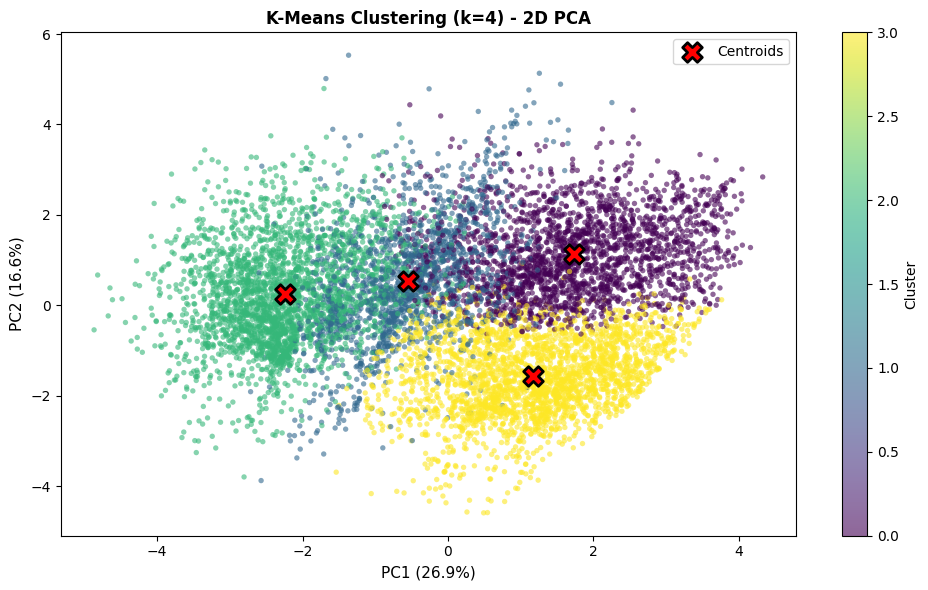


[INFO] Visualization 2D:
   - Mau sac: Cac cum khac nhau
   - Dau X do: Tam cum (centroids) project qua PCA
   - Cum tach biet ro hon = de hanh dong marketing


In [38]:
# ============================================================================
# TRUC QUAN HOA KET QUA CLUSTERING - 2D PCA
# - Labels lay tu KMeans train tren X_full
# - PCA chi dung de visualize; centroid duoc project qua PCA da fit tren X_scaled
# ============================================================================

fig, ax1 = plt.subplots(figsize=(10, 6))

# Visualization 2D
scatter = ax1.scatter(
    X_pca_2d[:, 0], X_pca_2d[:, 1],
    c=kmeans_labels, cmap='viridis', alpha=0.6, s=15, edgecolors='none'
)

# Ve centroids (project sang 2D PCA)
centroids_2d = pca_2d.transform(kmeans_final.cluster_centers_)
ax1.scatter(
    centroids_2d[:, 0], centroids_2d[:, 1],
    c='red', marker='X', s=200, edgecolors='black', linewidths=2, label='Centroids'
)

ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax1.set_title(f'K-Means Clustering (k={optimal_k}) - 2D PCA', fontsize=12, fontweight='bold')
ax1.legend()

# Colorbar
cbar = plt.colorbar(scatter, ax=ax1)
cbar.set_label('Cluster', fontsize=10)

plt.tight_layout()
plt.show()

print("\n[INFO] Visualization 2D:")
print("   - Mau sac: Cac cum khac nhau")
print("   - Dau X do: Tam cum (centroids) project qua PCA")
print("   - Cum tach biet ro hon = de hanh dong marketing")

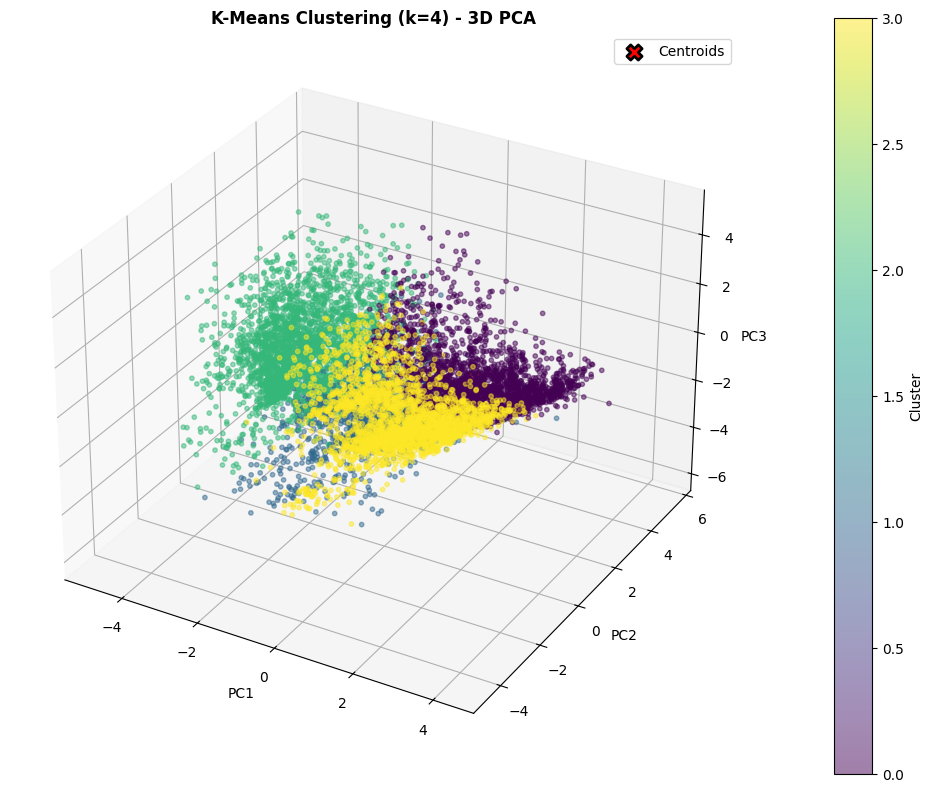


[INFO] Visualization 3D:
   - Cho phep xem cum tu nhieu goc do
   - Dau X do: Tam cum (centroids)
   - Co the xoay de quan sat tot hon


In [39]:
# ============================================================================
# TRUC QUAN HOA KET QUA CLUSTERING - 3D PCA
# - Labels lay tu KMeans train tren X_full
# - PCA 3D dung de visualize khong gian 3 chieu
# ============================================================================

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Visualization 3D
scatter3d = ax.scatter(
    X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
    c=kmeans_labels, cmap='viridis', alpha=0.5, s=10
)

# Ve centroids in 3D
try:
    centroids_3d = pca_3d.transform(kmeans_final.cluster_centers_)
    ax.scatter(
        centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2],
        c='red', marker='X', s=120, edgecolors='black', linewidths=2, label='Centroids'
    )
    ax.legend()
except Exception as e:
    print(f"[WARNING] Khong the hien thi centroids 3D: {e}")

ax.set_xlabel('PC1', fontsize=10)
ax.set_ylabel('PC2', fontsize=10)
ax.set_zlabel('PC3', fontsize=10)
ax.set_title(f'K-Means Clustering (k={optimal_k}) - 3D PCA', fontsize=12, fontweight='bold')

# Colorbar
cbar = plt.colorbar(scatter3d, ax=ax, pad=0.1)
cbar.set_label('Cluster', fontsize=10)

plt.tight_layout()
plt.show()

print("\n[INFO] Visualization 3D:")
print("   - Cho phep xem cum tu nhieu goc do")
print("   - Dau X do: Tam cum (centroids)")
print("   - Co the xoay de quan sat tot hon")

#### **3.1.4 Phan tich dac trung tung cum**

In [40]:
# ============================================================================
# PHAN TICH DAC TRUNG TUNG CUM (Marketing-first profiling)
# - Dung du lieu goc (de doc amount that)
# - Bo sung ratios + flags de dat ten cum/ra chien dich de hon
# - SỬ DỤNG df_profiling_flags (đã tạo trước đó) để profiling
# ============================================================================

print("=" * 70)
print("3.1.4 PHAN TICH DAC TRUNG TUNG CUM")
print("=" * 70)

# Bắt đầu từ dữ liệu gốc
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = kmeans_labels

EPS = 1e-9

# ============================================================================
# 1. THÊM CÁC RATIO (tính lại từ dữ liệu gốc để có giá trị thực)
# ============================================================================

# CREDIT_UTILIZATION
if 'CREDIT_LIMIT' in df_with_clusters.columns and 'BALANCE' in df_with_clusters.columns:
    df_with_clusters['CREDIT_UTILIZATION'] = np.where(
        df_with_clusters['CREDIT_LIMIT'] > 0,
        df_with_clusters['BALANCE'] / (df_with_clusters['CREDIT_LIMIT'] + EPS),
        0.0
    ).clip(0, 1.5)

# CASH_RATIO
if 'CREDIT_LIMIT' in df_with_clusters.columns and 'CASH_ADVANCE' in df_with_clusters.columns:
    df_with_clusters['CASH_RATIO'] = np.where(
        df_with_clusters['CREDIT_LIMIT'] > 0,
        df_with_clusters['CASH_ADVANCE'] / (df_with_clusters['CREDIT_LIMIT'] + EPS),
        0.0
    ).clip(0, 1.5)

# PAYMENT_RATIO
if 'MINIMUM_PAYMENTS' in df_with_clusters.columns and 'PAYMENTS' in df_with_clusters.columns:
    df_with_clusters['PAYMENT_RATIO'] = np.where(
        df_with_clusters['MINIMUM_PAYMENTS'] > 0,
        df_with_clusters['PAYMENTS'] / (df_with_clusters['MINIMUM_PAYMENTS'] + EPS),
        np.where(df_with_clusters['PAYMENTS'] > 0, 5.0, 0.0)
    ).clip(0, 10)

# PURCHASE_PER_TRX
if 'PURCHASES_TRX' in df_with_clusters.columns and 'PURCHASES' in df_with_clusters.columns:
    df_with_clusters['PURCHASE_PER_TRX'] = np.where(
        df_with_clusters['PURCHASES_TRX'] > 0,
        df_with_clusters['PURCHASES'] / (df_with_clusters['PURCHASES_TRX'] + EPS),
        0.0
    )

# INSTALLMENT_SHARE
if 'ONEOFF_PURCHASES' in df_with_clusters.columns and 'INSTALLMENTS_PURCHASES' in df_with_clusters.columns:
    denom = df_with_clusters['ONEOFF_PURCHASES'] + df_with_clusters['INSTALLMENTS_PURCHASES'] + EPS
    df_with_clusters['INSTALLMENT_SHARE'] = (df_with_clusters['INSTALLMENTS_PURCHASES'] / denom).clip(0, 1)

# ============================================================================
# 2. THÊM CÁC FLAG TỪ df_profiling_flags (đã tạo trước khi train)
# ============================================================================
print("\n[INFO] Đang thêm FLAGS từ df_profiling_flags để profiling...")

# Kiểm tra df_profiling_flags có tồn tại không
if 'df_profiling_flags' in dir():
    # Merge các FLAG vào df_with_clusters
    for flag_col in df_profiling_flags.columns:
        df_with_clusters[flag_col] = df_profiling_flags[flag_col].values
    print(f"   Đã thêm {len(df_profiling_flags.columns)} FLAGS: {list(df_profiling_flags.columns)}")
else:
    # Nếu chưa có, tạo lại từ dữ liệu gốc
    print("   [WARNING] df_profiling_flags chưa được tạo, tạo lại từ dữ liệu gốc...")
    
    if 'PURCHASES' in df_with_clusters.columns:
        df_with_clusters['HAS_PURCHASE'] = (df_with_clusters['PURCHASES'] > 0).astype(int)
    
    if 'CASH_ADVANCE' in df_with_clusters.columns:
        df_with_clusters['HAS_CASH_ADV'] = (df_with_clusters['CASH_ADVANCE'] > 0).astype(int)
    
    if 'PRC_FULL_PAYMENT' in df_with_clusters.columns:
        df_with_clusters['FULL_PAYER_FLAG'] = (df_with_clusters['PRC_FULL_PAYMENT'] >= 0.8).astype(int)
    
    if 'CREDIT_UTILIZATION' in df_with_clusters.columns:
        df_with_clusters['HIGH_UTIL_FLAG'] = (df_with_clusters['CREDIT_UTILIZATION'] >= 0.7).astype(int)
    
    if 'CASH_RATIO' in df_with_clusters.columns:
        df_with_clusters['CASH_HEAVY_FLAG'] = (df_with_clusters['CASH_RATIO'] >= 0.3).astype(int)

# ============================================================================
# 3. TÍNH PROFILE THEO CỤM
# ============================================================================
cluster_profile = df_with_clusters.groupby('Cluster').mean(numeric_only=True)
cluster_median = df_with_clusters.groupby('Cluster').median(numeric_only=True)

print("\n" + "=" * 70)
print("[INFO] GIÁ TRỊ TRUNG BÌNH của từng cụm (kèm ratios/flags):")
print("=" * 70)
display(cluster_profile.round(3))

print("\n" + "=" * 70)
print("[INFO] GIÁ TRỊ MEDIAN của từng cụm (robust hơn với outliers):")
print("=" * 70)
display(cluster_median.round(3))

# ============================================================================
# 4. HIGHLIGHT FLAGS PROFILE (quan trọng cho đặt tên cụm)
# ============================================================================
flag_cols = ['HAS_PURCHASE', 'HAS_CASH_ADV', 'FULL_PAYER_FLAG', 'HIGH_UTIL_FLAG', 'CASH_HEAVY_FLAG']
flag_cols_exist = [c for c in flag_cols if c in df_with_clusters.columns]

if flag_cols_exist:
    print("\n" + "=" * 70)
    print("[QUAN TRỌNG] PHÂN TÍCH FLAGS THEO CỤM (dùng để đặt tên & thiết kế chiến dịch):")
    print("=" * 70)
    flags_profile = df_with_clusters.groupby('Cluster')[flag_cols_exist].mean()
    display((flags_profile * 100).round(1).astype(str) + '%')
    
    print("\nGhi chú:")
    print("  - HAS_PURCHASE:    % khách có mua sắm")
    print("  - HAS_CASH_ADV:    % khách có rút tiền mặt")
    print("  - FULL_PAYER_FLAG: % khách trả hết nợ >= 80% thời gian")
    print("  - HIGH_UTIL_FLAG:  % khách sử dụng >= 70% hạn mức")
    print("  - CASH_HEAVY_FLAG: % khách rút tiền mặt >= 30% hạn mức")

3.1.4 PHAN TICH DAC TRUNG TUNG CUM

[INFO] Đang thêm FLAGS từ df_profiling_flags để profiling...
   Đã thêm 5 FLAGS: ['HAS_PURCHASE', 'HAS_CASH_ADV', 'FULL_PAYER_FLAG', 'HIGH_UTIL_FLAG', 'CASH_HEAVY_FLAG']

[INFO] GIÁ TRỊ TRUNG BÌNH của từng cụm (kèm ratios/flags):


BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                             
0        1810.869              0.940   2804.090          1759.912   
1        1147.738              0.806    732.319           710.581   
2        2387.676              0.909    107.324            85.499   
3         761.666              0.835    540.009            31.363   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                      1044.461       717.933                0.856   
1                        22.006       290.552                0.303   
2                        21.864      2334.151                0.082   
3                       509.251       235.817                0.713   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                                                 
0                             0.530                             0.644   
1                             0.278                             0.036   
2                             0.050                             0.036   
3                             0.029                             0.669   

         CASH_ADVANCE_FREQUENCY  ...  CREDIT_UTILIZATION  CASH_RATIO  \
Cluster                          ...                                   
0                         0.087  ...               0.265       0.104   
1                         0.054  ...               0.359       0.073   
2                         0.319  ...               0.598       0.572   
3                         0.038  ...               0.292       0.078   

         PAYMENT_RATIO  PURCHASE_PER_TRX  INSTALLMENT_SHARE  HAS_PURCHASE  \
Cluster                                                                     
0                6.247            86.664              0.411         0.999   
1                2.881           191.747              0.028         0.974   
2                2.783            16.887              0.055         0.238   
3                2.882            47.692              0.954         1.000   

         HAS_CASH_ADV  FULL_PAYER_FLAG  HIGH_UTIL_FLAG  CASH_HEAVY_FLAG  
Cluster                                                                  
0               0.320            0.176           0.093            0.128  
1               0.318            0.014           0.230            0.085  
2               1.000            0.010           0.445            0.681  
3               0.193            0.126           0.211            0.100  

[4 rows x 27 columns]


[INFO] GIÁ TRỊ MEDIAN của từng cụm (robust hơn với outliers):


BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
Cluster                                                             
0         776.920                1.0    1907.96           1017.21   
1         662.023                1.0     411.38            391.67   
2        1619.002                1.0       0.00              0.00   
3         120.947                1.0     359.84              0.00   

         INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster                                                              
0                        631.74         0.000                1.000   
1                          0.00         0.000                0.182   
2                          0.00      1491.137                0.000   
3                        339.69         0.000                0.833   

         ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster                                                                 
0                             0.500                              0.75   
1                             0.167                              0.00   
2                             0.000                              0.00   
3                             0.000                              0.75   

         CASH_ADVANCE_FREQUENCY  ...  CREDIT_UTILIZATION  CASH_RATIO  \
Cluster                          ...                                   
0                          0.00  ...               0.170       0.000   
1                          0.00  ...               0.267       0.000   
2                          0.25  ...               0.649       0.501   
3                          0.00  ...               0.060       0.000   

         PAYMENT_RATIO  PURCHASE_PER_TRX  INSTALLMENT_SHARE  HAS_PURCHASE  \
Cluster                                                                     
0                6.796            65.794               0.37           1.0   
1                1.464            86.754               0.00           1.0   
2                1.147             0.000               0.00           0.0   
3                1.842            34.590               1.00           1.0   

         HAS_CASH_ADV  FULL_PAYER_FLAG  HIGH_UTIL_FLAG  CASH_HEAVY_FLAG  
Cluster                                                                  
0                 0.0              0.0             0.0              0.0  
1                 0.0              0.0             0.0              0.0  
2                 1.0              0.0             0.0              1.0  
3                 0.0              0.0             0.0              0.0  

[4 rows x 27 columns]


[QUAN TRỌNG] PHÂN TÍCH FLAGS THEO CỤM (dùng để đặt tên & thiết kế chiến dịch):


HAS_PURCHASE HAS_CASH_ADV FULL_PAYER_FLAG HIGH_UTIL_FLAG  \
Cluster                                                            
0              99.9%        32.0%           17.6%           9.3%   
1              97.4%        31.8%            1.4%          23.0%   
2              23.8%       100.0%            1.0%          44.5%   
3             100.0%        19.3%           12.6%          21.1%   

        CASH_HEAVY_FLAG  
Cluster                  
0                 12.8%  
1                  8.5%  
2                 68.1%  
3                 10.0%


Ghi chú:
  - HAS_PURCHASE:    % khách có mua sắm
  - HAS_CASH_ADV:    % khách có rút tiền mặt
  - FULL_PAYER_FLAG: % khách trả hết nợ >= 80% thời gian
  - HIGH_UTIL_FLAG:  % khách sử dụng >= 70% hạn mức
  - CASH_HEAVY_FLAG: % khách rút tiền mặt >= 30% hạn mức


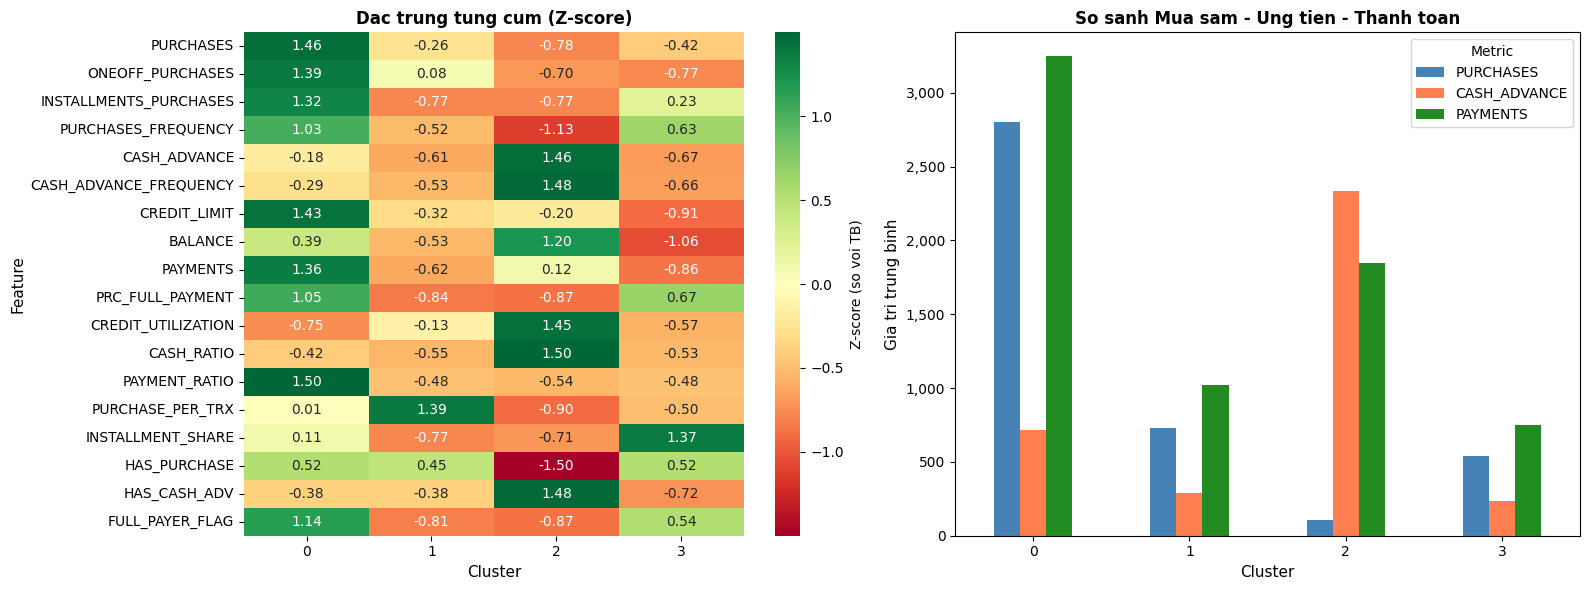

In [41]:
# ============================================================================
# TRUC QUAN HOA DAC TRUNG TUNG CUM (Marketing-first)
# ============================================================================

import numpy as np

# Chon cac bien quan trong de phan tich
key_features = [
    'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'PURCHASES_FREQUENCY',
    'CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY',
    'CREDIT_LIMIT', 'BALANCE', 'PAYMENTS', 'PRC_FULL_PAYMENT',
    # ratios + flags (neu co)
    'CREDIT_UTILIZATION', 'CASH_RATIO', 'PAYMENT_RATIO', 'PURCHASE_PER_TRX',
    'INSTALLMENT_SHARE', 'HAS_PURCHASE', 'HAS_CASH_ADV', 'FULL_PAYER_FLAG'
 ]

# Chi lay cac bien co trong df
key_features = [f for f in key_features if f in df_with_clusters.columns]

# Tinh gia tri trung binh cho moi cluster (chuan hoa de so sanh)
cluster_means = df_with_clusters.groupby('Cluster')[key_features].mean()

# Chuan hoa theo z-score de so sanh tren cung thang do
cluster_means_normalized = (cluster_means - cluster_means.mean()) / (cluster_means.std() + 1e-9)

# Ve heatmap + bar chart
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Heatmap
ax1 = axes[0]
sns.heatmap(
    cluster_means_normalized.T, annot=True, fmt='.2f', cmap='RdYlGn',
    center=0, ax=ax1, cbar_kws={'label': 'Z-score (so voi TB)'}
 )
ax1.set_title('Dac trung tung cum (Z-score)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Cluster', fontsize=11)
ax1.set_ylabel('Feature', fontsize=11)

# 2. Bar chart so sanh (neu co)
ax2 = axes[1]
bar_cols = [c for c in ['PURCHASES', 'CASH_ADVANCE', 'PAYMENTS'] if c in cluster_means.columns]
if bar_cols:
    cluster_means[bar_cols].plot(kind='bar', ax=ax2, color=['steelblue','coral','forestgreen'][:len(bar_cols)])
    ax2.set_title('So sanh Mua sam - Ung tien - Thanh toan', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Cluster', fontsize=11)
    ax2.set_ylabel('Gia tri trung binh', fontsize=11)
    ax2.legend(title='Metric')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
else:
    ax2.axis('off')
    ax2.text(0.5, 0.5, 'Khong du cot PURCHASES/CASH_ADVANCE/PAYMENTS de ve bar chart', ha='center', va='center')

plt.tight_layout()
plt.show()

In [42]:
print("=" * 70)
print("MO TA DAC TRUNG TUNG CUM")
print("=" * 70)

for cluster in range(optimal_k):
    cluster_data = df_with_clusters[df_with_clusters['Cluster'] == cluster]
    n_customers = len(cluster_data)
    pct = n_customers / len(df_with_clusters) * 100
    
    avg_balance = cluster_data['BALANCE'].mean()
    avg_purchases = cluster_data['PURCHASES'].mean()
    avg_cash_advance = cluster_data['CASH_ADVANCE'].mean()
    avg_payments = cluster_data['PAYMENTS'].mean()
    avg_credit_limit = cluster_data['CREDIT_LIMIT'].mean()
    avg_prc_full = cluster_data['PRC_FULL_PAYMENT'].mean()
    avg_purchases_freq = cluster_data['PURCHASES_FREQUENCY'].mean()
    avg_cash_freq = cluster_data['CASH_ADVANCE_FREQUENCY'].mean()
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster}: {n_customers:,} khach hang ({pct:.1f}%)")
    print(f"{'='*60}")
    print(f"  So du TB:           ${avg_balance:>10,.0f}")
    print(f"  Mua sam TB:         ${avg_purchases:>10,.0f}")
    print(f"  Ung tien mat TB:    ${avg_cash_advance:>10,.0f}")
    print(f"  Thanh toan TB:      ${avg_payments:>10,.0f}")
    print(f"  Han muc tin dung:   ${avg_credit_limit:>10,.0f}")
    print(f"  Ty le thanh toan day du: {avg_prc_full*100:>6.1f}%")
    print(f"  Tan suat mua sam:   {avg_purchases_freq:>10.2f}")
    print(f"  Tan suat ung tien:  {avg_cash_freq:>10.2f}")
    
    if avg_purchases > cluster_means['PURCHASES'].mean() and avg_cash_advance < cluster_means['CASH_ADVANCE'].mean():
        profile = "KHACH HANG MUA SAM TICH CUC"
    elif avg_cash_advance > cluster_means['CASH_ADVANCE'].mean() and avg_purchases < cluster_means['PURCHASES'].mean():
        profile = "KHACH HANG UNG TIEN MAT (RUI RO)"
    elif avg_balance < cluster_means['BALANCE'].mean() and avg_purchases < cluster_means['PURCHASES'].mean():
        profile = "KHACH HANG IT HOAT DONG"
    elif avg_prc_full > 0.3:
        profile = "KHACH HANG THANH TOAN TOT"
    else:
        profile = "KHACH HANG TRUNG BINH"
    
    print(f"\n  --> NHAN DIEN: {profile}")

MO TA DAC TRUNG TUNG CUM

CLUSTER 0: 2,197 khach hang (24.5%)
  So du TB:           $     1,811
  Mua sam TB:         $     2,804
  Ung tien mat TB:    $       718
  Thanh toan TB:      $     3,247
  Han muc tin dung:   $     6,947
  Ty le thanh toan day du:   27.9%
  Tan suat mua sam:         0.86
  Tan suat ung tien:        0.09

  --> NHAN DIEN: KHACH HANG MUA SAM TICH CUC

CLUSTER 1: 1,593 khach hang (17.8%)
  So du TB:           $     1,148
  Mua sam TB:         $       732
  Ung tien mat TB:    $       291
  Thanh toan TB:      $     1,021
  Han muc tin dung:   $     3,997
  Ty le thanh toan day du:    4.4%
  Tan suat mua sam:         0.30
  Tan suat ung tien:        0.05

  --> NHAN DIEN: KHACH HANG IT HOAT DONG

CLUSTER 2: 2,623 khach hang (29.3%)
  So du TB:           $     2,388
  Mua sam TB:         $       107
  Ung tien mat TB:    $     2,334
  Thanh toan TB:      $     1,848
  Han muc tin dung:   $     4,189
  Ty le thanh toan day du:    4.0%
  Tan suat mua sam:         0

In [43]:
print("=" * 70)
print("TONG KET K-MEANS CLUSTERING (Marketing segmentation)")
print("=" * 70)

# AUTO NAMING: tranh hard-code cluster id (0/1/2/3) bi lech khi rerun
# - Dùng quantile-based rules để đặt tên tương đối (robust hơn)
# - Ưu tiên dùng FLAGS (profiling-only) để tên bám sát persona hơn
profile_cols = [
    'PURCHASES','PURCHASES_FREQUENCY','CASH_ADVANCE','CASH_ADVANCE_FREQUENCY',
    'PRC_FULL_PAYMENT','CREDIT_UTILIZATION','CASH_RATIO','INSTALLMENT_SHARE',
    # profiling flags
    'HAS_PURCHASE','HAS_CASH_ADV','FULL_PAYER_FLAG','HIGH_UTIL_FLAG','CASH_HEAVY_FLAG',
 ]
profile_cols = [c for c in profile_cols if c in df_with_clusters.columns]
cluster_profile_small = df_with_clusters.groupby('Cluster')[profile_cols].mean() if profile_cols else None

cluster_names = {}
if cluster_profile_small is not None and len(profile_cols) > 0:
    # quantile thresholds de dat ten tuong doi (robust hon)
    q75 = cluster_profile_small.quantile(0.75)
    q25 = cluster_profile_small.quantile(0.25)
    
    for c in sorted(cluster_profile_small.index):
        row = cluster_profile_small.loc[c]
        
        # Cash-advance heavy: ưu tiên flag, fallback ratio/amount
        if 'CASH_HEAVY_FLAG' in row.index:
            cash_heavy = row.get('CASH_HEAVY_FLAG', 0) >= q75.get('CASH_HEAVY_FLAG', row.get('CASH_HEAVY_FLAG', 0))
        elif 'CASH_RATIO' in row.index:
            cash_heavy = row.get('CASH_RATIO', 0) >= q75.get('CASH_RATIO', row.get('CASH_RATIO', 0))
        else:
            cash_heavy = row.get('CASH_ADVANCE', 0) >= q75.get('CASH_ADVANCE', row.get('CASH_ADVANCE', 0))
        
        # High spend
        high_spend = row.get('PURCHASES', 0) >= q75.get('PURCHASES', row.get('PURCHASES', 0))
        
        # Full payer: ưu tiên FULL_PAYER_FLAG (persona rõ hơn), fallback PRC_FULL_PAYMENT
        if 'FULL_PAYER_FLAG' in row.index:
            full_payer = row.get('FULL_PAYER_FLAG', 0) >= q75.get('FULL_PAYER_FLAG', row.get('FULL_PAYER_FLAG', 0))
        else:
            full_payer = row.get('PRC_FULL_PAYMENT', 0) >= q75.get('PRC_FULL_PAYMENT', row.get('PRC_FULL_PAYMENT', 0))
        
        # Low activity: tránh chỉ dựa vào 1 biến; xét mua sắm thấp hoặc tần suất thấp
        low_activity = (
            (row.get('HAS_PURCHASE', 1) <= q25.get('HAS_PURCHASE', row.get('HAS_PURCHASE', 1)))
            or (row.get('PURCHASES', 0) <= q25.get('PURCHASES', row.get('PURCHASES', 0)))
            or (row.get('PURCHASES_FREQUENCY', 1) <= q25.get('PURCHASES_FREQUENCY', row.get('PURCHASES_FREQUENCY', 1)))
        )
        
        installment_oriented = row.get('INSTALLMENT_SHARE', 0) >= q75.get('INSTALLMENT_SHARE', row.get('INSTALLMENT_SHARE', 0))
        
        # High utilization: ưu tiên flag, fallback utilization ratio
        if 'HIGH_UTIL_FLAG' in row.index:
            high_util = row.get('HIGH_UTIL_FLAG', 0) >= q75.get('HIGH_UTIL_FLAG', row.get('HIGH_UTIL_FLAG', 0))
        else:
            high_util = row.get('CREDIT_UTILIZATION', 0) >= q75.get('CREDIT_UTILIZATION', row.get('CREDIT_UTILIZATION', 0))
        
        if cash_heavy:
            cluster_names[c] = "Cash-Advance Heavy (Need control)"
        elif low_activity:
            cluster_names[c] = "Low Activity (Activation)"
        elif high_spend and full_payer:
            cluster_names[c] = "High Spend + Full Payer (VIP/Rewards)"
        elif installment_oriented:
            cluster_names[c] = "Installment Oriented (Merchant/BNPL)"
        elif high_util and not full_payer:
            cluster_names[c] = "High Utilization Revolver (Balance mgmt)"
        else:
            cluster_names[c] = "Regular Users (Maintain)"
else:
    # fallback
    for c in range(optimal_k):
        cluster_names[c] = f"Cluster {c}"

print("\nPHAN LOAI CUOI CUNG (Auto-naming):")
print("-" * 70)
for cluster in sorted(pd.Series(kmeans_labels).unique()):
    name = cluster_names.get(cluster, f"Cluster {cluster}")
    count = (kmeans_labels == cluster).sum()
    pct = count / len(kmeans_labels) * 100
    print(f"  Cluster {cluster}: {name:<38} - {count:,} KH ({pct:.1f}%)")

print("\nDANH GIA CHAT LUONG (X_full):")
print("-" * 70)
print(f"  Silhouette Score:      {final_silhouette:.4f}")
print(f"  Calinski-Harabasz:     {final_calinski:,.2f}")
print(f"  Davies-Bouldin:        {final_davies:.4f}")

TONG KET K-MEANS CLUSTERING (Marketing segmentation)

PHAN LOAI CUOI CUNG (Auto-naming):
----------------------------------------------------------------------
  Cluster 0: High Spend + Full Payer (VIP/Rewards)  - 2,197 KH (24.5%)
  Cluster 1: Regular Users (Maintain)               - 1,593 KH (17.8%)
  Cluster 2: Cash-Advance Heavy (Need control)      - 2,623 KH (29.3%)
  Cluster 3: Installment Oriented (Merchant/BNPL)   - 2,537 KH (28.3%)

DANH GIA CHAT LUONG (X_full):
----------------------------------------------------------------------
  Silhouette Score:      0.1847
  Calinski-Harabasz:     1,668.43
  Davies-Bouldin:        1.8458


### **3.2 Hierarchical Clustering (Phân cụm phân cấp)**

Hierarchical Clustering là phương pháp phân cụm tạo ra cây phân cấp (dendrogram) thể hiện mối quan hệ giữa các điểm dữ liệu.

**Có 2 phương pháp chính:**
1. **Agglomerative (Bottom-up)**: Bắt đầu từ mỗi điểm là 1 cụm, sau đó gộp dần
2. **Divisive (Top-down)**: Bắt đầu từ 1 cụm lớn, sau đó chia nhỏ dần

**Các phương pháp tính khoảng cách giữa cụm (Linkage):**
- **Ward**: Tối thiểu hóa tổng phương sai trong cụm (thường cho kết quả tốt nhất)
- **Complete**: Khoảng cách lớn nhất giữa các điểm
- **Average**: Khoảng cách trung bình giữa các điểm
- **Single**: Khoảng cách nhỏ nhất giữa các điểm

**Ưu điểm**: Không cần chọn k trước, trực quan qua dendrogram, phát hiện cấu trúc phân cấp
**Nhược điểm**: Chậm với dữ liệu lớn O(n²), khó thay đổi khi đã gộp/chia

#### **3.2.1 Vẽ Dendrogram để xác định số cụm**

3.2.1 HIERARCHICAL CLUSTERING - DENDROGRAM

[INFO] Sử dụng 2000 mẫu để vẽ dendrogram
[INFO] Đang tính toán linkage matrix với phương pháp Ward...
[OK] Hoàn thành tính toán linkage!


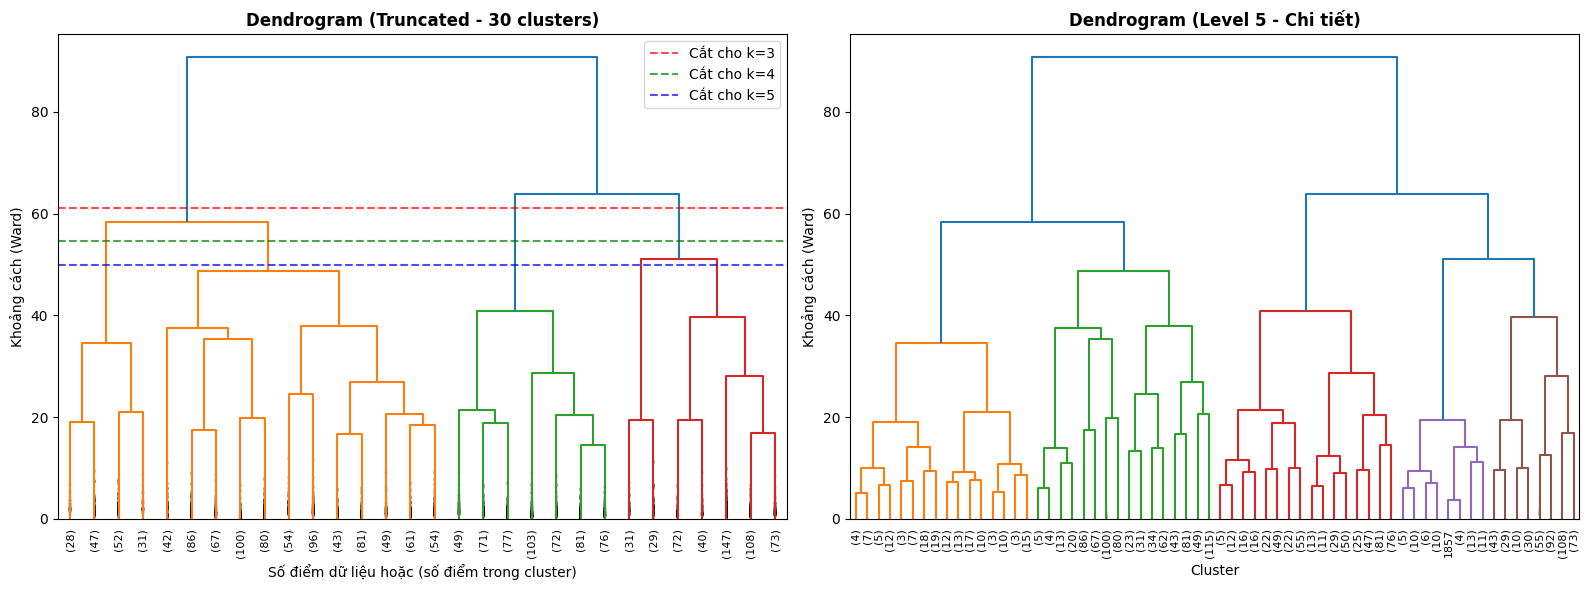


[INFO] Hướng dẫn đọc Dendrogram:
  - Trục Y: Khoảng cách Ward (càng cao = các cụm càng khác biệt)
  - Cắt ngang ở độ cao nhất định sẽ cho số cụm tương ứng
  - Chọn vị trí cắt sao cho các nhánh có chiều cao ĐỒNG ĐỀU


In [44]:
# ============================================================================
# VẼ DENDROGRAM ĐỂ XÁC ĐỊNH SỐ CỤM TỐI ƯU (train/eval space: X_full)
# ============================================================================

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering

print("=" * 70)
print("3.2.1 HIERARCHICAL CLUSTERING - DENDROGRAM")
print("=" * 70)

# Do dữ liệu lớn, lấy mẫu để vẽ dendrogram (nếu cần)
n_samples = min(2000, len(X_full))
np.random.seed(42)
sample_indices = np.random.choice(len(X_full), n_samples, replace=False)
X_sample = X_full[sample_indices]

print(f"\n[INFO] Sử dụng {n_samples} mẫu để vẽ dendrogram")
print("[INFO] Đang tính toán linkage matrix với phương pháp Ward...")

# Tính linkage matrix với phương pháp Ward
linkage_matrix = linkage(X_sample, method='ward')

print("[OK] Hoàn thành tính toán linkage!")

# Vẽ dendrogram
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dendrogram đầy đủ
ax1 = axes[0]
dendrogram(linkage_matrix, ax=ax1, truncate_mode='lastp', p=30, 
           leaf_rotation=90, leaf_font_size=8, show_contracted=True)
ax1.set_title('Dendrogram (Truncated - 30 clusters)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Số điểm dữ liệu hoặc (số điểm trong cluster)', fontsize=10)
ax1.set_ylabel('Khoảng cách (Ward)', fontsize=10)

# Thêm đường cắt gợi ý cho k=3, 4, 5
colors = ['red', 'green', 'blue']
k_suggestions = [3, 4, 5]
# Tìm các mức cắt phù hợp
sorted_distances = sorted(linkage_matrix[:, 2], reverse=True)

for i, k in enumerate(k_suggestions):
    if k-1 < len(sorted_distances):
        cut_distance = (sorted_distances[k-2] + sorted_distances[k-1]) / 2 if k > 1 else sorted_distances[0]
        ax1.axhline(y=cut_distance, color=colors[i], linestyle='--', 
                   label=f'Cắt cho k={k}', alpha=0.7)

ax1.legend(loc='upper right')

# Dendrogram đơn giản hơn
ax2 = axes[1]
dendrogram(linkage_matrix, ax=ax2, truncate_mode='level', p=5,
           leaf_rotation=90, leaf_font_size=8, show_contracted=True,
           color_threshold=sorted_distances[3] if len(sorted_distances) > 3 else 0)
ax2.set_title('Dendrogram (Level 5 - Chi tiết)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Cluster', fontsize=10)
ax2.set_ylabel('Khoảng cách (Ward)', fontsize=10)

plt.tight_layout()
plt.show()

print("\n[INFO] Hướng dẫn đọc Dendrogram:")
print("  - Trục Y: Khoảng cách Ward (càng cao = các cụm càng khác biệt)")
print("  - Cắt ngang ở độ cao nhất định sẽ cho số cụm tương ứng")
print("  - Chọn vị trí cắt sao cho các nhánh có chiều cao ĐỒNG ĐỀU")

#### **3.2.2 So sánh các phương pháp Linkage**

3.2.2 SO SÁNH CÁC PHƯƠNG PHÁP LINKAGE

[INFO] Đang so sánh các phương pháp linkage...

  Đang tính: WARD

  Đang tính: COMPLETE

  Đang tính: AVERAGE

  Đang tính: SINGLE

[OK] Hoàn thành so sánh!


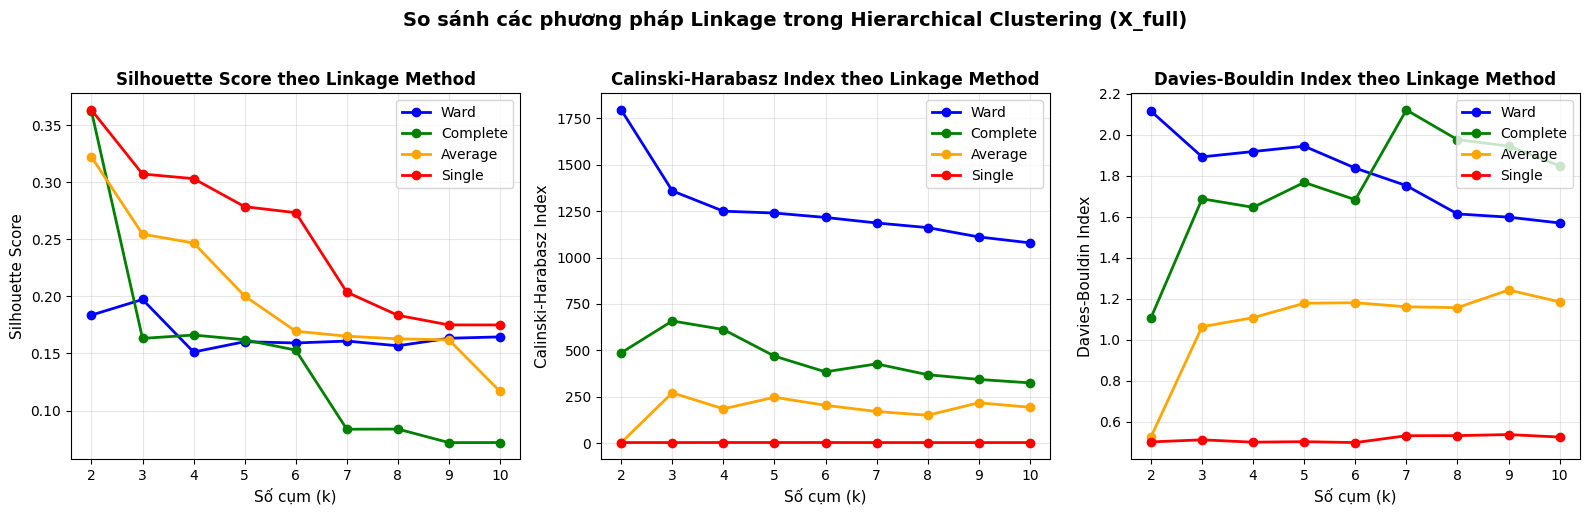


BẢNG SO SÁNH CHI TIẾT (k=4)

Linkage      |   Silhouette |  Calinski-Harabasz | Davies-Bouldin
----------------------------------------------------------------------
Ward         |       0.1513 |           1,250.10 |         1.9186
Complete     |       0.1662 |             612.50 |         1.6464
Average      |       0.2469 |             185.20 |         1.1080
Single       |       0.3033 |               3.80 |         0.5005


In [45]:
# ============================================================================
# SO SÁNH CÁC PHƯƠNG PHÁP LINKAGE (tren X_full de so sanh cong bang voi K-Means)
# ============================================================================

print("=" * 70)
print("3.2.2 SO SÁNH CÁC PHƯƠNG PHÁP LINKAGE")
print("=" * 70)

linkage_methods = ['ward', 'complete', 'average', 'single']
k_range_hier = range(2, 11)

# Lưu kết quả
hier_results = {method: {'silhouette': [], 'calinski': [], 'davies': []} for method in linkage_methods}

print("\n[INFO] Đang so sánh các phương pháp linkage...")

for method in linkage_methods:
    print(f"\n  Đang tính: {method.upper()}")
    
    for k in k_range_hier:
        # Train Agglomerative Clustering
        agg_clustering = AgglomerativeClustering(n_clusters=k, linkage=method)
        labels = agg_clustering.fit_predict(X_full)
        
        # Tính metrics (tren X_full)
        sil = silhouette_score(X_full, labels)
        cal = calinski_harabasz_score(X_full, labels)
        dav = davies_bouldin_score(X_full, labels)
        
        hier_results[method]['silhouette'].append(sil)
        hier_results[method]['calinski'].append(cal)
        hier_results[method]['davies'].append(dav)

print("\n[OK] Hoàn thành so sánh!")

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors_linkage = {'ward': 'blue', 'complete': 'green', 'average': 'orange', 'single': 'red'}

# Silhouette Score
ax1 = axes[0]
for method in linkage_methods:
    ax1.plot(k_range_hier, hier_results[method]['silhouette'], 
             'o-', label=method.capitalize(), color=colors_linkage[method], linewidth=2)
ax1.set_xlabel('Số cụm (k)', fontsize=11)
ax1.set_ylabel('Silhouette Score', fontsize=11)
ax1.set_title('Silhouette Score theo Linkage Method', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Calinski-Harabasz Index
ax2 = axes[1]
for method in linkage_methods:
    ax2.plot(k_range_hier, hier_results[method]['calinski'], 
             'o-', label=method.capitalize(), color=colors_linkage[method], linewidth=2)
ax2.set_xlabel('Số cụm (k)', fontsize=11)
ax2.set_ylabel('Calinski-Harabasz Index', fontsize=11)
ax2.set_title('Calinski-Harabasz Index theo Linkage Method', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Davies-Bouldin Index
ax3 = axes[2]
for method in linkage_methods:
    ax3.plot(k_range_hier, hier_results[method]['davies'], 
             'o-', label=method.capitalize(), color=colors_linkage[method], linewidth=2)
ax3.set_xlabel('Số cụm (k)', fontsize=11)
ax3.set_ylabel('Davies-Bouldin Index', fontsize=11)
ax3.set_title('Davies-Bouldin Index theo Linkage Method', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.suptitle('So sánh các phương pháp Linkage trong Hierarchical Clustering (X_full)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Tìm phương pháp và k tốt nhất
print("\n" + "=" * 70)
print("BẢNG SO SÁNH CHI TIẾT (k=4)")
print("=" * 70)
print(f"\n{'Linkage':<12} | {'Silhouette':>12} | {'Calinski-Harabasz':>18} | {'Davies-Bouldin':>14}")
print("-" * 70)

for method in linkage_methods:
    idx = 2  # k=4 (index 2 trong range 2-10)
    sil = hier_results[method]['silhouette'][idx]
    cal = hier_results[method]['calinski'][idx]
    dav = hier_results[method]['davies'][idx]
    print(f"{method.capitalize():<12} | {sil:>12.4f} | {cal:>18,.2f} | {dav:>14.4f}")

#### **3.2.3 Train Hierarchical Clustering với k=4 (Ward linkage)**

In [46]:
# ============================================================================
# TRAIN HIERARCHICAL CLUSTERING VỚI K TỐI ƯU (train/eval tren X_full)
# ============================================================================

print("=" * 70)
print("3.2.3 TRAIN HIERARCHICAL CLUSTERING (WARD, k=4)")
print("=" * 70)

# Sử dụng cùng k với K-Means để so sánh
hier_k = 4
hier_linkage = 'ward'

print(f"\n[INFO] Cấu hình:")
print(f"  - Số cụm: k = {hier_k}")
print(f"  - Phương pháp linkage: {hier_linkage}")
print("  - Input space: X_full (scaled features)")

# Train model
hier_model = AgglomerativeClustering(n_clusters=hier_k, linkage=hier_linkage)
hier_labels = hier_model.fit_predict(X_full)

# Tính metrics (tren X_full)
hier_silhouette = silhouette_score(X_full, hier_labels)
hier_calinski = calinski_harabasz_score(X_full, hier_labels)
hier_davies = davies_bouldin_score(X_full, hier_labels)

print("\n[OK] Hoàn thành training!")
print("\n" + "-" * 70)
print("ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM:")
print("-" * 70)
print(f"  Silhouette Score:      {hier_silhouette:.4f}")
print(f"  Calinski-Harabasz:     {hier_calinski:,.2f}")
print(f"  Davies-Bouldin:        {hier_davies:.4f}")

# Phân phối cụm
print("\n" + "-" * 70)
print("PHÂN PHỐI CÁC CỤM:")
print("-" * 70)

hier_cluster_counts = pd.Series(hier_labels).value_counts().sort_index()
for cluster, count in hier_cluster_counts.items():
    pct = count / len(hier_labels) * 100
    bar = '█' * int(pct / 2)
    print(f"  Cluster {cluster}: {count:>5,} khách hàng ({pct:>5.1f}%) {bar}")

3.2.3 TRAIN HIERARCHICAL CLUSTERING (WARD, k=4)

[INFO] Cấu hình:
  - Số cụm: k = 4
  - Phương pháp linkage: ward
  - Input space: X_full (scaled features)

[OK] Hoàn thành training!

----------------------------------------------------------------------
ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM:
----------------------------------------------------------------------
  Silhouette Score:      0.1513
  Calinski-Harabasz:     1,250.10
  Davies-Bouldin:        1.9186

----------------------------------------------------------------------
PHÂN PHỐI CÁC CỤM:
----------------------------------------------------------------------
  Cluster 0: 3,541 khách hàng ( 39.6%) ███████████████████
  Cluster 1: 2,871 khách hàng ( 32.1%) ████████████████
  Cluster 2:   762 khách hàng (  8.5%) ████
  Cluster 3: 1,776 khách hàng ( 19.8%) █████████


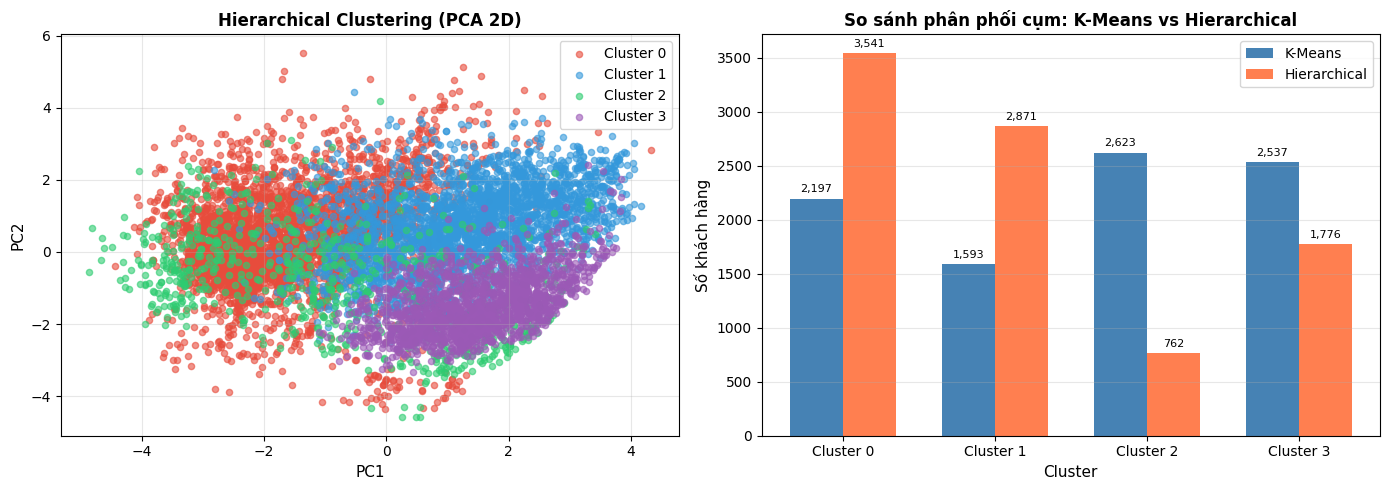

In [47]:
# ============================================================================
# TRỰC QUAN HÓA KẾT QUẢ HIERARCHICAL CLUSTERING
# ============================================================================

# Thêm labels vào dataframe
df_with_hier = df_with_clusters.copy()
df_with_hier['Hier_Cluster'] = hier_labels

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Scatter plot trên PCA 2D
ax1 = axes[0]
colors_hier = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']
for cluster in range(hier_k):
    mask = hier_labels == cluster
    ax1.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                c=colors_hier[cluster], label=f'Cluster {cluster}', 
                alpha=0.6, s=20)

ax1.set_xlabel('PC1', fontsize=11)
ax1.set_ylabel('PC2', fontsize=11)
ax1.set_title('Hierarchical Clustering (PCA 2D)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. So sánh phân phối cụm giữa K-Means và Hierarchical
ax2 = axes[1]
x = np.arange(hier_k)
width = 0.35

kmeans_counts = pd.Series(kmeans_labels).value_counts().sort_index().values
hier_counts = hier_cluster_counts.values

bars1 = ax2.bar(x - width/2, kmeans_counts, width, label='K-Means', color='steelblue')
bars2 = ax2.bar(x + width/2, hier_counts, width, label='Hierarchical', color='coral')

ax2.set_xlabel('Cluster', fontsize=11)
ax2.set_ylabel('Số khách hàng', fontsize=11)
ax2.set_title('So sánh phân phối cụm: K-Means vs Hierarchical', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f'Cluster {i}' for i in range(hier_k)])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Thêm số liệu trên cột
for bar in bars1:
    height = bar.get_height()
    ax2.annotate(f'{int(height):,}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{int(height):,}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

#### **3.2.4 Phân tích đặc trưng các cụm Hierarchical Clustering**

In [48]:
# ============================================================================
# PHÂN TÍCH ĐẶC TRƯNG CÁC CỤM HIERARCHICAL CLUSTERING
# ============================================================================

print("=" * 70)
print("3.2.4 PHÂN TÍCH ĐẶC TRƯNG CÁC CỤM (HIERARCHICAL)")
print("=" * 70)

# Tính thống kê cho từng cụm
hier_cluster_means = df_with_hier.groupby('Hier_Cluster')[key_features].mean()

print("\nGIÁ TRỊ TRUNG BÌNH CỦA CÁC FEATURE CHÍNH THEO CỤM:")
print("-" * 70)
display(hier_cluster_means.round(2))

# Mô tả từng cụm
print("\n" + "=" * 70)
print("MÔ TẢ ĐẶC TRƯNG TỪNG CỤM (HIERARCHICAL)")
print("=" * 70)

for cluster in range(hier_k):
    cluster_data = df_with_hier[df_with_hier['Hier_Cluster'] == cluster]
    n_customers = len(cluster_data)
    pct = n_customers / len(df_with_hier) * 100
    
    avg_balance = cluster_data['BALANCE'].mean()
    avg_purchases = cluster_data['PURCHASES'].mean()
    avg_cash_advance = cluster_data['CASH_ADVANCE'].mean()
    avg_payments = cluster_data['PAYMENTS'].mean()
    avg_credit_limit = cluster_data['CREDIT_LIMIT'].mean()
    avg_prc_full = cluster_data['PRC_FULL_PAYMENT'].mean()
    
    print(f"\n{'='*60}")
    print(f"HIER CLUSTER {cluster}: {n_customers:,} khách hàng ({pct:.1f}%)")
    print(f"{'='*60}")
    print(f"  Số dư TB:           ${avg_balance:>10,.0f}")
    print(f"  Mua sắm TB:         ${avg_purchases:>10,.0f}")
    print(f"  Ứng tiền mặt TB:    ${avg_cash_advance:>10,.0f}")
    print(f"  Thanh toán TB:      ${avg_payments:>10,.0f}")
    print(f"  Hạn mức tín dụng:   ${avg_credit_limit:>10,.0f}")
    print(f"  Tỷ lệ thanh toán đầy đủ: {avg_prc_full*100:>6.1f}%")
    
    # Phân loại tự động
    overall_mean = df_with_hier[['PURCHASES', 'CASH_ADVANCE', 'BALANCE']].mean()
    if avg_purchases > overall_mean['PURCHASES'] and avg_cash_advance < overall_mean['CASH_ADVANCE']:
        profile = "KHÁCH HÀNG MUA SẮM TÍCH CỰC"
    elif avg_cash_advance > overall_mean['CASH_ADVANCE'] and avg_purchases < overall_mean['PURCHASES']:
        profile = "KHÁCH HÀNG ỨNG TIỀN MẶT (RỦI RO)"
    elif avg_balance < overall_mean['BALANCE'] and avg_purchases < overall_mean['PURCHASES']:
        profile = "KHÁCH HÀNG ÍT HOẠT ĐỘNG"
    elif avg_prc_full > 0.3:
        profile = "KHÁCH HÀNG THANH TOÁN TỐT"
    else:
        profile = "KHÁCH HÀNG TRUNG BÌNH"
    
    print(f"\n  --> NHẬN DIỆN: {profile}")

3.2.4 PHÂN TÍCH ĐẶC TRƯNG CÁC CỤM (HIERARCHICAL)

GIÁ TRỊ TRUNG BÌNH CỦA CÁC FEATURE CHÍNH THEO CỤM:
----------------------------------------------------------------------


PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  \
Hier_Cluster                                                        
0                394.70            367.43                   27.32   
1               2169.93           1335.39                  834.67   
2                436.87            209.20                  228.06   
3                573.35              4.46                  569.93   

              PURCHASES_FREQUENCY  CASH_ADVANCE  CASH_ADVANCE_FREQUENCY  \
Hier_Cluster                                                              
0                            0.15       1389.67                    0.19   
1                            0.78        901.52                    0.12   
2                            0.48       1462.78                    0.22   
3                            0.70         77.24                    0.01   

              CREDIT_LIMIT  BALANCE  PAYMENTS  PRC_FULL_PAYMENT  \
Hier_Cluster                                                      
0                  4278.22  1871.82   1615.85              0.04   
1                  5870.79  1870.15   2632.76              0.21   
2                  2829.82  1095.77    823.91              0.20   
3                  3414.73   658.64    902.84              0.28   

              CREDIT_UTILIZATION  CASH_RATIO  PAYMENT_RATIO  PURCHASE_PER_TRX  \
Hier_Cluster                                                                    
0                           0.49        0.33           2.96             92.84   
1                           0.36        0.17           4.87             71.56   
2                           0.35        0.44           3.11             47.71   
3                           0.24        0.02           3.42             51.00   

              INSTALLMENT_SHARE  HAS_PURCHASE  HAS_CASH_ADV  FULL_PAYER_FLAG  
Hier_Cluster                                                                  
0                          0.02          0.49          0.72             0.01  
1                          0.47          1.00          0.40             0.13  
2                          0.42          0.69          0.59             0.12  
3                          0.99          1.00          0.10             0.15


MÔ TẢ ĐẶC TRƯNG TỪNG CỤM (HIERARCHICAL)

HIER CLUSTER 0: 3,541 khách hàng (39.6%)
  Số dư TB:           $     1,872
  Mua sắm TB:         $       395
  Ứng tiền mặt TB:    $     1,390
  Thanh toán TB:      $     1,616
  Hạn mức tín dụng:   $     4,278
  Tỷ lệ thanh toán đầy đủ:    4.1%

  --> NHẬN DIỆN: KHÁCH HÀNG ỨNG TIỀN MẶT (RỦI RO)

HIER CLUSTER 1: 2,871 khách hàng (32.1%)
  Số dư TB:           $     1,870
  Mua sắm TB:         $     2,170
  Ứng tiền mặt TB:    $       902
  Thanh toán TB:      $     2,633
  Hạn mức tín dụng:   $     5,871
  Tỷ lệ thanh toán đầy đủ:   20.6%

  --> NHẬN DIỆN: KHÁCH HÀNG MUA SẮM TÍCH CỰC

HIER CLUSTER 2: 762 khách hàng (8.5%)
  Số dư TB:           $     1,096
  Mua sắm TB:         $       437
  Ứng tiền mặt TB:    $     1,463
  Thanh toán TB:      $       824
  Hạn mức tín dụng:   $     2,830
  Tỷ lệ thanh toán đầy đủ:   19.8%

  --> NHẬN DIỆN: KHÁCH HÀNG ỨNG TIỀN MẶT (RỦI RO)

HIER CLUSTER 3: 1,776 khách hàng (19.8%)
  Số dư TB:           $       6

#### **3.2.5 Tổng kết HIERARCHICAL CLUSTERING**

In [49]:
# ============================================================================
# TỔNG KẾT HIERARCHICAL CLUSTERING (Auto-naming giong K-Means de tranh trung ten)
# ============================================================================

print("=" * 70)
print("TỔNG KẾT HIERARCHICAL CLUSTERING")
print("=" * 70)

# AUTO NAMING (quantile-based)
profile_cols = [
    'PURCHASES','PURCHASES_FREQUENCY','CASH_ADVANCE','CASH_ADVANCE_FREQUENCY',
    'PRC_FULL_PAYMENT','CREDIT_UTILIZATION','CASH_RATIO','INSTALLMENT_SHARE',
    # profiling flags
    'HAS_PURCHASE','HAS_CASH_ADV','FULL_PAYER_FLAG','HIGH_UTIL_FLAG','CASH_HEAVY_FLAG',
 ]
profile_cols = [c for c in profile_cols if c in df_with_hier.columns]

hier_cluster_names = {}
if profile_cols:
    cluster_profile_small = df_with_hier.groupby('Hier_Cluster')[profile_cols].mean()
    q75 = cluster_profile_small.quantile(0.75)
    q25 = cluster_profile_small.quantile(0.25)
    
    for c in sorted(cluster_profile_small.index):
        row = cluster_profile_small.loc[c]
        
        if 'CASH_HEAVY_FLAG' in row.index:
            cash_heavy = row.get('CASH_HEAVY_FLAG', 0) >= q75.get('CASH_HEAVY_FLAG', row.get('CASH_HEAVY_FLAG', 0))
        elif 'CASH_RATIO' in row.index:
            cash_heavy = row.get('CASH_RATIO', 0) >= q75.get('CASH_RATIO', row.get('CASH_RATIO', 0))
        else:
            cash_heavy = row.get('CASH_ADVANCE', 0) >= q75.get('CASH_ADVANCE', row.get('CASH_ADVANCE', 0))
        
        high_spend = row.get('PURCHASES', 0) >= q75.get('PURCHASES', row.get('PURCHASES', 0))
        
        if 'FULL_PAYER_FLAG' in row.index:
            full_payer = row.get('FULL_PAYER_FLAG', 0) >= q75.get('FULL_PAYER_FLAG', row.get('FULL_PAYER_FLAG', 0))
        else:
            full_payer = row.get('PRC_FULL_PAYMENT', 0) >= q75.get('PRC_FULL_PAYMENT', row.get('PRC_FULL_PAYMENT', 0))
        
        low_activity = (
            (row.get('HAS_PURCHASE', 1) <= q25.get('HAS_PURCHASE', row.get('HAS_PURCHASE', 1)))
            or (row.get('PURCHASES', 0) <= q25.get('PURCHASES', row.get('PURCHASES', 0)))
            or (row.get('PURCHASES_FREQUENCY', 1) <= q25.get('PURCHASES_FREQUENCY', row.get('PURCHASES_FREQUENCY', 1)))
        )
        
        installment_oriented = row.get('INSTALLMENT_SHARE', 0) >= q75.get('INSTALLMENT_SHARE', row.get('INSTALLMENT_SHARE', 0))
        
        if 'HIGH_UTIL_FLAG' in row.index:
            high_util = row.get('HIGH_UTIL_FLAG', 0) >= q75.get('HIGH_UTIL_FLAG', row.get('HIGH_UTIL_FLAG', 0))
        else:
            high_util = row.get('CREDIT_UTILIZATION', 0) >= q75.get('CREDIT_UTILIZATION', row.get('CREDIT_UTILIZATION', 0))
        
        if cash_heavy:
            hier_cluster_names[c] = "Cash-Advance Heavy (Need control)"
        elif low_activity:
            hier_cluster_names[c] = "Low Activity (Activation)"
        elif high_spend and full_payer:
            hier_cluster_names[c] = "High Spend + Full Payer (VIP/Rewards)"
        elif installment_oriented:
            hier_cluster_names[c] = "Installment Oriented (Merchant/BNPL)"
        elif high_util and not full_payer:
            hier_cluster_names[c] = "High Utilization Revolver (Balance mgmt)"
        else:
            hier_cluster_names[c] = "Regular Users (Maintain)"
else:
    for c in range(hier_k):
        hier_cluster_names[c] = f"Cluster {c}"

print("\nPHÂN LOẠI CUỐI CÙNG (HIERARCHICAL - Auto-naming):")
print("-" * 70)
for cluster in sorted(pd.Series(hier_labels).unique()):
    name = hier_cluster_names.get(cluster, f"Cluster {cluster}")
    count = (hier_labels == cluster).sum()
    pct = count / len(hier_labels) * 100
    print(f"  Cluster {cluster}: {name:<38} - {count:,} KH ({pct:.1f}%)")

print("\nĐÁNH GIÁ CHẤT LƯỢNG (X_full):")
print("-" * 70)
print(f"  Silhouette Score:      {hier_silhouette:.4f}")
print(f"  Calinski-Harabasz:     {hier_calinski:,.2f}")
print(f"  Davies-Bouldin:        {hier_davies:.4f}")

TỔNG KẾT HIERARCHICAL CLUSTERING

PHÂN LOẠI CUỐI CÙNG (HIERARCHICAL - Auto-naming):
----------------------------------------------------------------------
  Cluster 0: Low Activity (Activation)              - 3,541 KH (39.6%)
  Cluster 1: Regular Users (Maintain)               - 2,871 KH (32.1%)
  Cluster 2: Cash-Advance Heavy (Need control)      - 762 KH (8.5%)
  Cluster 3: Installment Oriented (Merchant/BNPL)   - 1,776 KH (19.8%)

ĐÁNH GIÁ CHẤT LƯỢNG (X_full):
----------------------------------------------------------------------
  Silhouette Score:      0.1513
  Calinski-Harabasz:     1,250.10
  Davies-Bouldin:        1.9186


### **3.3 So sánh K-Means vs Hierarchical Clustering**

3.2.5 SO SÁNH K-MEANS vs HIERARCHICAL CLUSTERING

BẢNG SO SÁNH CHẤT LƯỢNG PHÂN CỤM:
----------------------------------------------------------------------


Metric      K-Means  Hierarchical  Tốt hơn
0         Silhouette Score     0.184731      0.151296  K-Means
1  Calinski-Harabasz Index  1668.427644   1250.097715  K-Means
2     Davies-Bouldin Index     1.845752      1.918648  K-Means


----------------------------------------------------------------------
ĐỘ TƯƠNG ĐỒNG GIỮA 2 PHƯƠNG PHÁP:
----------------------------------------------------------------------
  Adjusted Rand Index (ARI):         0.4379
  Normalized Mutual Information:     0.4613

  [Giải thích]
  - ARI = 1: Hai phương pháp cho kết quả GIỐNG NHAU hoàn toàn
  - ARI = 0: Hai phương pháp cho kết quả NGẪU NHIÊN
  - ARI = 0.4379: Hai phương pháp có sự KHÁC BIỆT ĐÁNG KỂ

----------------------------------------------------------------------
MA TRẬN SO SÁNH PHÂN CỤM (K-Means vs Hierarchical):
----------------------------------------------------------------------


Hierarchical     0     1    2     3
K-Means                            
0               87  1993   55    62
1             1299   220   74     0
2             2082   201  340     0
3               73   457  293  1714

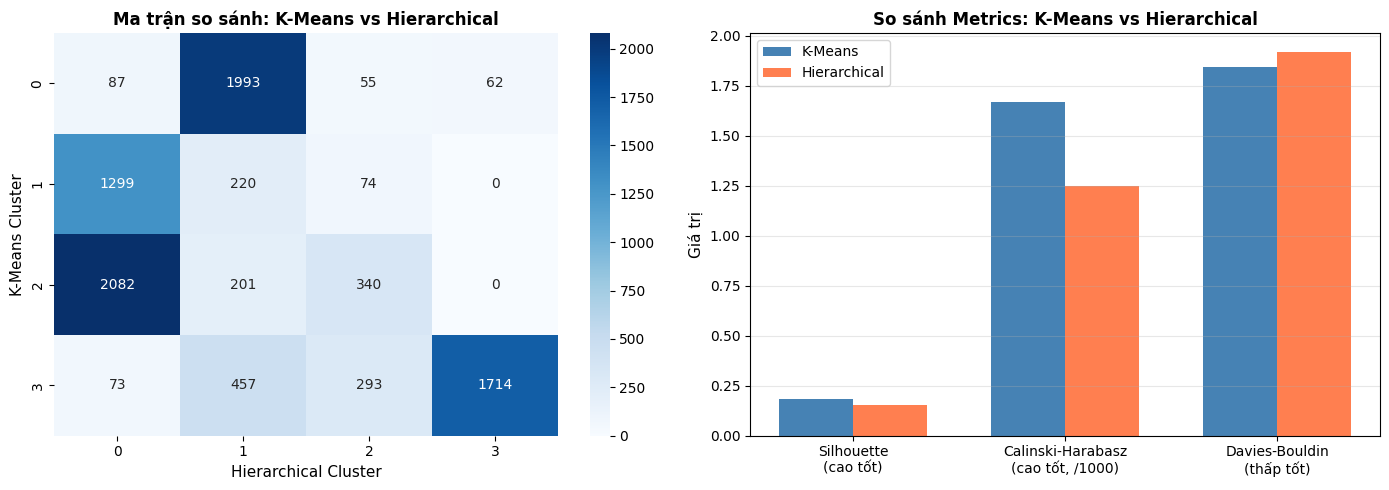


KẾT LUẬN

  ✓ Phương pháp tốt hơn cho bài toán này: K-MEANS
    Lý do: có metrics tổng thể tốt hơn

  ✓ Độ tương đồng giữa 2 phương pháp: 43.8%
    → Cần xem xét kỹ sự khác biệt


In [50]:
# ============================================================================
# SO SÁNH K-MEANS VS HIERARCHICAL CLUSTERING
# ============================================================================

print("=" * 70)
print("3.2.5 SO SÁNH K-MEANS vs HIERARCHICAL CLUSTERING")
print("=" * 70)

# Bảng so sánh metrics
comparison_data = {
    'Metric': ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'],
    'K-Means': [final_silhouette, final_calinski, final_davies],
    'Hierarchical': [hier_silhouette, hier_calinski, hier_davies],
    'Tốt hơn': ['', '', '']
}

# Xác định phương pháp tốt hơn cho từng metric
comparison_data['Tốt hơn'][0] = 'K-Means' if final_silhouette > hier_silhouette else 'Hierarchical'
comparison_data['Tốt hơn'][1] = 'K-Means' if final_calinski > hier_calinski else 'Hierarchical'
comparison_data['Tốt hơn'][2] = 'K-Means' if final_davies < hier_davies else 'Hierarchical'

comparison_df = pd.DataFrame(comparison_data)
print("\nBẢNG SO SÁNH CHẤT LƯỢNG PHÂN CỤM:")
print("-" * 70)
display(comparison_df)

# Adjusted Rand Index - đo độ tương đồng giữa 2 phương pháp phân cụm
ari = adjusted_rand_score(kmeans_labels, hier_labels)
nmi = normalized_mutual_info_score(kmeans_labels, hier_labels)

print("\n" + "-" * 70)
print("ĐỘ TƯƠNG ĐỒNG GIỮA 2 PHƯƠNG PHÁP:")
print("-" * 70)
print(f"  Adjusted Rand Index (ARI):         {ari:.4f}")
print(f"  Normalized Mutual Information:     {nmi:.4f}")
print("\n  [Giải thích]")
print("  - ARI = 1: Hai phương pháp cho kết quả GIỐNG NHAU hoàn toàn")
print("  - ARI = 0: Hai phương pháp cho kết quả NGẪU NHIÊN")
print(f"  - ARI = {ari:.4f}: Hai phương pháp có sự {'TƯƠNG ĐỒNG CAO' if ari > 0.6 else 'KHÁC BIỆT ĐÁNG KỂ'}")

# Confusion matrix giữa 2 phương pháp
print("\n" + "-" * 70)
print("MA TRẬN SO SÁNH PHÂN CỤM (K-Means vs Hierarchical):")
print("-" * 70)
cross_tab = pd.crosstab(kmeans_labels, hier_labels, 
                        rownames=['K-Means'], colnames=['Hierarchical'])
display(cross_tab)

# Trực quan hóa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap của confusion matrix
ax1 = axes[0]
import seaborn as sns
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Ma trận so sánh: K-Means vs Hierarchical', fontsize=12, fontweight='bold')
ax1.set_xlabel('Hierarchical Cluster', fontsize=11)
ax1.set_ylabel('K-Means Cluster', fontsize=11)

# So sánh metrics
ax2 = axes[1]
metrics_names = ['Silhouette\n(cao tốt)', 'Calinski-Harabasz\n(cao tốt, /1000)', 'Davies-Bouldin\n(thấp tốt)']
kmeans_vals = [final_silhouette, final_calinski/1000, final_davies]
hier_vals = [hier_silhouette, hier_calinski/1000, hier_davies]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax2.bar(x - width/2, kmeans_vals, width, label='K-Means', color='steelblue')
bars2 = ax2.bar(x + width/2, hier_vals, width, label='Hierarchical', color='coral')

ax2.set_ylabel('Giá trị', fontsize=11)
ax2.set_title('So sánh Metrics: K-Means vs Hierarchical', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics_names)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Kết luận
print("\n" + "=" * 70)
print("KẾT LUẬN")
print("=" * 70)

kmeans_wins = sum([
    final_silhouette > hier_silhouette,
    final_calinski > hier_calinski,
    final_davies < hier_davies
])

if kmeans_wins >=  2:
    winner = "K-MEANS"
    reason = "có metrics tổng thể tốt hơn"
else:
    winner = "HIERARCHICAL"
    reason = "có metrics tổng thể tốt hơn"

print(f"\n  ✓ Phương pháp tốt hơn cho bài toán này: {winner}")
print(f"    Lý do: {reason}")
print(f"\n  ✓ Độ tương đồng giữa 2 phương pháp: {ari*100:.1f}%")
print(f"    {'→ Có thể sử dụng kết quả của cả 2 để cross-validate' if ari > 0.5 else '→ Cần xem xét kỹ sự khác biệt'}")

### **3.4 Report-ready Visualizations**

Mục tiêu: trực quan hóa **độ tách cụm**, **phân phối & đặc trưng hành vi** theo cluster, và **feature nào phân biệt cụm mạnh nhất** 

3.4 REPORT-READY VISUALIZATIONS


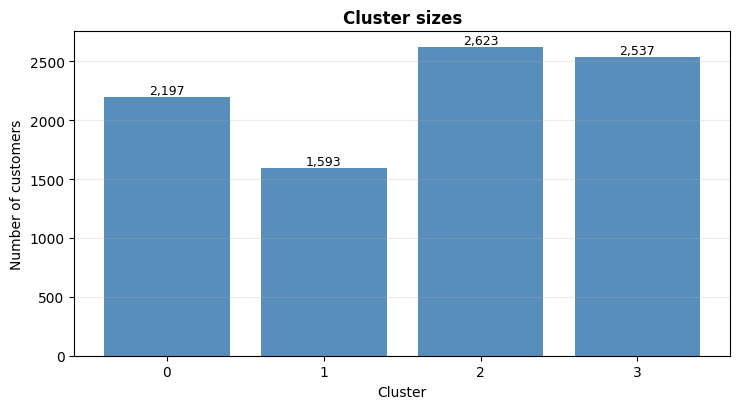

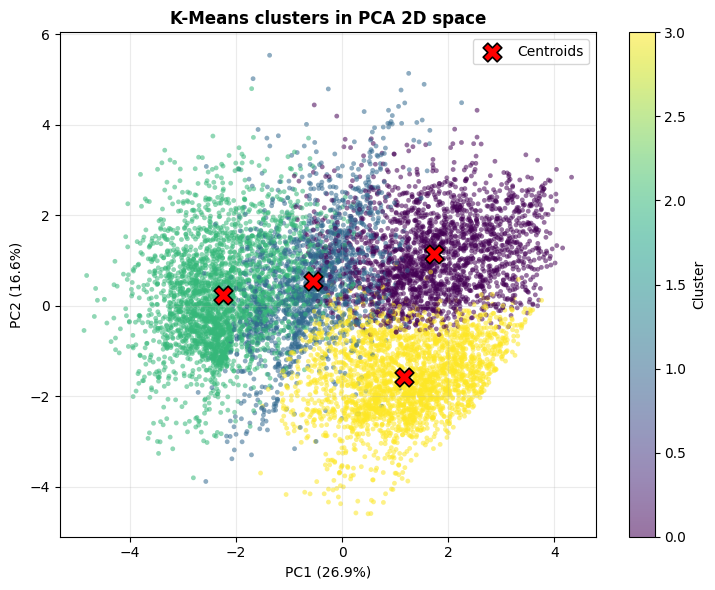

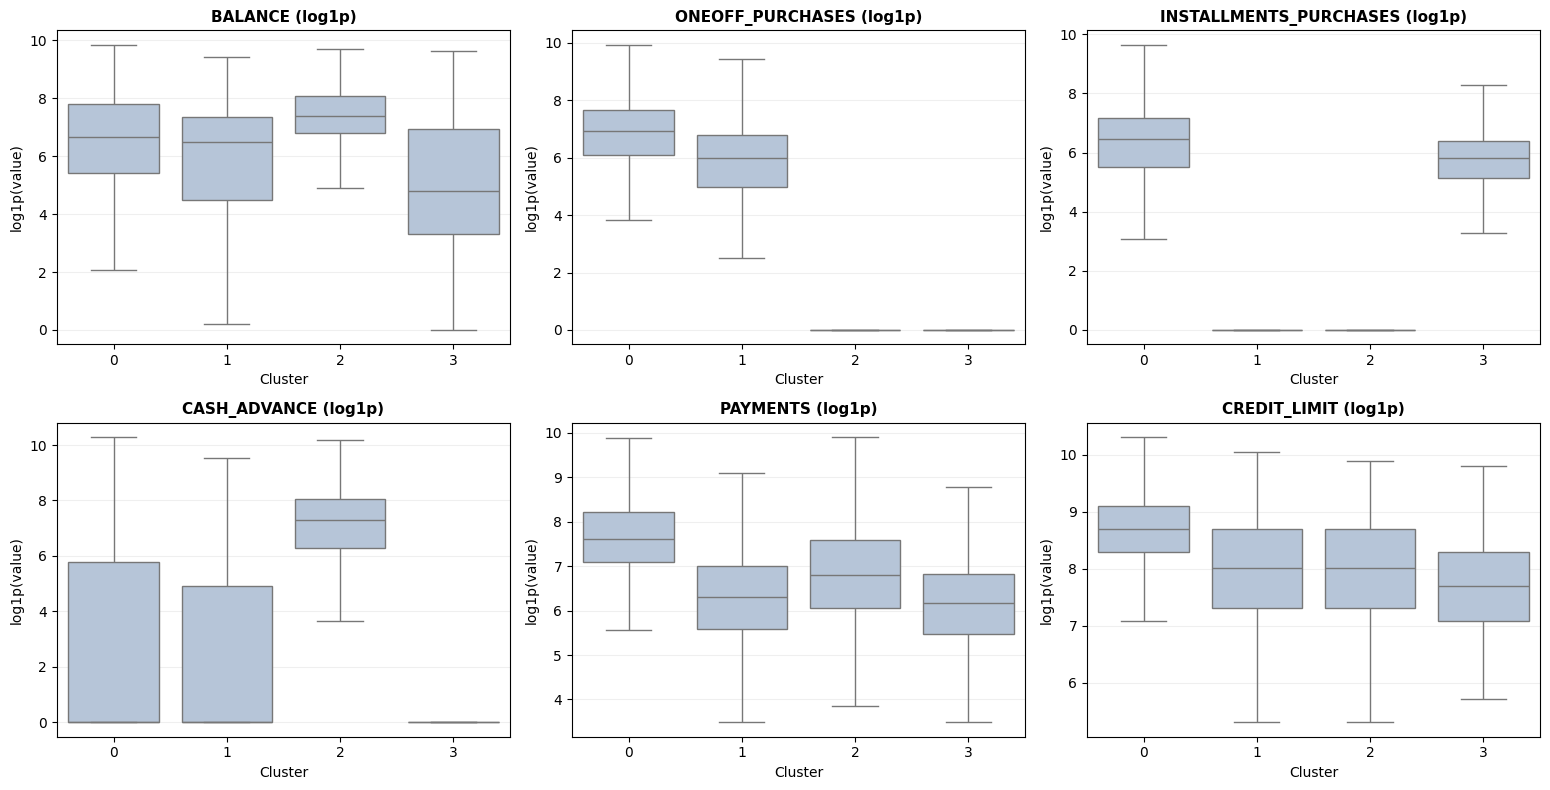

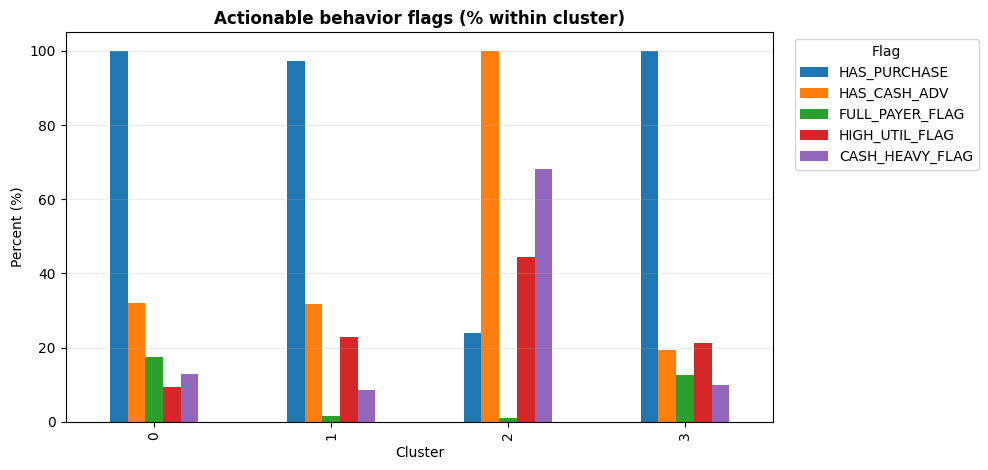

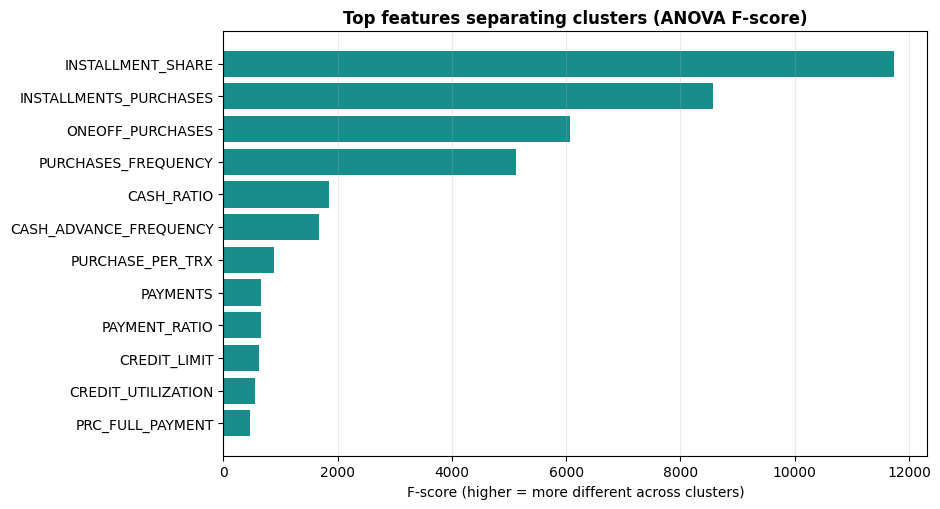


[INFO] Top separating features:


INSTALLMENT_SHARE         11736.44
INSTALLMENTS_PURCHASES     8573.97
ONEOFF_PURCHASES           6069.15
PURCHASES_FREQUENCY        5125.93
CASH_RATIO                 1843.91
CASH_ADVANCE_FREQUENCY     1667.41
PURCHASE_PER_TRX            890.01
PAYMENTS                    658.80
PAYMENT_RATIO               658.70
CREDIT_LIMIT                626.62
CREDIT_UTILIZATION          551.28
PRC_FULL_PAYMENT            461.55
dtype: float64


[OK] Report-ready visualizations generated.


In [51]:

print("=" * 70)
print("3.4 REPORT-READY VISUALIZATIONS")
print("=" * 70)

# --- Guardrails ---
if 'kmeans_labels' not in globals():
    raise RuntimeError("Chưa có kmeans_labels. Hãy chạy cell train K-Means trước.")
if 'df_with_clusters' not in globals():
    raise RuntimeError("Chưa có df_with_clusters. Hãy chạy phần profiling (tạo df_with_clusters) trước.")
if 'X_full' not in globals() or 'X_pca_2d' not in globals() or 'pca_2d' not in globals():
    raise RuntimeError("Thiếu X_full / X_pca_2d / pca_2d. Hãy chạy phần tạo data versions (X_full, PCA 2D) trước.")

labels = pd.Series(kmeans_labels, name='Cluster').astype(int)

# =============== (A) Cluster size distribution ===============
counts = labels.value_counts().sort_index()
fig, ax = plt.subplots(figsize=(7.5, 4.2))
ax.bar(counts.index.astype(str), counts.values, color='steelblue', alpha=0.9)
for i, v in enumerate(counts.values):
    ax.text(i, v, f"{v:,}", ha='center', va='bottom', fontsize=9)
ax.set_title('Cluster sizes', fontsize=12, fontweight='bold')
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of customers')
ax.grid(True, axis='y', alpha=0.25)
plt.tight_layout()
plt.show()

# =============== (B) 2D PCA scatter (cluster separation) ===============
fig, ax = plt.subplots(figsize=(7.5, 6))
scatter = ax.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=labels.values,
    cmap='viridis',
    s=12,
    alpha=0.55,
    edgecolors='none',
)

# Project centroids to PCA2D for reference
try:
    centroids_2d = pca_2d.transform(kmeans_final.cluster_centers_)
    ax.scatter(
        centroids_2d[:, 0],
        centroids_2d[:, 1],
        c='red',
        marker='X',
        s=180,
        edgecolors='black',
        linewidths=1.2,
        label='Centroids',
    )
    ax.legend(loc='best')
except Exception:
    pass

ax.set_title('K-Means clusters in PCA 2D space', fontsize=12, fontweight='bold')
ax.set_xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)")
ax.grid(True, alpha=0.25)
cb = plt.colorbar(scatter, ax=ax)
cb.set_label('Cluster')
plt.tight_layout()
plt.show()

# =============== (C) Key feature distributions (log1p for readability) ===============
amount_cols = [
    c
    for c in ['BALANCE', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PAYMENTS', 'CREDIT_LIMIT']
    if c in df_with_clusters.columns
]

if amount_cols:
    df_plot = df_with_clusters[['Cluster'] + amount_cols].copy()
    for c in amount_cols:
        df_plot[f'log1p_{c}'] = np.log1p(df_plot[c].clip(lower=0))

    n = len(amount_cols)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5.2 * ncols, 4.0 * nrows))
    axes = np.array(axes).reshape(nrows, ncols)

    for i, c in enumerate(amount_cols):
        r, cc = divmod(i, ncols)
        ax = axes[r, cc]
        sns.boxplot(
            data=df_plot,
            x='Cluster',
            y=f'log1p_{c}',
            ax=ax,
            showfliers=False,
            color='lightsteelblue',
        )
        ax.set_title(f'{c} (log1p)', fontsize=11, fontweight='bold')
        ax.set_xlabel('Cluster')
        ax.set_ylabel('log1p(value)')
        ax.grid(True, axis='y', alpha=0.2)

    # Hide unused axes
    for j in range(n, nrows * ncols):
        r, cc = divmod(j, ncols)
        axes[r, cc].axis('off')

    plt.tight_layout()
    plt.show()

# =============== (D) Flags: proportion by cluster (actionability) ===============
flag_cols = [
    c
    for c in ['HAS_PURCHASE', 'HAS_CASH_ADV', 'FULL_PAYER_FLAG', 'HIGH_UTIL_FLAG', 'CASH_HEAVY_FLAG']
    if c in df_with_clusters.columns
]

if flag_cols:
    flag_rate = df_with_clusters.groupby('Cluster')[flag_cols].mean().sort_index() * 100
    fig, ax = plt.subplots(figsize=(10, 4.8))
    flag_rate.plot(kind='bar', ax=ax)
    ax.set_title('Actionable behavior flags (% within cluster)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Percent (%)')
    ax.grid(True, axis='y', alpha=0.25)
    ax.legend(title='Flag', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# =============== (E) Feature separation score (ANOVA F-test) ===============
# Dùng để trả lời: "Feature nào khác biệt mạnh nhất giữa các cluster?" (descriptive)
if 'df_scaled' in globals() and isinstance(globals().get('df_scaled'), pd.DataFrame):
    try:
        from sklearn.feature_selection import f_classif

        X_feat = df_scaled.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        y = labels.values

        f_vals, _p_vals = f_classif(X_feat.values, y)
        scores = pd.Series(f_vals, index=X_feat.columns).replace([np.inf, -np.inf], np.nan).fillna(0.0)
        top = scores.sort_values(ascending=False).head(12)

        fig, ax = plt.subplots(figsize=(9.5, 5.2))
        ax.barh(top.index[::-1], top.values[::-1], color='teal', alpha=0.9)
        ax.set_title('Top features separating clusters (ANOVA F-score)', fontsize=12, fontweight='bold')
        ax.set_xlabel('F-score (higher = more different across clusters)')
        ax.grid(True, axis='x', alpha=0.25)
        plt.tight_layout()
        plt.show()

        print("\n[INFO] Top separating features:")
        display(top.round(2))
    except Exception as e:
        print(f"[WARN] Không tính được ANOVA F-score: {e}")

print("\n[OK] Report-ready visualizations generated.")

### **3.5 STAGE-2 SEGMENTATION - REGULAR USERS (SCORECARD)**
- Tách Regular -> tính Value/Risk/Engagement score (z-score trong subset)

- Chia theo quantile -> 4 sub-persona (High/Low Value x High/Low Risk)

In [52]:
if 'df_with_clusters' not in globals() or not isinstance(globals().get('df_with_clusters'), pd.DataFrame):
    raise RuntimeError("Chưa có df_with_clusters. Hãy chạy K-Means đến phần profiling trước.")

regular_cluster_ids = []
try:
    regular_cluster_ids = [cid for cid, nm in (cluster_names or {}).items() if isinstance(nm, str) and "Regular Users" in nm]
except Exception:
    regular_cluster_ids = []

if not regular_cluster_ids:
    if 'kmeans_labels' in globals():
        regular_cluster_ids = [pd.Series(kmeans_labels).value_counts().idxmax()]
    else:
        regular_cluster_ids = [df_with_clusters['Cluster'].value_counts().idxmax()]

regular_df = df_with_clusters[df_with_clusters['Cluster'].isin(regular_cluster_ids)].copy()

value_feats = [c for c in ['PURCHASES', 'PURCHASES_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS', 'PURCHASE_PER_TRX'] if c in regular_df.columns]
risk_feats_pos = [c for c in ['CREDIT_UTILIZATION', 'CASH_RATIO', 'CASH_ADVANCE_FREQUENCY', 'BALANCE'] if c in regular_df.columns]
risk_feats_neg = [c for c in ['PRC_FULL_PAYMENT', 'PAYMENT_RATIO'] if c in regular_df.columns]
engage_feats = [c for c in ['PURCHASES_FREQUENCY', 'TENURE', 'HAS_PURCHASE'] if c in regular_df.columns]

print(f"[INFO] Regular cluster id(s): {regular_cluster_ids}")
print(f"[INFO] Regular subset size: {len(regular_df):,} / {len(df_with_clusters):,} ({len(regular_df)/len(df_with_clusters)*100:.1f}%)")
print("[INFO] Features used:")
print(f"  Value:  {value_feats}")
print(f"  Risk+:  {risk_feats_pos}")
print(f"  Risk-:  {risk_feats_neg}")
print(f"  Engage: {engage_feats}")

[INFO] Regular cluster id(s): [1]
[INFO] Regular subset size: 1,593 / 8,950 (17.8%)
[INFO] Features used:
  Value:  ['PURCHASES', 'PURCHASES_FREQUENCY', 'CREDIT_LIMIT', 'PAYMENTS', 'PURCHASE_PER_TRX']
  Risk+:  ['CREDIT_UTILIZATION', 'CASH_RATIO', 'CASH_ADVANCE_FREQUENCY', 'BALANCE']
  Risk-:  ['PRC_FULL_PAYMENT', 'PAYMENT_RATIO']
  Engage: ['PURCHASES_FREQUENCY', 'TENURE', 'HAS_PURCHASE']


In [53]:
def _zscore(df_in, cols):
    out = pd.DataFrame(index=df_in.index)
    for col in cols:
        x = df_in[col].astype(float)
        mu = x.mean()
        sd = x.std(ddof=0) + 1e-9
        out[col] = (x - mu) / sd
    return out

z_value = _zscore(regular_df, value_feats) if value_feats else pd.DataFrame(index=regular_df.index)
z_risk_pos = _zscore(regular_df, risk_feats_pos) if risk_feats_pos else pd.DataFrame(index=regular_df.index)
z_risk_neg = _zscore(regular_df, risk_feats_neg) if risk_feats_neg else pd.DataFrame(index=regular_df.index)
z_engage = _zscore(regular_df, engage_feats) if engage_feats else pd.DataFrame(index=regular_df.index)

regular_df['ValueScore'] = z_value.mean(axis=1) if len(z_value.columns) else 0.0
regular_df['RiskScore'] = (z_risk_pos.mean(axis=1) if len(z_risk_pos.columns) else 0.0) - (z_risk_neg.mean(axis=1) if len(z_risk_neg.columns) else 0.0)
regular_df['EngagementScore'] = z_engage.mean(axis=1) if len(z_engage.columns) else 0.0

def _hi_lo(series, label_hi='High', label_lo='Low'):
    s = series.astype(float)
    try:
        return pd.qcut(s.rank(method='first'), q=2, labels=[label_lo, label_hi]).astype(str)
    except Exception:
        thr = s.median()
        return pd.Series(np.where(s >=  thr, label_hi, label_lo), index=s.index)

regular_df['ValueTier'] = _hi_lo(regular_df['ValueScore'])
regular_df['RiskTier'] = _hi_lo(regular_df['RiskScore'])
regular_df['EngageTier'] = _hi_lo(regular_df['EngagementScore'])

regular_df['Regular_Subsegment'] = (
    regular_df['ValueTier'].map({'High': 'HighValue', 'Low': 'LowValue'}).astype(str)
    + "_"
    + regular_df['RiskTier'].map({'High': 'HighRisk', 'Low': 'LowRisk'}).astype(str)
 )

campaign_map = {
    'HighValue_LowRisk':  'Upsell/Rewards: tăng chi tiêu, ưu đãi đối tác, tăng hạn mức có kiểm soát',
    'HighValue_HighRisk': 'Balance mgmt: nhắc trả nợ, hạn mức/chi tiêu an toàn, chuyển đổi trả góp',
    'LowValue_LowRisk':   'Activation nhẹ: deal nhỏ, khuyến khích dùng định kỳ, cross-sell',
    'LowValue_HighRisk':  'Risk control: hạn chế cash, nhắc trả nợ, education về phí/lãi',
}

In [54]:
print("\n[INFO] Subsegment distribution (within Regular):")
sub_counts = regular_df['Regular_Subsegment'].value_counts(dropna=False)
for seg, cnt in sub_counts.items():
    pct = cnt / len(regular_df) * 100
    print(f"  {seg:<18} : {cnt:>5,} KH ({pct:>5.1f}%)")

print("\n[INFO] Mean scores by subsegment:")
display(
    regular_df.groupby('Regular_Subsegment')[['ValueScore', 'RiskScore', 'EngagementScore']]
    .mean()
    .sort_index()
    .round(3)
 )

profile_cols = [
    c for c in [
        'PURCHASES','PURCHASES_FREQUENCY','CASH_ADVANCE','CREDIT_UTILIZATION','CASH_RATIO',
        'PRC_FULL_PAYMENT','PAYMENT_RATIO','INSTALLMENT_SHARE'
    ] if c in regular_df.columns
 ]
if profile_cols:
    print("\n[INFO] Business profile (mean):")
    display(regular_df.groupby('Regular_Subsegment')[profile_cols].mean().sort_index().round(2))

print("\n[INFO] Campaign gợi ý theo subsegment:")
for seg in sorted(sub_counts.index):
    print(f"  - {seg}: {campaign_map.get(seg, 'Maintain')}")


[INFO] Subsegment distribution (within Regular):
  LowValue_LowRisk   :   406 KH ( 25.5%)
  HighValue_HighRisk :   405 KH ( 25.4%)
  LowValue_HighRisk  :   391 KH ( 24.5%)
  HighValue_LowRisk  :   391 KH ( 24.5%)

[INFO] Mean scores by subsegment:


ValueScore  RiskScore  EngagementScore
Regular_Subsegment                                        
HighValue_HighRisk       0.396      0.997            0.275
HighValue_LowRisk        0.372     -1.052            0.152
LowValue_HighRisk       -0.396      0.792           -0.179
LowValue_LowRisk        -0.372     -0.745           -0.248


[INFO] Business profile (mean):


PURCHASES  PURCHASES_FREQUENCY  CASH_ADVANCE  \
Regular_Subsegment                                                 
HighValue_HighRisk    1328.99                 0.48        762.05   
HighValue_LowRisk     1108.89                 0.38        100.56   
LowValue_HighRisk      261.46                 0.19        247.70   
LowValue_LowRisk       227.92                 0.16         44.47   

                    CREDIT_UTILIZATION  CASH_RATIO  PRC_FULL_PAYMENT  \
Regular_Subsegment                                                     
HighValue_HighRisk                0.58        0.13              0.01   
HighValue_LowRisk                 0.13        0.03              0.09   
LowValue_HighRisk                 0.65        0.11              0.00   
LowValue_LowRisk                  0.08        0.02              0.08   

                    PAYMENT_RATIO  INSTALLMENT_SHARE  
Regular_Subsegment                                    
HighValue_HighRisk           1.53               0.04  
HighValue_LowRisk            5.56               0.01  
LowValue_HighRisk            0.99               0.04  
LowValue_LowRisk             3.47               0.01


[INFO] Campaign gợi ý theo subsegment:
  - HighValue_HighRisk: Balance mgmt: nhắc trả nợ, hạn mức/chi tiêu an toàn, chuyển đổi trả góp
  - HighValue_LowRisk: Upsell/Rewards: tăng chi tiêu, ưu đãi đối tác, tăng hạn mức có kiểm soát
  - LowValue_HighRisk: Risk control: hạn chế cash, nhắc trả nợ, education về phí/lãi
  - LowValue_LowRisk: Activation nhẹ: deal nhỏ, khuyến khích dùng định kỳ, cross-sell


[INFO] PCA2 explained variance: 36.42% (PC1=19.67%, PC2=16.75%)


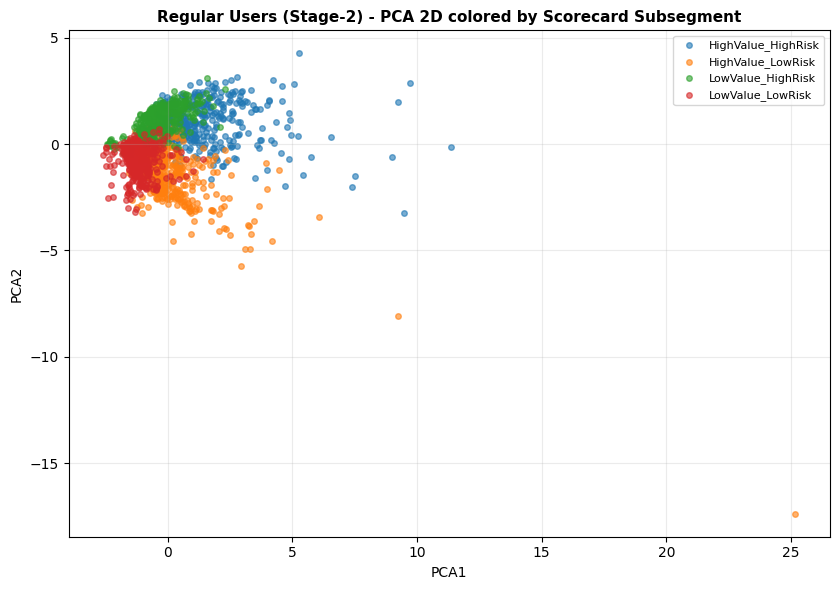


[INFO] PCA loadings:


PCA1_loading  PCA2_loading
PURCHASES                      0.445        -0.161
PAYMENTS                       0.439        -0.291
BALANCE                        0.422         0.336
PURCHASE_PER_TRX               0.370        -0.297
CASH_ADVANCE_FREQUENCY         0.279         0.236
CREDIT_LIMIT                   0.272        -0.155
CASH_RATIO                     0.252         0.173
CREDIT_UTILIZATION             0.199         0.489
HAS_PURCHASE                   0.137         0.034
PURCHASES_FREQUENCY            0.108         0.175
PAYMENT_RATIO                  0.073        -0.488
PRC_FULL_PAYMENT              -0.058        -0.266
TENURE                         0.022         0.013

In [55]:
feat_candidates = []
for lst in [value_feats, risk_feats_pos, risk_feats_neg, engage_feats]:
    feat_candidates += list(lst)
stage2_feats = [c for c in dict.fromkeys(feat_candidates) if c in regular_df.columns]
if len(stage2_feats) < 3:
    stage2_feats = [
        c for c in ['PURCHASES', 'PURCHASES_FREQUENCY', 'CREDIT_UTILIZATION', 'CASH_RATIO', 'PRC_FULL_PAYMENT', 'PAYMENT_RATIO']
        if c in regular_df.columns
    ]

if len(stage2_feats) < 3:
    raise ValueError("Không đủ feature để PCA trong regular_df (cần >=  3 cột).")

X_reg = regular_df[stage2_feats].replace([np.inf, -np.inf], np.nan).fillna(0.0)
scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)

pca_reg_2d = PCA(n_components=2, random_state=42)
X_reg_pca2 = pca_reg_2d.fit_transform(X_reg_scaled)

regular_df['PCA1'] = X_reg_pca2[:, 0]
regular_df['PCA2'] = X_reg_pca2[:, 1]

ev = pca_reg_2d.explained_variance_ratio_
print(f"[INFO] PCA2 explained variance: {(ev.sum()*100):.2f}% (PC1={ev[0]*100:.2f}%, PC2={ev[1]*100:.2f}%)")

fig, ax = plt.subplots(1, 1, figsize=(8.5, 6))
for seg, g in regular_df.groupby('Regular_Subsegment'):
    ax.scatter(g['PCA1'], g['PCA2'], s=16, alpha=0.60, label=seg)
ax.set_title('Regular Users (Stage-2) - PCA 2D colored by Scorecard Subsegment', fontsize=11, fontweight='bold')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.grid(True, alpha=0.25)
ax.legend(fontsize=8, loc='best')
plt.tight_layout()
plt.show()

loadings = pd.DataFrame(
    pca_reg_2d.components_.T,
    index=stage2_feats,
    columns=['PCA1_loading', 'PCA2_loading']
 )
loadings = loadings.assign(abs_PCA1=loadings['PCA1_loading'].abs()).sort_values('abs_PCA1', ascending=False).drop(columns=['abs_PCA1'])

print("\n[INFO] PCA loadings:")
display(loadings.round(3))

## **4. Kết luận & Khuyến nghị triển khai**

### **4.1 Tóm tắt dự án và chất lượng phân khúc**

Dự án áp dụng các kỹ thuật Machine Learning để phân khúc **8,950 khách hàng thẻ tín dụng** thành **k nhóm** dựa trên hành vi sử dụng thẻ:

- **Thuật toán**: K-Means và Hierarchical Clustering (Ward linkage)
- **Training space**: X_full (feature space đã scale) - giữ nguyên ý nghĩa business của features
- **Số cụm k**: Được chọn dựa trên cân bằng giữa metrics kỹ thuật và actionability cho marketing personas

**Lưu ý**: Các giá trị Silhouette Score, ARI, và tỷ lệ phân cụm sẽ được tính toán và hiển thị động từ kết quả clustering thực tế ở các cell code phía dưới.

---

### **4.2 Chân dung phân khúc khách hàng (biểu đồ & insight)**

Phần này trình bày các biểu đồ và phân tích đặc điểm của từng nhóm khách hàng. Tên và đặc trưng từng cụm được auto-naming dựa trên dữ liệu thực tế (sử dụng FLAGS và quantile-based rules) để tránh hard-code bị lệch khi re-run.

#### **4.2.1 Biểu đồ tổng hợp đặc điểm từng nhóm**

Các biểu đồ sau đây thể hiện:
- Phân phối số lượng khách hàng theo nhóm (Pie chart & Bar chart)
- So sánh Mua sắm vs Ứng tiền mặt
- Tỷ lệ thanh toán đầy đủ

**Lưu ý**: Tên cụm và tỷ lệ được lấy trực tiếp từ biến `cluster_names` và `kmeans_labels` đã được auto-naming ở phần 3.

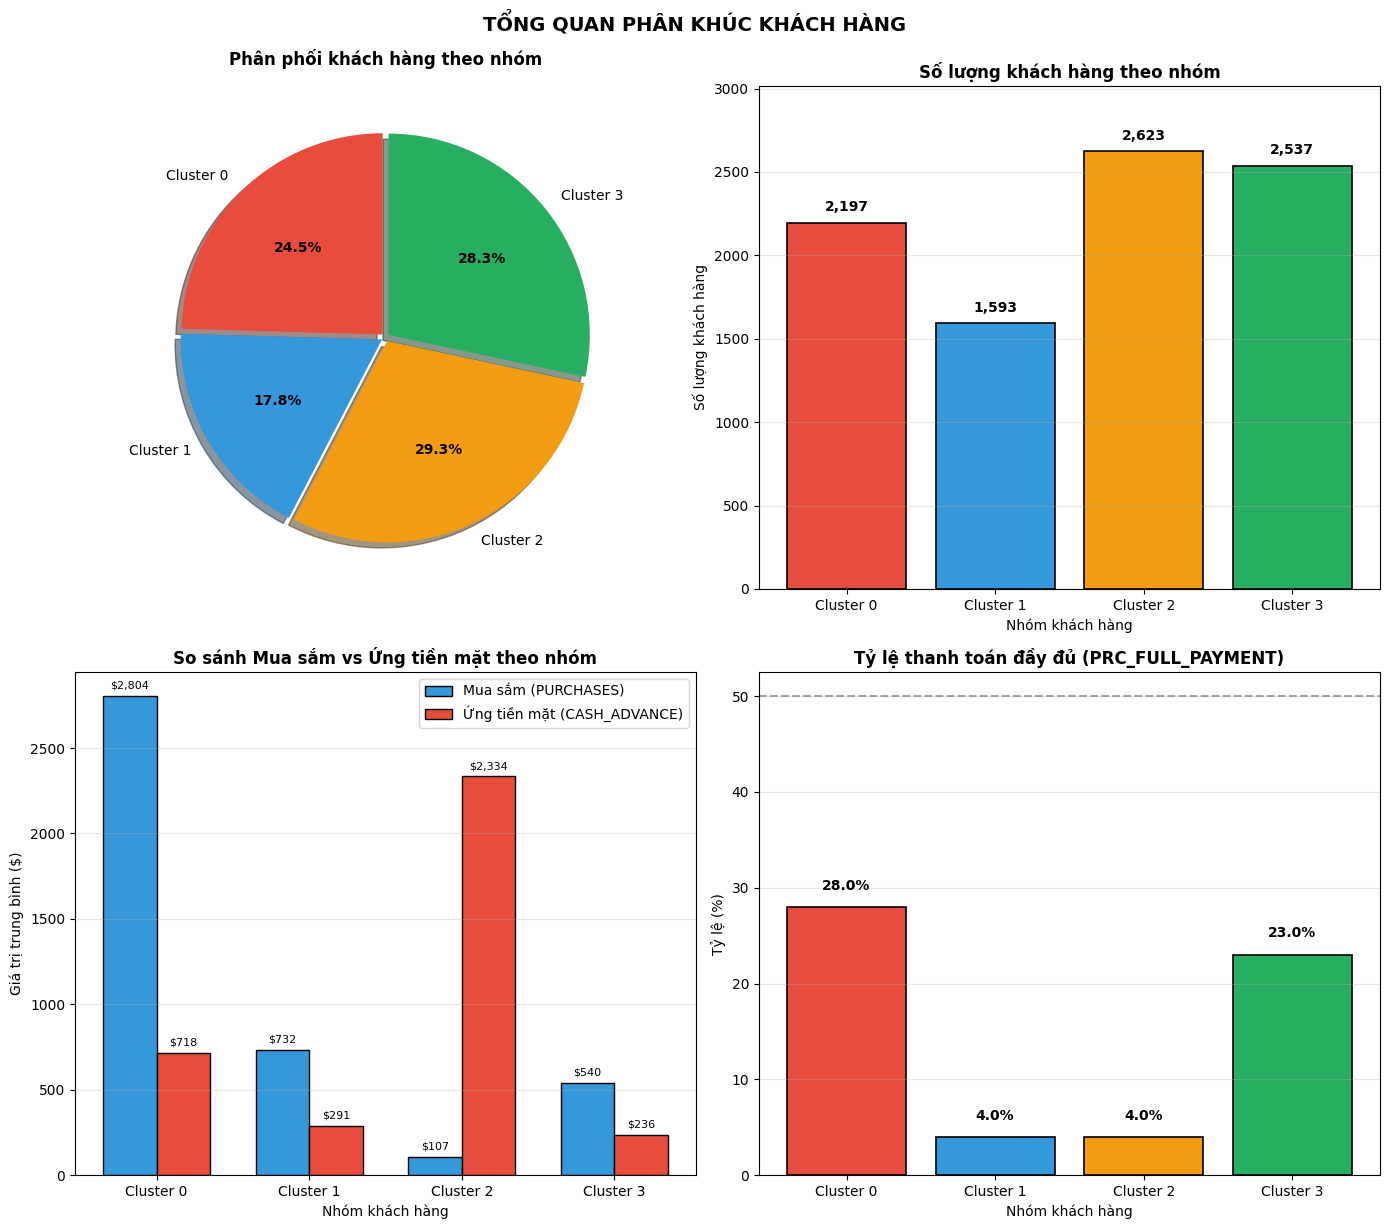


BẢNG TỔNG HỢP ĐẶC ĐIỂM TỪNG NHÓM KHÁCH HÀNG


BALANCE  PURCHASES  \
Cluster                                                                
Cluster 0: High Spend + Full Payer (VIP/Rewards)  1810.87    2804.09   
Cluster 1: Regular Users (Maintain)               1147.74     732.32   
Cluster 2: Cash-Advance Heavy (Need control)      2387.68     107.32   
Cluster 3: Installment Oriented (Merchant/BNPL)    761.67     540.01   

                                                  CASH_ADVANCE  PAYMENTS  \
Cluster                                                                    
Cluster 0: High Spend + Full Payer (VIP/Rewards)        717.93   3247.37   
Cluster 1: Regular Users (Maintain)                     290.55   1020.92   
Cluster 2: Cash-Advance Heavy (Need control)           2334.15   1848.17   
Cluster 3: Installment Oriented (Merchant/BNPL)         235.82    750.13   

                                                  CREDIT_LIMIT  \
Cluster                                                          
Cluster 0: High Spend + Full Payer (VIP/Rewards)       6947.36   
Cluster 1: Regular Users (Maintain)                    3997.20   
Cluster 2: Cash-Advance Heavy (Need control)           4188.57   
Cluster 3: Installment Oriented (Merchant/BNPL)        2998.63   

                                                  PRC_FULL_PAYMENT  \
Cluster                                                              
Cluster 0: High Spend + Full Payer (VIP/Rewards)              0.28   
Cluster 1: Regular Users (Maintain)                           0.04   
Cluster 2: Cash-Advance Heavy (Need control)                  0.04   
Cluster 3: Installment Oriented (Merchant/BNPL)               0.23   

                                                  PURCHASES_FREQUENCY  \
Cluster                                                                 
Cluster 0: High Spend + Full Payer (VIP/Rewards)                 0.86   
Cluster 1: Regular Users (Maintain)                              0.30   
Cluster 2: Cash-Advance Heavy (Need control)                     0.08   
Cluster 3: Installment Oriented (Merchant/BNPL)                  0.71   

                                                  CASH_ADVANCE_FREQUENCY  
Cluster                                                                   
Cluster 0: High Spend + Full Payer (VIP/Rewards)                    0.09  
Cluster 1: Regular Users (Maintain)                                 0.05  
Cluster 2: Cash-Advance Heavy (Need control)                        0.32  
Cluster 3: Installment Oriented (Merchant/BNPL)                     0.04


METRICS ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM
  Silhouette Score (K-Means):   0.1847
  Silhouette Score (HAC Ward):  0.1513
  Adjusted Rand Index (ARI):    0.4379 (khác biệt)
  Calinski-Harabasz (K-Means):  1,668.43
  Davies-Bouldin (K-Means):     1.8458


In [56]:
# Guardrails
if 'df_with_clusters' not in globals() or 'kmeans_labels' not in globals():
    raise RuntimeError("Chưa có df_with_clusters hoặc kmeans_labels. Chạy K-Means trước.")
if 'cluster_names' not in globals() or not isinstance(cluster_names, dict):
    print("[WARNING] cluster_names chưa được định nghĩa, sử dụng tên mặc định")
    cluster_names = {i: f"Cluster {i}" for i in range(optimal_k)}

# Tính toán động từ kết quả
cluster_counts = df_with_clusters['Cluster'].value_counts().sort_index()
total_n = len(df_with_clusters)
n_clusters = len(cluster_counts)

# Tạo label động cho từng cluster
cluster_names_final = {}
for cid in cluster_counts.index:
    name = cluster_names.get(cid, f"Cluster {cid}")
    pct = cluster_counts.get(cid, 0) / total_n * 100
    cluster_names_final[cid] = f"Cluster {cid}:\n{name}\n({pct:.1f}%)"

# Màu sắc (mở rộng nếu cần)
base_colors = ['#e74c3c', '#3498db', '#f39c12', '#27ae60', '#9b59b6', '#1abc9c', '#e67e22', '#34495e']
cluster_colors = base_colors[:n_clusters]

# Tính giá trị trung bình cho từng cluster từ dữ liệu gốc
agg_cols = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'PAYMENTS', 'CREDIT_LIMIT', 
            'PRC_FULL_PAYMENT', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']
agg_cols = [c for c in agg_cols if c in df_with_clusters.columns]

cluster_summary = df_with_clusters.groupby('Cluster')[agg_cols].mean().round(2)

# ========== FIGURE 1: Phân phối số lượng khách hàng ==========
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1.1 Pie Chart - Phân phối khách hàng
ax1 = axes[0, 0]
wedges, texts, autotexts = ax1.pie(
    cluster_counts.values, 
    labels=[f'Cluster {i}' for i in cluster_counts.index],
    autopct='%1.1f%%',
    colors=cluster_colors,
    explode=[0.02] * n_clusters,
    shadow=True,
    startangle=90
)
ax1.set_title('Phân phối khách hàng theo nhóm', fontsize=12, fontweight='bold', pad=15)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# 1.2 Bar Chart - So sánh số lượng
ax2 = axes[0, 1]
bars = ax2.bar(
    [f'Cluster {i}' for i in cluster_counts.index], 
    cluster_counts.values, 
    color=cluster_colors,
    edgecolor='black',
    linewidth=1.2
)
ax2.set_title('Số lượng khách hàng theo nhóm', fontsize=12, fontweight='bold')
ax2.set_ylabel('Số lượng khách hàng', fontsize=10)
ax2.set_xlabel('Nhóm khách hàng', fontsize=10)

# Thêm giá trị lên mỗi cột
for bar, count in zip(bars, cluster_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')
ax2.set_ylim(0, max(cluster_counts.values) * 1.15)
ax2.grid(True, axis='y', alpha=0.3)

# 1.3 Grouped Bar - Mua sắm vs Ứng tiền mặt
ax3 = axes[1, 0]
x = np.arange(n_clusters)
width = 0.35

if 'PURCHASES' in cluster_summary.columns and 'CASH_ADVANCE' in cluster_summary.columns:
    purchases = cluster_summary.loc[cluster_counts.index, 'PURCHASES'].values
    cash_advance = cluster_summary.loc[cluster_counts.index, 'CASH_ADVANCE'].values
    
    bars1 = ax3.bar(x - width/2, purchases, width, label='Mua sắm (PURCHASES)', color='#3498db', edgecolor='black')
    bars2 = ax3.bar(x + width/2, cash_advance, width, label='Ứng tiền mặt (CASH_ADVANCE)', color='#e74c3c', edgecolor='black')
    
    ax3.set_xlabel('Nhóm khách hàng', fontsize=10)
    ax3.set_ylabel('Giá trị trung bình ($)', fontsize=10)
    ax3.set_title('So sánh Mua sắm vs Ứng tiền mặt theo nhóm', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels([f'Cluster {i}' for i in cluster_counts.index])
    ax3.legend(loc='upper right')
    ax3.grid(True, axis='y', alpha=0.3)
    
    # Thêm giá trị lên cột
    for bar in bars1:
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30, 
                 f'${bar.get_height():,.0f}', ha='center', va='bottom', fontsize=8, rotation=0)
    for bar in bars2:
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 30, 
                 f'${bar.get_height():,.0f}', ha='center', va='bottom', fontsize=8, rotation=0)
else:
    ax3.text(0.5, 0.5, 'Thiếu cột PURCHASES hoặc CASH_ADVANCE', ha='center', va='center')
    ax3.axis('off')

# 1.4 Bar Chart - Tỷ lệ thanh toán đầy đủ
ax4 = axes[1, 1]
if 'PRC_FULL_PAYMENT' in cluster_summary.columns:
    full_payment = cluster_summary.loc[cluster_counts.index, 'PRC_FULL_PAYMENT'].values * 100
    bars = ax4.bar([f'Cluster {i}' for i in cluster_counts.index], full_payment, 
                   color=cluster_colors, edgecolor='black', linewidth=1.2)
    ax4.set_xlabel('Nhóm khách hàng', fontsize=10)
    ax4.set_ylabel('Tỷ lệ (%)', fontsize=10)
    ax4.set_title('Tỷ lệ thanh toán đầy đủ (PRC_FULL_PAYMENT)', fontsize=12, fontweight='bold')
    ax4.axhline(y=50, color='gray', linestyle='--', alpha=0.7, label='Ngưỡng 50%')
    ax4.grid(True, axis='y', alpha=0.3)
    
    # Thêm giá trị lên cột
    for bar, val in zip(bars, full_payment):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, 
                 f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'Thiếu cột PRC_FULL_PAYMENT', ha='center', va='center')
    ax4.axis('off')

plt.tight_layout()
plt.suptitle('TỔNG QUAN PHÂN KHÚC KHÁCH HÀNG', fontsize=14, fontweight='bold', y=1.02)
plt.show()

# In bảng tổng hợp
print("\n" + "=" * 80)
print("BẢNG TỔNG HỢP ĐẶC ĐIỂM TỪNG NHÓM KHÁCH HÀNG")
print("=" * 80)
name_map = {cid: f"Cluster {cid}: {cluster_names.get(cid, f'Cluster {cid}')}" for cid in cluster_counts.index}
display(cluster_summary.rename(index=name_map))

# In thông tin clustering metrics
print("\n" + "=" * 80)
print("METRICS ĐÁNH GIÁ CHẤT LƯỢNG PHÂN CỤM")
print("=" * 80)
if 'final_silhouette' in globals():
    print(f"  Silhouette Score (K-Means):   {final_silhouette:.4f}")
if 'hier_silhouette' in globals():
    print(f"  Silhouette Score (HAC Ward):  {hier_silhouette:.4f}")
if 'ari' in globals():
    print(f"  Adjusted Rand Index (ARI):    {ari:.4f} ({'tương đồng cao' if ari > 0.6 else 'khác biệt'})")
if 'final_calinski' in globals():
    print(f"  Calinski-Harabasz (K-Means):  {final_calinski:,.2f}")
if 'final_davies' in globals():
    print(f"  Davies-Bouldin (K-Means):     {final_davies:.4f}")

#### **4.2.2 Radar Chart - So sánh đặc trưng các nhóm**

Radar chart cho phép so sánh trực quan các đặc trưng hành vi của từng nhóm khách hàng trên cùng một biểu đồ. Các giá trị đã được chuẩn hóa từ 0-1 để so sánh công bằng.


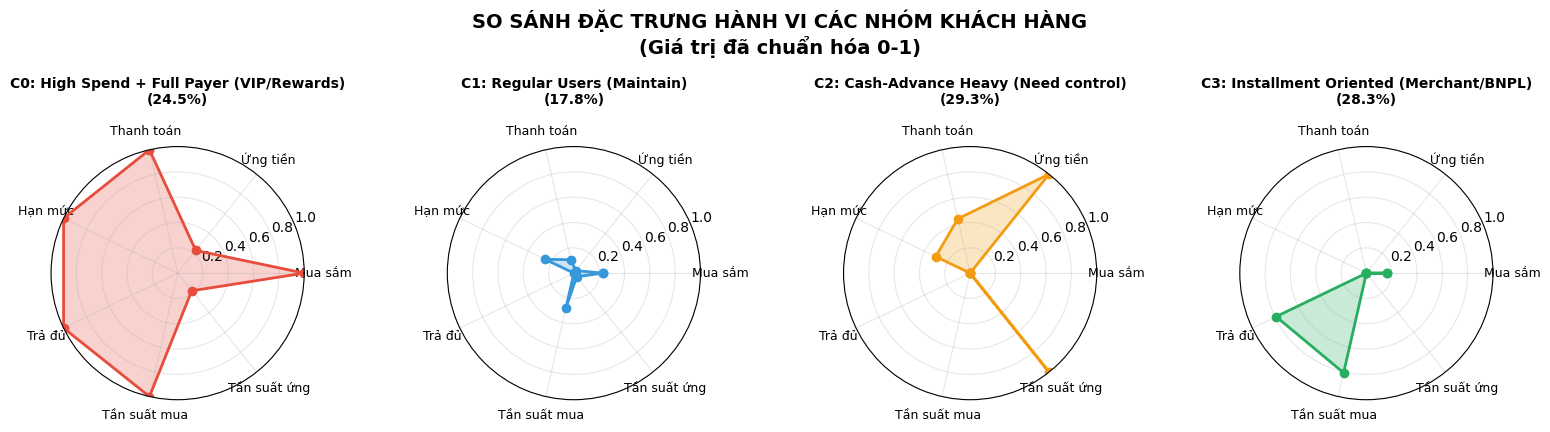


[INFO] Radar Chart - Đặc trưng nổi bật từng cụm:
  - C0 (High Spend + Full Payer (VIP/Rewards)): Cao nhất ở 'PURCHASES', thấp nhất ở 'CASH_ADVANCE_FREQUENCY'
  - C1 (Regular Users (Maintain)): Cao nhất ở 'PURCHASES_FREQUENCY', thấp nhất ở 'PRC_FULL_PAYMENT'
  - C2 (Cash-Advance Heavy (Need control)): Cao nhất ở 'CASH_ADVANCE', thấp nhất ở 'PURCHASES'
  - C3 (Installment Oriented (Merchant/BNPL)): Cao nhất ở 'PURCHASES_FREQUENCY', thấp nhất ở 'CASH_ADVANCE'


In [57]:
# Chuẩn bị dữ liệu cho radar chart (chuẩn hóa 0-1)
radar_features = ['PURCHASES', 'CASH_ADVANCE', 'PAYMENTS', 'CREDIT_LIMIT', 
                  'PRC_FULL_PAYMENT', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']
radar_features = [f for f in radar_features if f in cluster_summary.columns]

if len(radar_features) < 3:
    print("[WARNING] Không đủ features để vẽ radar chart")
else:
    radar_data = cluster_summary[radar_features].copy()
    
    # Chuẩn hóa min-max cho radar chart
    for col in radar_features:
        min_val = radar_data[col].min()
        max_val = radar_data[col].max()
        if max_val > min_val:
            radar_data[col] = (radar_data[col] - min_val) / (max_val - min_val)
        else:
            radar_data[col] = 0
    
    # Tạo radar chart (số subplot = số cluster)
    n_clusters = len(cluster_counts)
    ncols_radar = min(n_clusters, 4)
    nrows_radar = int(np.ceil(n_clusters / ncols_radar))
    
    fig, axes = plt.subplots(nrows_radar, ncols_radar, figsize=(4*ncols_radar, 4*nrows_radar), 
                             subplot_kw=dict(polar=True))
    if n_clusters == 1:
        axes = np.array([axes])
    axes = np.array(axes).flatten()
    
    # Số biến
    num_vars = len(radar_features)
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Đóng hình
    
    # Nhãn ngắn gọn
    labels_short_map = {
        'PURCHASES': 'Mua sắm',
        'CASH_ADVANCE': 'Ứng tiền',
        'PAYMENTS': 'Thanh toán',
        'CREDIT_LIMIT': 'Hạn mức',
        'PRC_FULL_PAYMENT': 'Trả đủ',
        'PURCHASES_FREQUENCY': 'Tần suất mua',
        'CASH_ADVANCE_FREQUENCY': 'Tần suất ứng'
    }
    labels_short = [labels_short_map.get(f, f) for f in radar_features]
    
    for idx, cluster_id in enumerate(sorted(cluster_counts.index)):
        if idx >= len(axes):
            break
        ax = axes[idx]
        
        values = radar_data.loc[cluster_id].values.tolist()
        values += values[:1]  # Đóng hình
        
        color = cluster_colors[idx % len(cluster_colors)]
        ax.plot(angles, values, 'o-', linewidth=2, color=color)
        ax.fill(angles, values, alpha=0.25, color=color)
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels_short, fontsize=9)
        ax.set_ylim(0, 1)
        
        # Title với tên cluster từ auto-naming
        title_name = cluster_names.get(cluster_id, f'Cluster {cluster_id}')
        pct = cluster_counts.get(cluster_id, 0) / total_n * 100
        ax.set_title(f'C{cluster_id}: {title_name}\n({pct:.1f}%)', fontsize=10, fontweight='bold', pad=15)
        ax.grid(True, alpha=0.3)
    
    # Ẩn các axes thừa
    for idx in range(n_clusters, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('SO SÁNH ĐẶC TRƯNG HÀNH VI CÁC NHÓM KHÁCH HÀNG\n(Giá trị đã chuẩn hóa 0-1)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # In giải thích động dựa trên đặc trưng thực tế
    print("\n[INFO] Radar Chart - Đặc trưng nổi bật từng cụm:")
    for cluster_id in sorted(cluster_counts.index):
        name = cluster_names.get(cluster_id, f'Cluster {cluster_id}')
        row = radar_data.loc[cluster_id]
        top_feat = row.idxmax()
        low_feat = row.idxmin()
        print(f"  - C{cluster_id} ({name}): Cao nhất ở '{top_feat}', thấp nhất ở '{low_feat}'")

#### **4.2.3 Heatmap và Ma trận Rủi ro - Giá trị**

- **Heatmap Z-score**: So sánh các đặc trưng của từng nhóm so với trung bình (màu xanh = cao hơn TB, màu đỏ = thấp hơn TB)
- **Ma trận Rủi ro - Giá trị**: Xác định vị trí từng nhóm trên ma trận 2 chiều (Rủi ro vs Giá trị)


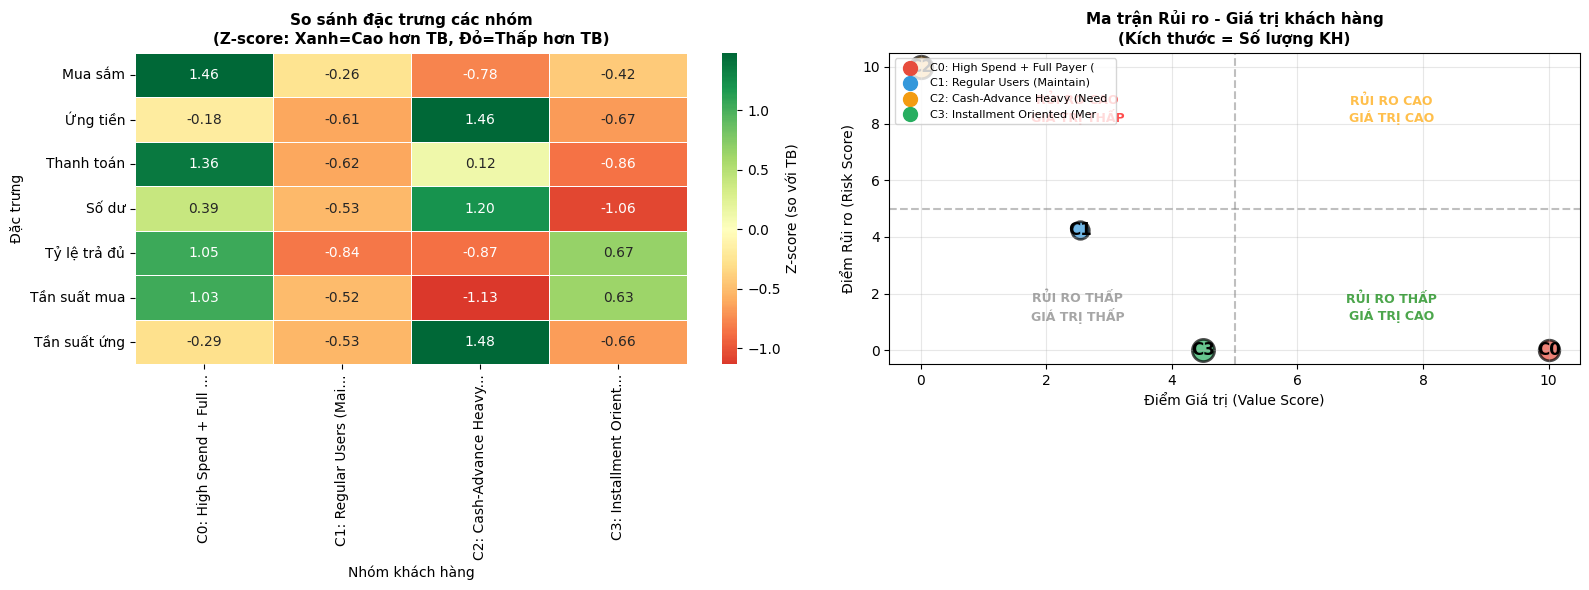


[INFO] Ma trận Rủi ro - Giá trị:
  - C0 (High Spend + Full Payer (VIP/Rewards)): RỦI RO THẤP, GIÁ TRỊ CAO - VIP cần giữ chân
  - C1 (Regular Users (Maintain)): RỦI RO THẤP, GIÁ TRỊ THẤP - cần kích hoạt nhẹ
  - C2 (Cash-Advance Heavy (Need control)): RỦI RO CAO, GIÁ TRỊ THẤP - cần kiểm soát/kích hoạt
  - C3 (Installment Oriented (Merchant/BNPL)): RỦI RO THẤP, GIÁ TRỊ THẤP - cần kích hoạt nhẹ


In [58]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax1 = axes[0]

heatmap_features = ['PURCHASES', 'CASH_ADVANCE', 'PAYMENTS', 'BALANCE', 
                    'PRC_FULL_PAYMENT', 'PURCHASES_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']
heatmap_features = [f for f in heatmap_features if f in df_with_clusters.columns]

if len(heatmap_features) >= 3:
    cluster_means_hm = df_with_clusters.groupby('Cluster')[heatmap_features].mean()
    cluster_means_zscore = (cluster_means_hm - cluster_means_hm.mean()) / (cluster_means_hm.std() + 1e-9)
    
    # Đổi tên index dựa trên cluster_names
    idx_names = []
    for cid in cluster_means_zscore.index:
        short_name = cluster_names.get(cid, f'Cluster {cid}')
        # Rút gọn tên nếu quá dài
        if len(short_name) > 20:
            short_name = short_name[:18] + '...'
        idx_names.append(f'C{cid}: {short_name}')
    cluster_means_zscore.index = idx_names
    
    column_names_vn = {
        'PURCHASES': 'Mua sắm',
        'CASH_ADVANCE': 'Ứng tiền',
        'PAYMENTS': 'Thanh toán',
        'BALANCE': 'Số dư',
        'PRC_FULL_PAYMENT': 'Tỷ lệ trả đủ',
        'PURCHASES_FREQUENCY': 'Tần suất mua',
        'CASH_ADVANCE_FREQUENCY': 'Tần suất ứng'
    }
    cluster_means_zscore.columns = [column_names_vn.get(c, c) for c in cluster_means_zscore.columns]
    
    sns.heatmap(cluster_means_zscore.T, annot=True, fmt='.2f', cmap='RdYlGn', 
                center=0, ax=ax1, cbar_kws={'label': 'Z-score (so với TB)'}, linewidths=0.5)
    ax1.set_title('So sánh đặc trưng các nhóm\n(Z-score: Xanh=Cao hơn TB, Đỏ=Thấp hơn TB)', 
                  fontsize=11, fontweight='bold')
    ax1.set_xlabel('Nhóm khách hàng', fontsize=10)
    ax1.set_ylabel('Đặc trưng', fontsize=10)
else:
    ax1.text(0.5, 0.5, 'Không đủ features để vẽ heatmap', ha='center', va='center')
    ax1.axis('off')

# Ma trận Rủi ro - Giá trị
ax2 = axes[1]

# Tính điểm Rủi ro và Giá trị cho từng cluster (dynamic)
if 'CASH_ADVANCE_FREQUENCY' in cluster_summary.columns and 'PRC_FULL_PAYMENT' in cluster_summary.columns:
    risk_score = cluster_summary['CASH_ADVANCE_FREQUENCY'] + (1 - cluster_summary['PRC_FULL_PAYMENT'])
else:
    # Fallback nếu thiếu cột
    risk_score = pd.Series([0.5] * n_clusters, index=cluster_summary.index)

if 'PURCHASES' in cluster_summary.columns and 'PURCHASES_FREQUENCY' in cluster_summary.columns:
    value_score = cluster_summary['PURCHASES'] / (cluster_summary['PURCHASES'].max() + 1e-9) + cluster_summary['PURCHASES_FREQUENCY']
else:
    value_score = pd.Series([0.5] * n_clusters, index=cluster_summary.index)

# Chuẩn hóa 0-10
risk_min, risk_max = risk_score.min(), risk_score.max()
value_min, value_max = value_score.min(), value_score.max()

if risk_max > risk_min:
    risk_score_norm = (risk_score - risk_min) / (risk_max - risk_min) * 10
else:
    risk_score_norm = pd.Series([5] * n_clusters, index=cluster_summary.index)

if value_max > value_min:
    value_score_norm = (value_score - value_min) / (value_max - value_min) * 10
else:
    value_score_norm = pd.Series([5] * n_clusters, index=cluster_summary.index)

# Scatter plot
for i, cid in enumerate(sorted(cluster_counts.index)):
    ax2.scatter(value_score_norm.loc[cid], risk_score_norm.loc[cid], 
                s=cluster_counts.loc[cid]/10, c=cluster_colors[i % len(cluster_colors)], 
                alpha=0.7, edgecolors='black', linewidth=2)
    ax2.annotate(f'C{cid}', (value_score_norm.loc[cid], risk_score_norm.loc[cid]), 
                 fontsize=12, fontweight='bold', ha='center', va='center')

# Vẽ các vùng
ax2.axhline(y=5, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(x=5, color='gray', linestyle='--', alpha=0.5)

# Thêm nhãn vùng
ax2.text(2.5, 8.5, 'RỦI RO CAO\nGIÁ TRỊ THẤP', ha='center', va='center', 
         fontsize=9, color='red', fontweight='bold', alpha=0.7)
ax2.text(7.5, 8.5, 'RỦI RO CAO\nGIÁ TRỊ CAO', ha='center', va='center', 
         fontsize=9, color='orange', fontweight='bold', alpha=0.7)
ax2.text(2.5, 1.5, 'RỦI RO THẤP\nGIÁ TRỊ THẤP', ha='center', va='center', 
         fontsize=9, color='gray', fontweight='bold', alpha=0.7)
ax2.text(7.5, 1.5, 'RỦI RO THẤP\nGIÁ TRỊ CAO', ha='center', va='center', 
         fontsize=9, color='green', fontweight='bold', alpha=0.7)

ax2.set_xlabel('Điểm Giá trị (Value Score)', fontsize=10)
ax2.set_ylabel('Điểm Rủi ro (Risk Score)', fontsize=10)
ax2.set_title('Ma trận Rủi ro - Giá trị khách hàng\n(Kích thước = Số lượng KH)', 
              fontsize=11, fontweight='bold')
ax2.set_xlim(-0.5, 10.5)
ax2.set_ylim(-0.5, 10.5)
ax2.grid(True, alpha=0.3)

# Legend động
legend_labels = [f'C{cid}: {cluster_names.get(cid, f"Cluster {cid}")[:25]}' for cid in sorted(cluster_counts.index)]
legend_handles = [plt.scatter([], [], c=cluster_colors[i % len(cluster_colors)], s=100, label=legend_labels[i]) 
                  for i in range(n_clusters)]
ax2.legend(handles=legend_handles, labels=legend_labels, loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

# In phân tích động
print("\n[INFO] Ma trận Rủi ro - Giá trị:")
for cid in sorted(cluster_counts.index):
    name = cluster_names.get(cid, f'Cluster {cid}')
    v = value_score_norm.loc[cid]
    r = risk_score_norm.loc[cid]
    
    if r >= 5 and v < 5:
        quadrant = "RỦI RO CAO, GIÁ TRỊ THẤP - cần kiểm soát/kích hoạt"
    elif r >= 5 and v >= 5:
        quadrant = "RỦI RO CAO, GIÁ TRỊ CAO - cần quản lý balance"
    elif r < 5 and v < 5:
        quadrant = "RỦI RO THẤP, GIÁ TRỊ THẤP - cần kích hoạt nhẹ"
    else:
        quadrant = "RỦI RO THẤP, GIÁ TRỊ CAO - VIP cần giữ chân"
    
    print(f"  - C{cid} ({name}): {quadrant}")

#### **4.2.4 Chiến lược chuyển đổi khách hàng**

Biểu đồ sau thể hiện chiến lược chuyển đổi khách hàng từ nhóm rủi ro/giá trị thấp sang nhóm giá trị cao hơn, cùng với tỷ lệ mục tiêu cho từng chiến lược.


#### **4.2.5 Tổng kết Insights chính**

Các biểu đồ sau tổng hợp các phát hiện quan trọng từ phân khúc:
- Phân bổ rủi ro trong danh mục khách hàng
- Các phát hiện quan trọng với số liệu cụ thể


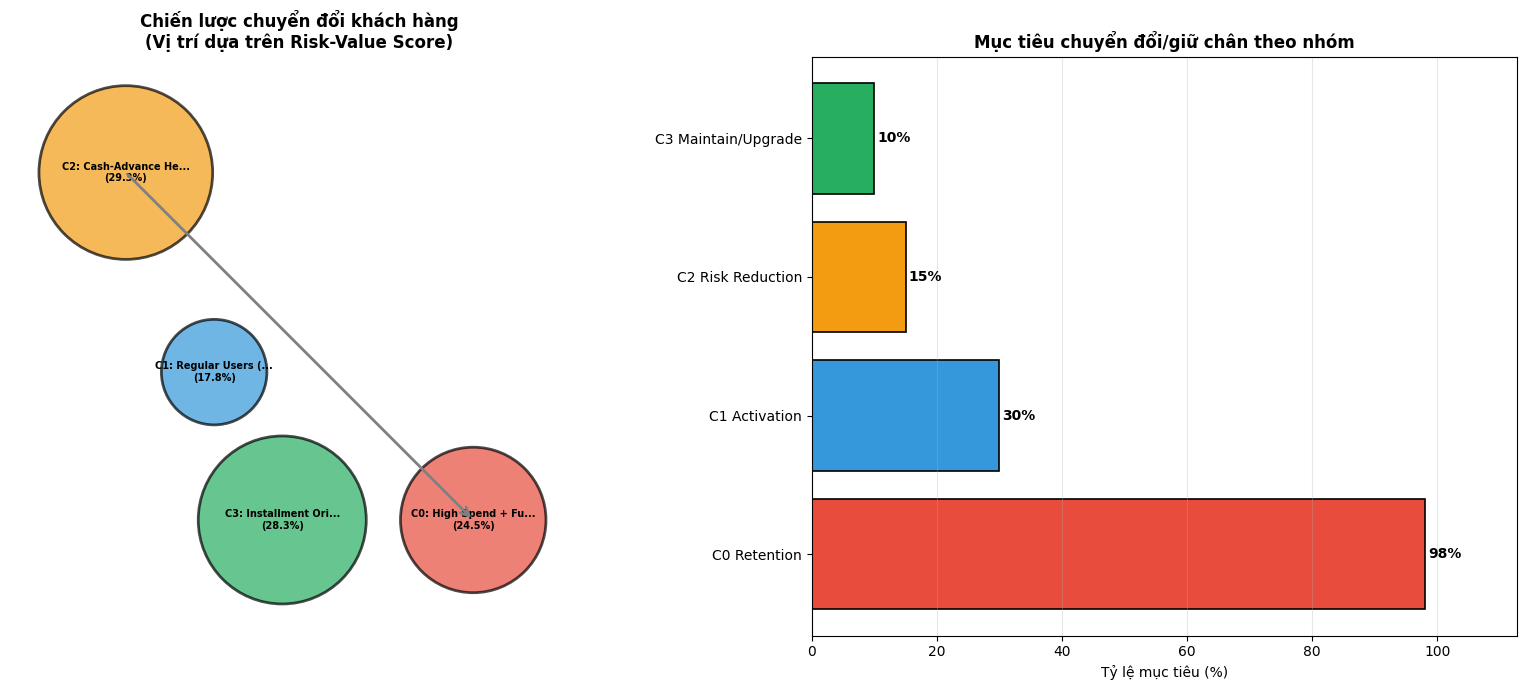


BẢNG CHIẾN LƯỢC CHUYỂN ĐỔI KHÁCH HÀNG (Động theo kết quả phân cụm)


Cluster                             Tên   % KH  \
0      C0  High Spend + Full Payer (VIP/R  24.5%   
1      C1        Regular Users (Maintain)  17.8%   
2      C2  Cash-Advance Heavy (Need contr  29.3%   
3      C3  Installment Oriented (Merchant  28.3%   

                        Chiến lược  Timeline Target  
0      Giữ chân, upgrade, referral  12 tháng    98%  
1          Kích hoạt, welcome back   3 tháng    30%  
2  Kiểm soát rủi ro, giảm ứng tiền   6 tháng    15%  
3              Duy trì, cross-sell   6 tháng    10%

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
ax1 = axes[0]

# Xác định vị trí các cluster dựa trên Risk/Value score
positions = {}
for i, cid in enumerate(sorted(cluster_counts.index)):
    v = value_score_norm.loc[cid] / 10  # 0-1
    r = risk_score_norm.loc[cid] / 10   # 0-1
    # Map to display position
    x_pos = 0.2 + v * 0.6  # 0.2 to 0.8
    y_pos = 0.2 + r * 0.6  # 0.2 to 0.8
    positions[cid] = (x_pos, y_pos)

# Kích thước theo số lượng KH
max_count = cluster_counts.max()
sizes = {cid: cluster_counts.loc[cid] / max_count * 0.15 for cid in cluster_counts.index}

# Vẽ các node
for cid in sorted(cluster_counts.index):
    pos = positions[cid]
    size = sizes[cid]
    name = cluster_names.get(cid, f'Cluster {cid}')
    pct = cluster_counts.loc[cid] / total_n * 100
    
    color_idx = list(sorted(cluster_counts.index)).index(cid)
    circle = plt.Circle(pos, size, color=cluster_colors[color_idx % len(cluster_colors)], 
                        alpha=0.7, ec='black', lw=2)
    ax1.add_patch(circle)
    
    # Label ngắn gọn
    short_name = name[:15] + '...' if len(name) > 15 else name
    ax1.text(pos[0], pos[1], f'C{cid}: {short_name}\n({pct:.1f}%)', 
             ha='center', va='center', fontsize=7, fontweight='bold')

# Vẽ mũi tên chuyển đổi (logic động)
arrow_props = dict(arrowstyle='->', color='gray', lw=2, mutation_scale=15)

# Xác định cluster có rủi ro cao nhất và thấp nhất
high_risk_clusters = [cid for cid in cluster_counts.index if risk_score_norm.loc[cid] >= 5]
low_risk_high_value = [cid for cid in cluster_counts.index if risk_score_norm.loc[cid] < 5 and value_score_norm.loc[cid] >= 5]
target_cluster = low_risk_high_value[0] if low_risk_high_value else sorted(cluster_counts.index)[0]

# Vẽ mũi tên từ high risk -> target
for src in high_risk_clusters[:2]:  # Giới hạn 2 mũi tên
    if src != target_cluster:
        src_pos = positions[src]
        tgt_pos = positions[target_cluster]
        # Offset để mũi tên không chồng lên node
        ax1.annotate('', xy=(tgt_pos[0], tgt_pos[1]), 
                    xytext=(src_pos[0], src_pos[1]), arrowprops=arrow_props)

ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_aspect('equal')
ax1.axis('off')
ax1.set_title('Chiến lược chuyển đổi khách hàng\n(Vị trí dựa trên Risk-Value Score)', fontsize=12, fontweight='bold')

# Right panel: Bar chart mục tiêu chuyển đổi
ax2 = axes[1]

conversion_targets = []
for cid in sorted(cluster_counts.index):
    name = cluster_names.get(cid, f'Cluster {cid}')
    r = risk_score_norm.loc[cid]
    v = value_score_norm.loc[cid]
    
    if 'Cash' in name or r >= 7:
        conversion_targets.append((f'C{cid} Risk Reduction', 15))
    elif 'Low' in name or 'Activity' in name.lower() or v < 3:
        conversion_targets.append((f'C{cid} Activation', 30))
    elif 'VIP' in name or 'Full Payer' in name or (r < 3 and v >= 7):
        conversion_targets.append((f'C{cid} Retention', 98))
    else:
        conversion_targets.append((f'C{cid} Maintain/Upgrade', 10))

if conversion_targets:
    labels = [ct[0] for ct in conversion_targets]
    values = [ct[1] for ct in conversion_targets]
    colors_conv = cluster_colors[:len(conversion_targets)]
    
    bars = ax2.barh(labels, values, color=colors_conv, edgecolor='black', linewidth=1.2)
    ax2.set_xlabel('Tỷ lệ mục tiêu (%)', fontsize=10)
    ax2.set_title('Mục tiêu chuyển đổi/giữ chân theo nhóm', fontsize=12, fontweight='bold')
    ax2.grid(True, axis='x', alpha=0.3)
    
    # Thêm giá trị
    for bar, val in zip(bars, values):
        ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                 f'{val}%', va='center', fontsize=10, fontweight='bold')
    ax2.set_xlim(0, max(values) * 1.15)

plt.tight_layout()
plt.show()

# In bảng chiến lược
print("\n" + "=" * 80)
print("BẢNG CHIẾN LƯỢC CHUYỂN ĐỔI KHÁCH HÀNG (Động theo kết quả phân cụm)")
print("=" * 80)

strategy_data = []
for cid in sorted(cluster_counts.index):
    name = cluster_names.get(cid, f'Cluster {cid}')
    r = risk_score_norm.loc[cid]
    v = value_score_norm.loc[cid]
    pct = cluster_counts.loc[cid] / total_n * 100
    
    if 'Cash' in name or r >= 7:
        strategy = 'Kiểm soát rủi ro, giảm ứng tiền'
        timeline = '6 tháng'
        target = '15%'
    elif 'Low' in name or 'Activity' in name.lower() or v < 3:
        strategy = 'Kích hoạt, welcome back'
        timeline = '3 tháng'
        target = '30%'
    elif 'VIP' in name or 'Full Payer' in name or (r < 3 and v >= 7):
        strategy = 'Giữ chân, upgrade, referral'
        timeline = '12 tháng'
        target = '98%'
    else:
        strategy = 'Duy trì, cross-sell'
        timeline = '6 tháng'
        target = '10%'
    
    strategy_data.append({
        'Cluster': f'C{cid}',
        'Tên': name[:30],
        '% KH': f'{pct:.1f}%',
        'Chiến lược': strategy,
        'Timeline': timeline,
        'Target': target
    })

display(pd.DataFrame(strategy_data))

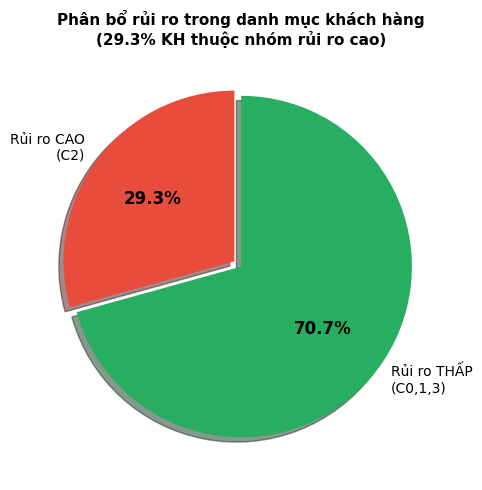


TỔNG KẾT KẾT QUẢ PHÂN KHÚC KHÁCH HÀNG

[1] TỔNG QUAN:
    - Tổng số khách hàng: 8,950
    - Số cụm: 4
    - Silhouette Score: 0.1847
    - ARI (K-Means vs HAC): 0.4379

[2] PHÂN BỔ THEO RỦI RO:
    - Rủi ro CAO: 29.3% (2,623 KH)
    - Rủi ro THẤP: 70.7% (6,327 KH)

[3] CHI TIẾT TỪNG CỤM:
    - C0: High Spend + Full Payer (VIP/Rewards)
      2,197 KH (24.5%) | Value=10.0/10 | Risk=0.0/10
    - C1: Regular Users (Maintain)
      1,593 KH (17.8%) | Value=2.5/10 | Risk=4.3/10
    - C2: Cash-Advance Heavy (Need control)
      2,623 KH (29.3%) | Value=0.0/10 | Risk=10.0/10
    - C3: Installment Oriented (Merchant/BNPL)
      2,537 KH (28.3%) | Value=4.5/10 | Risk=0.0/10


In [60]:
def pct_of_clusters(cluster_ids, cluster_counts, total_n):
    """Return percentage of customers in given cluster_ids."""
    if not cluster_ids:
        return 0.0
    return float(cluster_counts.loc[cluster_ids].sum() / total_n * 100)

def fmt_cluster_list(ids):
    return ",".join(map(str, ids)) if ids else "-"

# ----------------------------
# 1) Compute risk groups
# ----------------------------
high_risk_ids = [cid for cid in cluster_counts.index if float(risk_score_norm.loc[cid]) >= 5]
low_risk_ids  = [cid for cid in cluster_counts.index if float(risk_score_norm.loc[cid]) < 5]

high_risk_pct = pct_of_clusters(high_risk_ids, cluster_counts, total_n)
low_risk_pct  = pct_of_clusters(low_risk_ids, cluster_counts, total_n)

# ----------------------------
# 2) Plot (single chart -> no blank area)
# ----------------------------
fig, ax1 = plt.subplots(figsize=(10, 5))

risk_data = {
    f'Rủi ro CAO\n(C{fmt_cluster_list(high_risk_ids)})': high_risk_pct,
    f'Rủi ro THẤP\n(C{fmt_cluster_list(low_risk_ids)})': low_risk_pct
}

colors_risk = ['#e74c3c', '#27ae60']

if high_risk_pct > 0 and low_risk_pct > 0:
    wedges, texts, autotexts = ax1.pie(
        list(risk_data.values()),
        labels=list(risk_data.keys()),
        autopct='%1.1f%%',
        colors=colors_risk,
        explode=[0.05, 0],
        shadow=True,
        startangle=90,
        textprops={"fontsize": 10}
    )
    for autotext in autotexts:
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')

    ax1.set_title(
        f'Phân bổ rủi ro trong danh mục khách hàng\n({high_risk_pct:.1f}% KH thuộc nhóm rủi ro cao)',
        fontsize=11, fontweight='bold'
    )
else:
    ax1.text(
        0.5, 0.5,
        'Không đủ dữ liệu để phân loại rủi ro',
        ha='center', va='center',
        transform=ax1.transAxes,
        fontsize=12, fontweight='bold'
    )
    ax1.axis('off')

plt.tight_layout()
plt.show()

# ----------------------------
# 3) Print summary
# ----------------------------
print("\n" + "=" * 80)
print("TỔNG KẾT KẾT QUẢ PHÂN KHÚC KHÁCH HÀNG")
print("=" * 80)

print(f"\n[1] TỔNG QUAN:")
print(f"    - Tổng số khách hàng: {total_n:,}")
print(f"    - Số cụm: {n_clusters}")
if 'final_silhouette' in globals():
    print(f"    - Silhouette Score: {final_silhouette:.4f}")
if 'ari' in globals():
    print(f"    - ARI (K-Means vs HAC): {ari:.4f}")

print(f"\n[2] PHÂN BỔ THEO RỦI RO:")
print(f"    - Rủi ro CAO: {high_risk_pct:.1f}% ({int(round(high_risk_pct/100*total_n)):,} KH)")
print(f"    - Rủi ro THẤP: {low_risk_pct:.1f}% ({int(round(low_risk_pct/100*total_n)):,} KH)")

print(f"\n[3] CHI TIẾT TỪNG CỤM:")
for cid in sorted(cluster_counts.index):
    name = cluster_names.get(cid, f'Cluster {cid}')
    count = int(cluster_counts.loc[cid])
    pct = count / total_n * 100
    v = float(value_score_norm.loc[cid])
    r = float(risk_score_norm.loc[cid])

    print(f"    - C{cid}: {name}")
    print(f"      {count:,} KH ({pct:.1f}%) | Value={v:.1f}/10 | Risk={r:.1f}/10")


### **4.3 Chiến lược Marketing theo loại nhóm khách hàng**

> **Quan trọng**: Chiến lược dựa trên **kết quả auto-naming động** từ phần 3 (cell `TONG KET K-MEANS CLUSTERING`). 
> 
> Hệ thống auto-naming có thể phân loại các cluster thành **6 loại persona** sau:
> 1. **Cash-Advance Heavy (Need control)** - Rủi ro cao
> 2. **Low Activity (Activation)** - Cần kích hoạt
> 3. **High Spend + Full Payer (VIP/Rewards)** - Khách hàng giá trị cao
> 4. **Installment Oriented (Merchant/BNPL)** - Thích trả góp
> 5. **High Utilization Revolver (Balance mgmt)** - Sử dụng hạn mức cao, không trả hết
> 6. **Regular Users (Maintain)** - Khách hàng thông thường
>
> **Kiểm tra output phần 3 để xem cluster nào thuộc loại nào, sau đó áp dụng chiến lược tương ứng bên dưới.**

#### **4.3.1 Nhóm Cash-Advance Heavy (Need control) - Chiến lược Kiểm soát Rủi ro**

**Đặc điểm nhận diện**: Tần suất/giá trị ứng tiền mặt cao, tỷ lệ thanh toán đầy đủ thấp.

| Hành động | Chi tiết | Mục tiêu | KPI theo dõi |
|-----------|----------|----------|--------------|
| Giảm hạn mức ứng tiền | Giới hạn ≤30% hạn mức tín dụng | Giảm exposure | % giảm ứng tiền |
| Tăng phí ứng tiền | Phí 3-5% thay vì 2% | Hạn chế hành vi | Tần suất ứng tiền giảm |
| Cảnh báo sớm | SMS/Email khi ứng >50% hạn mức | Ngăn chặn rủi ro | Tỷ lệ phản hồi |
| Khuyến khích mua sắm | Cashback 3% cho mua sắm POS | Thay đổi hành vi | Tỷ lệ PURCHASES/CASH_ADVANCE |
| Chương trình trả nợ | Trả góp nợ cũ với lãi suất ưu đãi | Giảm nợ xấu | Tỷ lệ thanh toán |

**Mục tiêu**: Giảm 30% tỷ lệ ứng tiền mặt, tăng PRC_FULL_PAYMENT lên 15% trong 6 tháng.

#### **4.3.2 Nhóm Regular Users (Maintain) - Chiến lược Duy trì và Phát triển**

**Đặc điểm nhận diện**: Hành vi cân bằng, mua sắm ổn định, rủi ro trung bình-thấp. Đây thường là nhóm lớn nhất.

| Hành động | Chi tiết | Mục tiêu | KPI theo dõi |
|-----------|----------|----------|--------------|
| Chương trình tích điểm | 1 điểm = 10,000đ chi tiêu | Tăng engagement | Điểm tích lũy/tháng |
| Cashback ổn định | 0.5-1% cho mọi giao dịch | Duy trì sử dụng | Tần suất giao dịch |
| Cross-sell nhẹ | Giới thiệu bảo hiểm, vay | Tăng doanh thu | Tỷ lệ chuyển đổi |
| Tăng hạn mức tự động | +10% cho KH >12 tháng tốt | Tăng chi tiêu | ARPU tăng |

**Stage-2 Segmentation** (nếu áp dụng): Chia nhỏ theo Value/Risk Score để cá nhân hóa:

| Sub-segment | Chiến lược |
|-------------|------------|
| HighValue_LowRisk | Upsell, rewards cao cấp |
| HighValue_HighRisk | Balance mgmt, chuyển đổi trả góp |
| LowValue_LowRisk | Activation nhẹ, deal nhỏ |
| LowValue_HighRisk | Giám sát, education về phí/lãi |

#### **4.3.3 Nhóm Low Activity (Activation) - Chiến lược Kích hoạt**

**Đặc điểm nhận diện**: HAS_PURCHASE thấp, PURCHASES thấp, PURCHASES_FREQUENCY thấp.

| Hành động | Chi tiết | Mục tiêu | KPI theo dõi |
|-----------|----------|----------|--------------|
| Welcome Back Campaign | Email series 3 tuần | Re-engage | Open/Click rate |
| Ưu đãi đầu tiên | Giảm 20% giao dịch đầu | Kích hoạt mua sắm | Tỷ lệ activation |
| Miễn phí thường niên | 1 năm miễn phí nếu chi ≥2tr | Khuyến khích dùng | % sử dụng |
| Partnership deals | Voucher đối tác (Grab, Shopee) | Thu hút sử dụng | Tỷ lệ redemption |
| Đóng tài khoản | Sau 12 tháng không phản hồi | Giảm chi phí | % churn có kiểm soát |

**Mục tiêu**: Kích hoạt 30% khách hàng trong 6 tháng, tăng PURCHASES từ $0 lên ≥$200/tháng.

#### **4.3.4 Nhóm High Spend + Full Payer (VIP/Rewards) - Chiến lược Giữ chân và Nâng cấp**

**Đặc điểm nhận diện**: PURCHASES cao (≥Q75), FULL_PAYER_FLAG cao hoặc PRC_FULL_PAYMENT cao.

| Hành động | Chi tiết | Mục tiêu | KPI theo dõi |
|-----------|----------|----------|--------------|
| Tăng hạn mức 50% | Ưu tiên tăng nhanh | Tăng chi tiêu | Tỷ lệ sử dụng hạn mức |
| Cashback cao cấp | 2-5% cho danh mục premium | Giữ chân VIP | Retention rate |
| Lounge Airport | Miễn phí 4 lần/năm | Loyalty | Usage rate |
| Concierge service | Hỗ trợ 24/7 ưu tiên | Trải nghiệm | NPS score |
| Exclusive events | Mời sự kiện VIP | Brand love | Attendance rate |
| Referral program | Thưởng khi giới thiệu VIP mới | Mở rộng | # referrals |

**Mục tiêu**: Retention rate ≥98%, NPS score ≥60, tăng PURCHASES 25% trong 6 tháng.

#### **4.3.5 Nhóm Installment Oriented (Merchant/BNPL) - Chiến lược Trả góp**

**Đặc điểm nhận diện**: INSTALLMENT_SHARE cao (≥Q75), thích mua trả góp hơn one-off.

| Hành động | Chi tiết | Mục tiêu | KPI theo dõi |
|-----------|----------|----------|--------------|
| Partnership BNPL | Hợp tác Kredivo, Home Credit | Mở rộng merchant | # merchant partners |
| 0% trả góp | 0% lãi suất 3-6 tháng với merchant | Tăng GMV | Tổng GMV trả góp |
| Cashback trả góp | 1-2% cho giao dịch trả góp | Khuyến khích | % installment/total |
| Cross-sell vay | Giới thiệu vay tiêu dùng | Tăng doanh thu | Conversion rate |
| Early payment bonus | Thưởng nếu trả sớm | Giảm risk | % trả sớm |

**Mục tiêu**: Tăng 20% GMV trả góp, mở rộng 50 merchant partners trong 6 tháng.

#### **4.3.6 Nhóm High Utilization Revolver (Balance mgmt) - Chiến lược Quản lý Nợ**

**Đặc điểm nhận diện**: HIGH_UTIL_FLAG cao (CREDIT_UTILIZATION ≥70%), FULL_PAYER_FLAG thấp.

| Hành động | Chi tiết | Mục tiêu | KPI theo dõi |
|-----------|----------|----------|--------------|
| Balance transfer | Chuyển nợ lãi suất thấp 0-3% | Giảm nợ xấu | Số tiền chuyển |
| Chuyển đổi trả góp | Convert dư nợ → trả góp | Dễ thanh toán | % convert |
| Education campaign | Email/SMS về lãi suất compound | Awareness | Open/Click rate |
| Tăng hạn mức có điều kiện | +20% nếu giảm utilization về <50% | Khuyến khích hành vi tốt | % đạt điều kiện |
| Early warning | Alert khi utilization >80% | Ngăn chặn | Response rate |

**Mục tiêu**: Giảm CREDIT_UTILIZATION trung bình về <60%, tăng PRC_FULL_PAYMENT 10% trong 6 tháng.

### **4.4 Bảng tổng hợp chiến lược theo loại nhóm**

| Loại nhóm (Auto-naming) | Đặc điểm nhận diện | Rủi ro | Chiến lược chính | Budget Priority |
|-------------------------|-------------------|--------|------------------|-----------------|
| **Cash-Advance Heavy (Need control)** | CASH_HEAVY_FLAG cao, CASH_RATIO ≥30% | CAO | Kiểm soát, giảm hạn mức ứng tiền | Medium (Risk mgmt) |
| **Low Activity (Activation)** | HAS_PURCHASE thấp, PURCHASES_FREQUENCY thấp | TRUNG BÌNH | Kích hoạt, welcome back | Medium (Activation) |
| **High Spend + Full Payer (VIP/Rewards)** | PURCHASES ≥Q75, FULL_PAYER_FLAG cao | RẤT THẤP | Giữ chân, upgrade VIP | Highest (VIP) |
| **Installment Oriented (Merchant/BNPL)** | INSTALLMENT_SHARE ≥Q75 | THẤP | Partnership, 0% trả góp | High (Growth) |
| **High Utilization Revolver (Balance mgmt)** | HIGH_UTIL_FLAG cao, FULL_PAYER_FLAG thấp | TRUNG BÌNH-CAO | Balance transfer, education | Medium (Risk mgmt) |
| **Regular Users (Maintain)** | Không nổi bật ở các tiêu chí trên | THẤP | Duy trì, cross-sell | High (Core) |

> **Hướng dẫn mapping**: Xem output cell `TONG KET K-MEANS CLUSTERING` ở phần 3 để biết cluster nào thuộc loại nào, sau đó áp dụng chiến lược tương ứng.

### **4.5 KPIs theo dõi hiệu quả phân khúc**

#### **KPIs cấp chiến lược (Quarterly review)**

| KPI | Công thức | Mục tiêu |
|-----|-----------|----------|
| Churn Rate | KH rời bỏ / Tổng KH | Giảm 2% mỗi quý |
| ARPU | Doanh thu / Tổng KH | Tăng 10% trong 6 tháng |
| CLV (Customer Lifetime Value) | LTV model | Tăng 15% trong 12 tháng |
| Risk Exposure | Nợ xấu / Tổng dư nợ | Giảm 20% trong 6 tháng |
| Activation Rate | KH active / Tổng KH Low Activity | Đạt 30% trong 6 tháng |

#### **KPIs theo loại nhóm (Monthly review)**

| Loại nhóm (Auto-naming) | KPI chính | KPI phụ |
|-------------------------|-----------|---------|
| Cash-Advance Heavy (Need control) | Giảm CASH_ADVANCE_FREQUENCY | Tăng PRC_FULL_PAYMENT |
| Low Activity (Activation) | Tỷ lệ kích hoạt (HAS_PURCHASE) | Tăng PURCHASES |
| High Spend + Full Payer (VIP/Rewards) | Retention rate | Referral count, NPS |
| Installment Oriented (Merchant/BNPL) | GMV trả góp | # merchant partners |
| High Utilization Revolver (Balance mgmt) | Giảm CREDIT_UTILIZATION | Tăng PRC_FULL_PAYMENT |
| Regular Users (Maintain) | Duy trì PURCHASES_FREQUENCY | Cross-sell conversion |

> **Lưu ý**: Chỉ theo dõi KPIs cho các nhóm **thực sự xuất hiện** trong kết quả phân cụm của bạn.

### **4.6 Kết luận và Khuyến nghị**

#### **Tóm tắt kết quả**

1. **Phân cụm thành công** khách hàng thẻ tín dụng thành các nhóm có đặc trưng hành vi rõ ràng
2. **Độ tin cậy**: K-Means và Hierarchical cho kết quả tương đồng (xem ARI ở output)
3. **Auto-naming**: Hệ thống tự động đặt tên cluster dựa trên FLAGS và quantile-based rules
4. **Actionable insights**: Mỗi loại nhóm (trong 6 loại có thể) có chiến lược marketing cụ thể, đo lường được

#### **Phát hiện quan trọng**

> Xem kết quả động ở cell `TONG KET K-MEANS CLUSTERING` (phần 3) và biểu đồ 4.2 để có con số chính xác.

**Các loại persona có thể xuất hiện:**
- **Cash-Advance Heavy**: Rủi ro cao, cần kiểm soát hạn mức ứng tiền
- **Low Activity**: Cần kích hoạt hoặc cân nhắc đóng tài khoản nếu không phản hồi  
- **High Spend + Full Payer (VIP)**: Giá trị cao, cần giữ chân và nâng cấp
- **Installment Oriented**: Thích trả góp, tiềm năng partnership BNPL
- **High Utilization Revolver**: Cần quản lý nợ, balance transfer
- **Regular Users**: Core business, thường là nhóm lớn nhất

#### **Khuyến nghị hành động**

**Ngắn hạn (0-3 tháng):**
- Triển khai cảnh báo sớm cho nhóm Cash-Advance Heavy (nếu có)
- Gửi welcome back campaign cho nhóm Low Activity (nếu có)
- Gán nhãn VIP trong hệ thống CRM cho nhóm High Spend + Full Payer

**Trung hạn (3-6 tháng):**
- Áp dụng Stage-2 segmentation cho Regular Users (nếu nhóm này lớn)
- Triển khai partnership BNPL cho nhóm Installment Oriented (nếu có)
- Balance transfer program cho nhóm High Utilization Revolver (nếu có)
- Đánh giá hiệu quả chiến lược chuyển đổi
- Điều chỉnh hạn mức và phí cho từng nhóm

**Dài hạn (6-12 tháng):**
- Re-cluster với dữ liệu mới (quarterly) - auto-naming sẽ tự cập nhật
- Tích hợp mô hình vào hệ thống CRM real-time
- Xây dựng dashboard theo dõi KPIs theo cluster

### **4.7 Hạn chế và Hướng phát triển**

#### **Hạn chế của nghiên cứu**

1. **Dữ liệu tĩnh**: Chỉ phân tích snapshot 6 tháng, chưa có time-series
2. **Silhouette Score**: Có thể ở mức trung bình do các cụm có chồng lấn
3. **Thiếu dữ liệu demographics**: Chưa có tuổi, thu nhập, nghề nghiệp
4. **Không có feedback loop**: Chưa đo được hiệu quả chiến lược thực tế

#### **Hướng phát triển**

| Hướng | Mô tả | Impact |
|-------|-------|--------|
| Time-series clustering | Phân cụm theo trajectory hành vi | Dự đoán churn sớm |
| RFM Integration | Kết hợp Recency-Frequency-Monetary | Cải thiện phân khúc |
| Predictive modeling | Dự đoán chuyển nhóm | Proactive marketing |
| A/B testing | Test chiến lược từng nhóm | Optimize campaigns |
| Real-time scoring | Cập nhật cluster liên tục | Personalization |